In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=6e5aee0c373a5a49de4990567bcac2f289b0a120c6f977f2530e0cf70bce55c5
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
source_file_path = '/kaggle/input/yunbase/Yunbase/baseline.py'
target_file_path = '/kaggle/working/baseline.py'

with open(source_file_path, 'r', encoding='utf-8') as file:
    content = file.read()
    
with open(target_file_path, 'w', encoding='utf-8') as file:
    file.write(content)

# !pip install -q --requirement /kaggle/input/yunbase/Yunbase/requirements.txt  \
# --no-index --find-links file:/kaggle/input/yunbase/

!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whl

!pip install -q /kaggle/input/yunbase/cir_model-0.2.0-py3-none-any.whl
!pip install -q /kaggle/input/yunbase/pyspellchecker-0.8.1-py3-none-any.whl
!pip install -q /kaggle/input/yunbase/ftfy-6.3.1-py3-none-any.whl

import pytorch_lightning as pl
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from pytorch_lightning.utilities import grad_norm
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging

from baseline import Yunbase

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


In [3]:
import pickle
import joblib
import os

import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt

from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection import KFold, GroupKFold, StratifiedGroupKFold, train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error

from lifelines import KaplanMeierFitter, NelsonAalenFitter, AalenJohansenFitter
from lifelines.utils import concordance_index

#from openfe import OpenFE, transform, tree_to_formula, TwoStageFeatureSelector

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from lightgbm import LGBMRegressor, callback
import lightgbm as lgb

from scipy.stats import rankdata 
from metric import score

In [4]:
USE_GPU = False
TRAIN = False

CAT_PATH = '/kaggle/input/cibmtr-models-6/cat_models' # 0.6755642100489615 [TUNED]
XGB_PATH = '/kaggle/input/cibmtr-xgb-tuned-default/xgb_models' # 0.6762560827275105 [TUNED]
LGB_PATH = '/kaggle/input/cibmtr-models/lgb_models'

CAT_Y2_PATH = '/kaggle/input/cibmtr-models-5/cat_models_y2' # 0.676481535824269 [TUNED]
XGB_Y2_PATH = '/kaggle/input/cibmtr-xgb-tuned/xgb_models_y2' # 0.6784678915237513 [TUNED]
LGB_Y2_PATH = '/kaggle/input/cibmtr-models/lgb_models_y2'

CAT_BRESLOW_PATH = '/kaggle/input/cibmtr-cat-breslow-tuned/cat_breslow_models' # 0.6744664889756109 [TUNED]
XGB_BRESLOW_PATH = '/kaggle/input/xgb-breslow-models/xgb_breslow_models' # 0.6759622791408132 [TUNED]
LGB_BRESLOW_PATH = '/kaggle/input/lgb-breslow-models/lgb_breslow_models' # 0.6755757740156817 [TUNED]

CAT_COX_PATH = '/kaggle/input/cibmtr-new-cox-cbs/results/cat_cox_models'
CAT_COX2_PATH = '/kaggle/input/cibmtr-new-cox-cbs/results/cat_cox2_models'
XGB_COX_PATH = '/kaggle/input/cibmtr-xgb-cox-tuned/xgb_cox_models' # 0.673565671668741 [TUNED]

CAT_PATHS = {
    'naf': '/kaggle/input/cibmtr-label-models/cat_models_naf',
    'kmf': '/kaggle/input/cibmtr-label-models/cat_models_kmf',
    'bfhf': '/kaggle/input/cibmtr-label-models/cat_models_bfhf',
    'cox': '/kaggle/input/cibmtr-label-models/cat_models_cox',
}

XGB_PATHS = {
    'naf': '/kaggle/input/cibmtr-label-models/xgb_models_naf',
    'kmf': '/kaggle/input/cibmtr-label-models/xgb_models_kmf',
    'bfhf': '/kaggle/input/cibmtr-label-models/xgb_models_bfhf',
    'cox': '/kaggle/input/cibmtr-label-models/xgb_models_cox',
}

LGB_PATHS = {
    'naf': '/kaggle/input/cibmtr-label-models/lgb_models_naf',
    'kmf': '/kaggle/input/cibmtr-label-models/lgb_models_kmf',
    'bfhf': '/kaggle/input/cibmtr-label-models/lgb_models_bfhf',
}

DEEPTABLES_PATH = '/kaggle/input/cibmtr-models/models'

HC_CAT_PATH = '/kaggle/input/cibmtr-models-3/hc_cat_models'
HC_XGB_PATH = '/kaggle/input/cibmtr-models-2/hc_xgb_models'
HC_LGB_PATH = '/kaggle/input/cibmtr-models-2/hc_lgb_models'

YUNBASE_PATH = '/kaggle/input/cibmtr-models-2/yunbase'

MULTITARGET_PATH = '/kaggle/input/cibmtr-models-4/multitarget_models'

TABM_PATH = '/kaggle/input/cibmtr-models-meier/tabm_models'
TABM_Y2_PATH = '/kaggle/input/cibmtr-tabm-y/tabm_models_aalen'
TABM_OLD_PATH = '/kaggle/input/cibmtr-tabm/tabm_models'

CAT_HAILMARY_PATH = '/kaggle/input/cibmtr-hail-mary/cat_hailmary_models'
XGB_HAILMARY_PATH = '/kaggle/input/cibmtr-hail-mary/xgb_hailmary_models'
LGB_HAILMARY_PATH = '/kaggle/input/cibmtr-hail-mary-fix-lgb/lgb_hailmary_models'

LITNN_PATH = '/kaggle/input/litnn-weights/litnn'
LITNN690_PATH = '/kaggle/input/cibmtr-litnn690/litnn690'
TABM_NEWLOSS = '/kaggle/input/cibmtr-tabm-newloss-10folds/lightning_logs'

In [5]:
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')

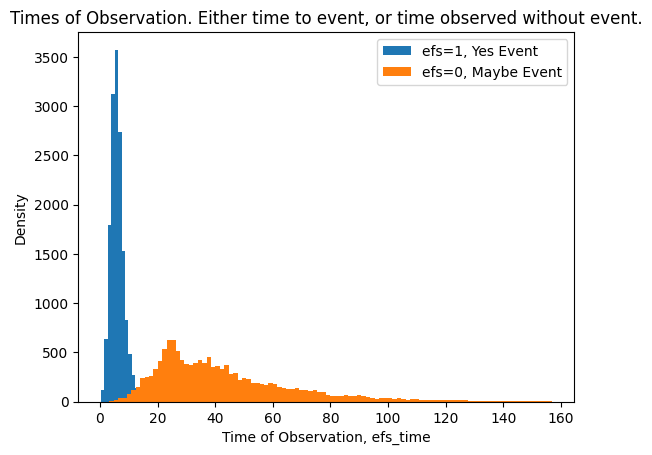

In [6]:
plt.hist(train.loc[train.efs == 1, "efs_time"], bins=100, label="efs=1, Yes Event")
plt.hist(train.loc[train.efs == 0, "efs_time"], bins=100, label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

In [7]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter, BreslowFlemingHarringtonFitter

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

def create_fold_specific_target(data, time_col='efs_time', event_col='efs', group_col='race_group'):
    cv = KFold(n_splits=10, shuffle=True, random_state=52)
    target = np.zeros(len(data))

    for train_index, valid_index in cv.split(data):
        train_data = data.iloc[train_index]
        valid_data = data.iloc[valid_index]

        kmf = KaplanMeierFitter()
        kmf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
        target[valid_index] = kmf.survival_function_at_times(valid_data[time_col]).values
        
    data['y'] = target
    
    return data

def create_fold_specific_target2(data, time_col='efs_time', event_col='efs', group_col='race_group'):
    cv = KFold(n_splits=10, shuffle=True, random_state=52)
    target = np.zeros(len(data))

    for train_index, valid_index in cv.split(data):
        train_data = data.iloc[train_index]
        valid_data = data.iloc[valid_index]

        naf = NelsonAalenFitter()
        naf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
        target[valid_index] = -naf.cumulative_hazard_at_times(valid_data[time_col]).values
        
    data['y_2'] = target
    
    return data

def create_fold_specific_target3(data, time_col='efs_time', event_col='efs', group_col='race_group'):
    cv = KFold(n_splits=10, shuffle=True, random_state=0xFACED)
    target = np.zeros(len(data))

    for train_index, valid_index in cv.split(data):
        train_data = data.iloc[train_index]
        valid_data = data.iloc[valid_index]

        kmf = BreslowFlemingHarringtonFitter()
        kmf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
        target[valid_index] = kmf.survival_function_at_times(valid_data[time_col]).values
        
    data['y_3'] = target
    
    return data

#train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train = create_fold_specific_target(train, time_col='efs_time', event_col='efs', group_col='race_group')
train = create_fold_specific_target2(train, time_col='efs_time', event_col='efs', group_col='race_group')
train = create_fold_specific_target3(train, time_col='efs_time', event_col='efs', group_col='race_group')

# race_group=sorted(train['race_group'].unique())
# for race in race_group:
#     train.loc[train['race_group']==race,"y"] = transform_survival_probability(train[train['race_group']==race], time_col='efs_time', event_col='efs')
# train.loc[train['efs']==0,'y']-=0.2

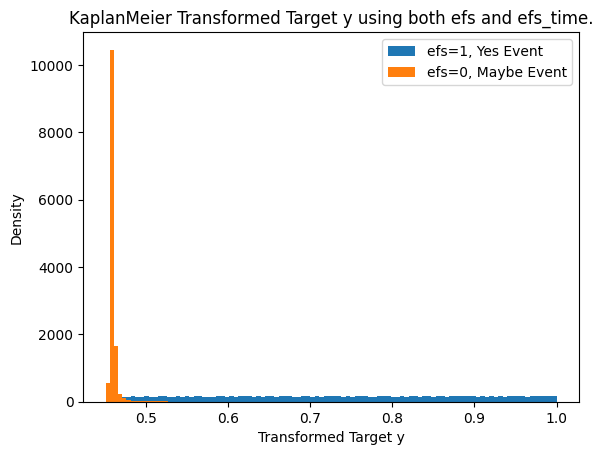

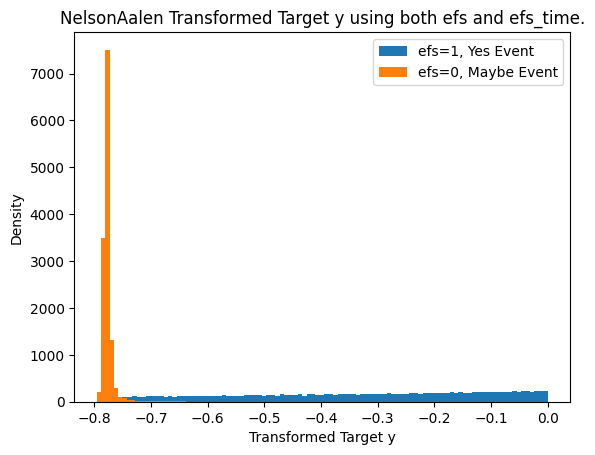

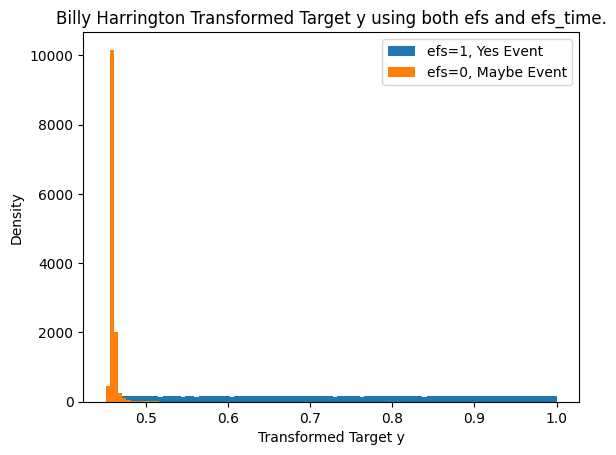

In [8]:
plt.hist(train.loc[train.efs == 1, "y"], bins=100, label="efs=1, Yes Event")
plt.hist(train.loc[train.efs == 0, "y"], bins=100, label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

plt.hist(train.loc[train.efs == 1, "y_2"], bins=100, label="efs=1, Yes Event")
plt.hist(train.loc[train.efs == 0, "y_2"], bins=100, label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("NelsonAalen Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

plt.hist(train.loc[train.efs == 1, "y_3"], bins=100, label="efs=1, Yes Event")
plt.hist(train.loc[train.efs == 0, "y_3"], bins=100, label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Billy Harrington Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [9]:
RMV = ["ID", "efs", "efs_time", "y", "y_2", "y_3"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [10]:
CATS = []
for c in FEATURES:
    if train[c].dtype == "object":
    #if train[c].nunique() < 5:
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [11]:
combined = pd.concat([train,test],axis=0,ignore_index=True)

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    #REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

# xgboost kaplan

In [12]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

device = 'cuda' if USE_GPU else 'cpu'

best_params = {
    'max_depth': 4, 
    'learning_rate': 0.026433914852264397, 
    'n_estimators': 2816, 
    'min_child_weight': 79, 
    'colsample_bytree': 0.49030862045241724, 
    'subsample': 0.815720411256146, 
    'reg_alpha': 0.04009113977548867, 
    'reg_lambda': 5.211053744202838,
    'enable_categorical': True,
    'device': 'cpu',
    'early_stopping_rounds': 100,
    'random_state': 52
}

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        model_xgb = XGBRegressor(**best_params)
        model_xgb.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],  
            verbose=500 
        )
        os.makedirs('/kaggle/working/xgb_models', exist_ok=True)
        joblib.dump(model_xgb, f'/kaggle/working/xgb_models/xgb_model_fold_{i}.pkl')
    else:
        model_xgb = joblib.load(os.path.join(XGB_PATH, f'xgb_model_fold_{i}.pkl'))

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################
CPU times: user 4.54 s, sys: 44 ms, total: 4.58 s
Wall time: 2.93 s


In [13]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m_xgb = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m_xgb)


Overall CV for XGBoost KaplanMeier = 0.6762560827275105


# xgboost aalen

In [14]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_xgb_2 = np.zeros(len(train))
pred_xgb_2 = np.zeros(len(test))

device = 'cuda' if USE_GPU else 'cpu'

best_params = {
    'max_depth': 9, 
    'learning_rate': 0.005286574450766226, 
    'n_estimators': 2831, 
    'min_child_weight': 86, 
    'colsample_bytree': 0.32815834999372, 
    'subsample': 0.8324626116114493, 
    'reg_alpha': 0.008957641170849238, 
    'reg_lambda': 0.012687754594348538,
    'enable_categorical': True,
    'device': 'cpu',
    'early_stopping_rounds': 100,
    'random_state': 52
}

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_2"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        model_xgb = XGBRegressor(**best_params)
        model_xgb.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],  
            verbose=500 
        )
        os.makedirs('/kaggle/working/xgb_models_y2', exist_ok=True)
        joblib.dump(model_xgb, f'/kaggle/working/xgb_models_y2/xgb_model_y2_fold_{i}.pkl')
    else:
        model_xgb = joblib.load(os.path.join(XGB_Y2_PATH, f'xgb_model_y2_fold_{i}.pkl'))

    # INFER OOF
    oof_xgb_2[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_2 += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_2 /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################
CPU times: user 15.5 s, sys: 423 ms, total: 16 s
Wall time: 9.85 s


In [15]:
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_2
m_xgb_2 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Aalen =",m_xgb_2)


Overall CV for XGBoost Aalen = 0.6784678915237513


# xgboost breslow

In [16]:
params = {
    'max_depth': 10,
    'learning_rate': 0.005690607831532036, 
    'n_estimators': 2884, 
    'min_child_weight': 164,
    'colsample_bytree': 0.33551715936932336,
    'subsample': 0.9067770501197371, 
    'reg_alpha': 0.0133286560172766, 
    'reg_lambda': 1.4141835390796844,
    "enable_categorical": True,
    "device": 'cpu',
    'early_stopping_rounds': 100,
    'random_state': 0xFACED
}

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=0xFACED)

oof_xgb_breslow = np.zeros(len(train))
pred_xgb_breslow = np.zeros(len(test))

final_model = XGBRegressor(**params)

for fold, (train_index, test_index) in enumerate(kf.split(train)):
    print("#" * 25)
    print(f"### Fold {fold + 1}")
    print("#" * 25)

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "y_3"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "y_3"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        final_model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=500
        )
    
        os.makedirs('/kaggle/working/xgb_breslow_models', exist_ok=True)
        joblib.dump(final_model, f'/kaggle/working/xgb_breslow_models/xgb_breslow_model_fold_{fold}.pkl')
    else:
        final_model = joblib.load(os.path.join(XGB_BRESLOW_PATH, f'xgb_breslow_model_fold_{fold}.pkl'))
        
    oof_xgb_breslow[test_index] = final_model.predict(x_valid)
    pred_xgb_breslow += final_model.predict(x_test)

pred_xgb_breslow /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [17]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_breslow
m_xgb_breslow = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Breslow =",m_xgb_breslow)


Overall CV for XGBoost Breslow = 0.6759622791408132


In [18]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


# catboost kaplan

In [19]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

device = 'GPU' if USE_GPU else 'CPU'

param = {
    'iterations': 2595, 
    'depth': 7, 
    'learning_rate': 0.029023932063424837, 
    'l2_leaf_reg': 4.476611407362352, 
    'grow_policy': 'SymmetricTree', 
    'random_strength': 4.666392709968282, 
    'border_count': 172, 
    'min_data_in_leaf': 157, 
    'colsample_bylevel': 0.24127530432914374, 
    'bootstrap_type': 'MVS', 
    'boosting_type': 'Plain',
    "early_stopping_rounds": 100,
    "random_seed": 52
}

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        model_cat = CatBoostRegressor(**param)
        model_cat.fit(x_train,y_train,
                  eval_set=(x_valid, y_valid),
                  cat_features=CATS,
                  verbose=250)
        os.makedirs('/kaggle/working/cat_models', exist_ok=True)
        joblib.dump(model_cat, f'/kaggle/working/cat_models/cat_model_fold_{i}.pkl')
    else:
        model_cat = joblib.load(os.path.join(CAT_PATH, f'cat_model_fold_{i}.pkl'))

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################
CPU times: user 1.69 s, sys: 109 ms, total: 1.8 s
Wall time: 1.17 s


In [20]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat
m_cat = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier =",m_cat)


Overall CV for CatBoost KaplanMeier = 0.6755642100489615


# catboost aalen

In [21]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_cat_2 = np.zeros(len(train))
pred_cat_2 = np.zeros(len(test))

device = 'GPU' if USE_GPU else 'CPU'

param = {
    'iterations': 2826, 
    'depth': 8, 
    'learning_rate': 0.018156991435496022, 
    'l2_leaf_reg': 0.8313630507917704, 
    'grow_policy': 'Depthwise', 
    'random_strength': 0.0018141337673459378, 
    'border_count': 59, 
    'min_data_in_leaf': 200, 
    'colsample_bylevel': 0.2565953559177259, 
    'bootstrap_type': 'MVS',
    "early_stopping_rounds": 100,
    "random_seed": 52
}

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_2"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        model_cat = CatBoostRegressor(**param)
        model_cat.fit(x_train,y_train,
                  eval_set=(x_valid, y_valid),
                  cat_features=CATS,
                  verbose=250)
        os.makedirs('/kaggle/working/cat_models_y2', exist_ok=True)
        joblib.dump(model_cat, f'/kaggle/working/cat_models_y2/cat_model_y2_fold_{i}.pkl')
    else:
        model_cat = joblib.load(os.path.join(CAT_Y2_PATH, f'cat_model_y2_fold_{i}.pkl'))
        
    # INFER OOF
    oof_cat_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_2 /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################
CPU times: user 3.67 s, sys: 34.3 ms, total: 3.7 s
Wall time: 1.42 s


In [22]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_2
m_cat_2 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Aalen =",m_cat_2)


Overall CV for CatBoost Aalen = 0.676481535824269


# catboost breslow

In [23]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=0xFACED)
    
oof_cat_breslow = np.zeros(len(train))
pred_cat_breslow = np.zeros(len(test))

device = 'GPU' if USE_GPU else 'CPU'

params = {
    'iterations': 2916,
    'depth': 10, 
    'learning_rate': 0.03398159758992635,
    'l2_leaf_reg': 1.5241847810285976, 
    'grow_policy': 'Lossguide', 
    'random_strength': 0.42612698689268497,
    'border_count': 71, 
    'min_data_in_leaf': 293, 
    'colsample_bylevel': 0.12082469224853659, 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8365296601455858,
    "early_stopping_rounds": 100,
    "random_seed": 0xFACED
}

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_3"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_3"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        model_cat = CatBoostRegressor(**param)
        model_cat.fit(x_train,y_train,
                  eval_set=(x_valid, y_valid),
                  cat_features=CATS,
                  verbose=250)
        os.makedirs('/kaggle/working/cat_breslow_models', exist_ok=True)
        joblib.dump(final_model, f'/kaggle/working/cat_breslow_models/cat_breslow_model_fold_{i}.pkl')
    else:
        model_cat = joblib.load(os.path.join(CAT_BRESLOW_PATH, f'cat_breslow_model_fold_{i}.pkl'))
        
    # INFER OOF
    oof_cat_breslow[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_breslow += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_breslow /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################
CPU times: user 3.27 s, sys: 35.6 ms, total: 3.31 s
Wall time: 1.3 s


In [24]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_breslow
m_cat_breslow = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Breslow =",m_cat_breslow)


Overall CV for CatBoost Breslow = 0.6744664889756109


# lightgbm kaplan

In [25]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

device = 'gpu' if USE_GPU else 'cpu'

params = {
    'n_estimators': 2483, 
    'num_leaves': 31, 
    'max_depth': 4, 
    'learning_rate': 0.018228354322722084, 
    'min_child_weight': 0.9557813937600103, 
    'min_child_samples': 24, 
    'subsample': 0.3088675684878186, 
    'colsample_bytree': 0.21271149597086816, 
    'reg_alpha': 1.3437710911502618e-05, 
    'reg_lambda': 1.0009667380224054, 
    'boosting_type': 'gbdt',
    "device": "cpu",
    "random_state": 52,
    "objective": "regression",
    "verbose": -1
}

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        model_lgb = LGBMRegressor(**params)
        model_lgb.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
        )
        os.makedirs('/kaggle/working/lgb_models', exist_ok=True)
        joblib.dump(model_lgb, f'/kaggle/working/lgb_models/lgb_model_fold_{i}.pkl')
    else:
        model_lgb = joblib.load(os.path.join(LGB_PATH, f'lgb_model_fold_{i}.pkl'))
    
    # INFER OOF
    oof_lgb[test_index] = model_lgb.predict(x_valid)
    # INFER TEST
    pred_lgb += model_lgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_lgb /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [26]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m_lgb = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM KaplanMeier =",m_lgb)


Overall CV for LightGBM KaplanMeier = 0.6725031057739571


# lightgbm aalen

In [27]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_lgb_2 = np.zeros(len(train))
pred_lgb_2 = np.zeros(len(test))

device = 'gpu' if USE_GPU else 'cpu'

params = {
    'n_estimators': 2852, 
    'num_leaves': 70, 
    'max_depth': 3, 
    'learning_rate': 0.030146002373549006, 
    'min_child_weight': 0.00784539044560328, 
    'min_child_samples': 29, 
    'subsample': 0.13207589483560148, 
    'colsample_bytree': 0.17943723883787344, 
    'reg_alpha': 1.3474045723123333, 
    'reg_lambda': 4.1023086195442836e-05, 
    'boosting_type': 'gbdt',
    "device": "cpu",
    "random_state": 52,
    "objective": "regression",
    "verbose": -1
}

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_2"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        model_lgb = LGBMRegressor(**params)
        model_lgb.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
        )
        os.makedirs('/kaggle/working/lgb_models_y2', exist_ok=True)
        joblib.dump(model_lgb, f'/kaggle/working/lgb_models_y2/lgb_model_y2_fold_{i}.pkl')
    else:
        model_lgb = joblib.load(os.path.join(LGB_Y2_PATH, f'lgb_model_y2_fold_{i}.pkl'))
    
    # INFER OOF
    oof_lgb_2[test_index] = model_lgb.predict(x_valid)
    # INFER TEST
    pred_lgb_2 += model_lgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_lgb_2 /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [28]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb_2
m_lgb_2 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM Aalen =",m_lgb_2)


Overall CV for LightGBM Aalen = 0.6751018920044999


# lightgbm breslow

In [29]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=0xFACED)

params = {
    'n_estimators': 2963,
    'num_leaves': 185, 
    'max_depth': 5, 
    'learning_rate': 0.013472469460691083, 
    'min_child_weight': 0.0006547912381865033,
    'min_child_samples': 52, 
    'subsample': 0.6891376369812166,
    'colsample_bytree': 0.1720627257128674, 
    'reg_alpha': 1.4899436554185244, 
    'reg_lambda': 3.4985379253987405e-05, 
    'boosting_type': 'gbdt',
    "device": "cpu",
    "random_state": 0xFACED,
    "objective": "regression",
    "verbose": -1
}

oof_lgb_breslow = np.zeros(len(train))
pred_lgb_breslow = np.zeros(len(test))

final_model = LGBMRegressor(**params)

for fold, (train_index, test_index) in enumerate(kf.split(train)):
    print("#" * 25)
    print(f"### Fold {fold + 1}")
    print("#" * 25)

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "y_3"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "y_3"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        final_model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="rmse"
        )
    
        os.makedirs('/kaggle/working/lgb_breslow_models', exist_ok=True)
        joblib.dump(final_model, f'/kaggle/working/lgb_breslow_models/lgb_breslow_model_fold_{fold}.pkl')
    else:
        final_model = joblib.load(os.path.join(LGB_BRESLOW_PATH, f'lgb_breslow_model_fold_{fold}.pkl'))

    oof_lgb_breslow[test_index] = final_model.predict(x_valid)
    pred_lgb_breslow += final_model.predict(x_test)

pred_lgb_breslow /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [30]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb_breslow
m_lgb_breslow = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM Breslow =",m_lgb_breslow)


Overall CV for LightGBM Breslow = 0.6755757740156817


# xgboost cox

In [31]:
# SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [32]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_xgb_cox = np.zeros(len(train))
pred_xgb_cox = np.zeros(len(test))

device = 'cuda' if USE_GPU else 'cpu'

best_params = {
    'max_depth': 6, 
    'learning_rate': 0.011272539141708988, 
    'n_estimators': 2165, 
    'min_child_weight': 59, 
    'colsample_bytree': 0.5021248885691225, 
    'subsample': 0.8572328688193841, 
    'reg_alpha': 1.3212671560712655e-05, 
    'reg_lambda': 5.9342935347441924e-05,
    'enable_categorical': True,
    'device': 'cpu',
    'early_stopping_rounds': 100,
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'random_state': 52
}

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        model_xgb_cox = XGBRegressor(**best_params)
        model_xgb_cox.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],  
            verbose=500  
        )
        os.makedirs('/kaggle/working/xgb_cox_models', exist_ok=True)
        joblib.dump(model_xgb_cox, f'/kaggle/working/xgb_cox_models/xgb_cox_model_fold_{i}.pkl')
    else:
        model_xgb_cox = joblib.load(os.path.join(XGB_COX_PATH, f'xgb_cox_model_fold_{i}.pkl'))
    
    # INFER OOF
    oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [33]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox
m_xgb_cox = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox =",m_xgb_cox)


Overall CV for XGBoost Survival:Cox = 0.673565671668741


# catboost cox

In [34]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_cat_cox = np.zeros(len(train))
pred_cat_cox = np.zeros(len(test))

cox1_params = {
    'grow_policy': 'Depthwise',
    'min_child_samples': 8,
    'loss_function': 'Cox',
    'learning_rate': 0.03,
    'random_state': 42,
    'task_type': 'CPU',
    'num_trees': 6000,
    'subsample': 0.85,
    'reg_lambda': 8.0,
    'depth': 8
}

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        # model_cat_cox = CatBoostRegressor(
        #     loss_function="Cox",
        #     #task_type="GPU",   
        #     iterations=400,     
        #     learning_rate=0.1,  
        #     grow_policy='Lossguide',
        #     use_best_model=False,
        # )
        model_cat_cox = CatBoostRegressor(**cox1_params)
        model_cat_cox.fit(x_train,y_train,
                  eval_set=(x_valid, y_valid),
                  cat_features=CATS,
                  verbose=100)
        os.makedirs('/kaggle/working/cat_cox_models', exist_ok=True)
        joblib.dump(model_cat_cox, f'/kaggle/working/cat_cox_models/cat_cox_model_fold_{i}.pkl')
    else:
        model_cat_cox = joblib.load(os.path.join(CAT_COX_PATH, f'cat_cox_model_fold_{i}.pkl'))
    
    # INFER OOF
    oof_cat_cox[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [35]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox
m_cat_cox = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",m_cat_cox)


Overall CV for CatBoost Survival:Cox = 0.6716227266985395


In [36]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_cat_cox2 = np.zeros(len(train))
pred_cat_cox2 = np.zeros(len(test))

cox2_params = {
    'grow_policy': 'Lossguide',
    'loss_function': 'Cox',
    'learning_rate': 0.03,
    'random_state': 42,
    'task_type': 'CPU',
    'num_trees': 6000,
    'subsample': 0.85,
    'reg_lambda': 8.0,
    'num_leaves': 32,
    'depth': 8
}

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    if TRAIN:
        # model_cat_cox = CatBoostRegressor(
        #     loss_function="Cox",
        #     #task_type="GPU",   
        #     iterations=400,     
        #     learning_rate=0.1,  
        #     grow_policy='Lossguide',
        #     use_best_model=False,
        # )
        model_cat_cox2 = CatBoostRegressor(**cox2_params)
        model_cat_cox2.fit(x_train,y_train,
                  eval_set=(x_valid, y_valid),
                  cat_features=CATS,
                  verbose=100)
        os.makedirs('/kaggle/working/cat_cox2_models', exist_ok=True)
        joblib.dump(model_cat_cox2, f'/kaggle/working/cat_cox2_models/cat_cox2_model_fold_{i}.pkl')
    else:
        model_cat_cox2 = joblib.load(os.path.join(CAT_COX2_PATH, f'cat_cox2_model_fold_{i}.pkl'))
    
    # INFER OOF
    oof_cat_cox2[test_index] = model_cat_cox2.predict(x_valid)
    # INFER TEST
    pred_cat_cox2 += model_cat_cox2.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox2 /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [37]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox2
m_cat_cox2 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox 2 =",m_cat_cox2)


Overall CV for CatBoost Survival:Cox 2 = 0.6718850184599121


# label models

In [38]:
from pathlib import Path

In [39]:
# --- path to data ---
BASE_PATH = Path('/kaggle/input/equity-post-HCT-survival-predictions')

# --- basic train params ---
FOLDS = 10
SEED = 0xFACED

In [40]:
test = pd.read_csv(BASE_PATH / 'test.csv')
train = pd.read_csv(BASE_PATH / 'train.csv')

In [41]:
METRIC_COLUMNS = ['race_group', 'efs', 'efs_time']
RACE_GROUPS = train['race_group'].unique().tolist()

In [42]:
def create_target(
    data, time_col='efs_time', event_col='efs', group_col='race_group', transformator='kmf', gap=0.15
):
    cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    target = np.zeros(len(data))
    
    for train_index, valid_index in cv.split(data):
        train_data = data.iloc[train_index]
        valid_data = data.iloc[valid_index]
        
        if transformator == 'kmf':
            kmf = KaplanMeierFitter()
            kmf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
            target[valid_index] = kmf.survival_function_at_times(valid_data[time_col]).values
        elif transformator == 'naf':
            naf = NelsonAalenFitter()
            naf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
            target[valid_index] = -naf.cumulative_hazard_at_times(valid_data[time_col]).values
        elif transformator == 'bfhf':
            bfhf = BreslowFlemingHarringtonFitter()
            bfhf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
            target[valid_index] = bfhf.survival_function_at_times(valid_data[time_col]).values   
            
    data[transformator] = target
    data.loc[data[event_col] == 0, transformator] -= gap
    
    return data

In [43]:
train = create_target(train, time_col='efs_time', event_col='efs', transformator='kmf', gap=0.15)
train = create_target(train, time_col='efs_time', event_col='efs', transformator='naf', gap=0.15)
train = create_target(train, time_col='efs_time', event_col='efs', transformator='bfhf', gap=0.15)

In [44]:
train["cox"] = train.efs_time.copy()
train.loc[train.efs == 0, "cox"] *= -1

In [45]:
def recalc(df):
    df['hla_nmdp_6'] = (
        df['hla_match_a_low'].fillna(0) + 
        df['hla_match_b_low'].fillna(0) + 
        df['hla_match_drb1_high'].fillna(0)
    )
    
    df['hla_low_res_6'] = (
        df['hla_match_a_low'].fillna(0) + 
        df['hla_match_b_low'].fillna(0) + 
        df['hla_match_drb1_low'].fillna(0)
    )
    
    df['hla_high_res_6'] = (
        df['hla_match_a_high'].fillna(0) + 
        df['hla_match_b_high'].fillna(0) + 
        df['hla_match_drb1_high'].fillna(0)
    )
    
    df['hla_low_res_8'] = (
        df['hla_match_a_low'].fillna(0) + 
        df['hla_match_b_low'].fillna(0) + 
        df['hla_match_c_low'].fillna(0) + 
        df['hla_match_drb1_low'].fillna(0)
    )
    
    df['hla_high_res_8'] = (
        df['hla_match_a_high'].fillna(0) + 
        df['hla_match_b_high'].fillna(0) + 
        df['hla_match_c_high'].fillna(0) + 
        df['hla_match_drb1_high'].fillna(0)
    )
    
    df['hla_low_res_10'] = (
        df['hla_match_a_low'].fillna(0) + 
        df['hla_match_b_low'].fillna(0) + 
        df['hla_match_c_low'].fillna(0) + 
        df['hla_match_drb1_low'].fillna(0) + 
        df['hla_match_dqb1_low'].fillna(0)
    )
    
    df['hla_high_res_10'] = (
        df['hla_match_a_high'].fillna(0) + 
        df['hla_match_b_high'].fillna(0) + 
        df['hla_match_c_high'].fillna(0) + 
        df['hla_match_drb1_high'].fillna(0) + 
        df['hla_match_dqb1_high'].fillna(0)
    )

    return df

In [46]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
import json

def plot_feature_survival_curves(
    df, feature, efs_time='efs_time', efs='efs', risk_score='risk_score', 
    n_groups=3, continuous_split='quantile'
):
    if PLOT_CURVES:
        plt.figure(figsize=(10, 6))
        
    kmf = KaplanMeierFitter()
    
    unique_values = pd.Series(df[feature].unique())
    
    if df[feature].dtype in ['object', 'category', 'str', 'categorical'] or len(unique_values) <= n_groups:
        groups = df[feature]
        labels = unique_values.sort_values()
        label_names = labels
    else:
        if continuous_split == 'quantile':
            groups = pd.qcut(df[feature], n_groups, duplicates='drop')
            labels = sorted(groups.unique())
            label_names = [f"{feature} [{interval.left:.2f}-{interval.right:.2f}]" for interval in labels]
        else:
            groups = pd.cut(df[feature], n_groups)
            labels = sorted(groups.unique())
            label_names = [f"{feature} [{interval.left:.2f}-{interval.right:.2f}]" for interval in labels]
    
    stats = {}
    for i, (group, label_name) in enumerate(zip(labels, label_names)):
        if isinstance(groups, pd.Series) and groups.dtype.name == 'category':
            mask = (groups == group)
        else:
            mask = (df[feature] == group)
            
        group_data = df[mask]
        
        if len(group_data) > 0:
            n = len(group_data)
            kmf.fit(
                group_data[efs_time],
                group_data[efs],
                label=f'{label_name} (n={n})'
            )
            
            survival_values = kmf.survival_function_.iloc[:, 0].values
            mean_survival = np.mean(survival_values)
            std_survival = np.std(survival_values)
            
            stats[label_name] = {
                'n': n,
                'mean': np.mean(survival_values),
                'std': np.std(survival_values),
                'median': np.median(survival_values),
                'iqr': np.percentile(survival_values, 75) - np.percentile(survival_values, 25),
                'range': np.max(survival_values) - np.min(survival_values),
                'cv': np.std(survival_values) / np.mean(survival_values) if np.mean(survival_values) != 0 else np.nan,
                'q1': np.percentile(survival_values, 25),
                'q3': np.percentile(survival_values, 75),
                'skewness': (3 * (np.mean(survival_values) - np.median(survival_values))) / np.std(survival_values) if np.std(survival_values) != 0 else np.nan
            }
            
            if PLOT_CURVES:
                kmf.plot()

    if PLOT_CURVES:
        plt.title(f'Кривые выживаемости по группам {feature}')
        plt.xlabel('Время')
        plt.ylabel('Вероятность выживания')
    
    # print(json.dumps(stats, indent=2))
    
    from lifelines.statistics import logrank_test
    if len(labels) == 2:
        group1 = df[groups == labels[0]]
        group2 = df[groups == labels[1]]
        
        if len(group1) > 0 and len(group2) > 0:
            results = logrank_test(
                group1[efs_time], group2[efs_time],
                group1[efs], group2[efs]
            )
            if PLOT_CURVES:
                plt.text(0.05, 0.05, f'Log-rank p-value: {results.p_value:.3f}',
                        transform=plt.gca().transAxes)
    if PLOT_CURVES:
        plt.grid(True)
        plt.show()

    return stats

In [47]:
new_train = train.copy()
new_test = test.copy()

In [48]:
CAT_FEATURES = []

for col in new_train.columns:
    if new_train[col].nunique() < 100 and col != 'efs':
        CAT_FEATURES.append(col)
        new_train[col] = new_train[col].astype(str)
        new_train[col] = new_train[col].fillna('NAN')
        new_test[col] = new_test[col].astype(str)
        new_test[col] = new_test[col].fillna('NAN')

In [49]:
PLOT_CURVES = False

In [50]:
mappings = {}

for col in CAT_FEATURES:
    mapping = plot_feature_survival_curves(new_train, col)
    mappings[col] = mapping

In [51]:
new_features = []

for feature, values in mappings.items():
    for stat in next(iter(values.values())).keys():
        col_name = f"{feature}_{stat}"
        new_train[col_name] = new_train[feature].map(lambda x: values[x][stat] if x in values else None)
        new_test[col_name] = new_test[feature].map(lambda x: values[x][stat] if x in values else None)
        new_features.append(col_name)

In [52]:
new_train = new_train[new_features]
new_test = new_test[new_features]

In [53]:
train = pd.concat([train, new_train], axis=1)
test = pd.concat([test, new_test], axis=1)

In [54]:
CAT_FEATURES  = []

for c in train.columns:
    if train[c].dtype == "object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")

In [55]:
RMV = ['ID', 'efs', 'efs_time', 'kmf', 'naf', 'bfhf', 'cox']
RMV.extend(CAT_FEATURES)

In [56]:
ALL = [x for x in train.columns if x not in RMV]

In [57]:
USE_RECALC = True

In [58]:
if USE_RECALC:
    train = recalc(train)
    test = recalc(test)

In [59]:
def plot_cb_imp(model_cat):
    feature_importance = model_cat.get_feature_importance()
    importance_df = pd.DataFrame({
        "Feature": ALL, 
        "Importance": feature_importance
    }).sort_values(by="Importance", ascending=False).head(50)
    
    plt.figure(figsize=(10, 15))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("CatBoost Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

In [60]:
def train_cb(train_flag, folds, seed, target):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        
    oof_cat = np.zeros(len(train))
    pred_cat = np.zeros(len(test))

    cb_params = {
        'iterations': 10000,
        'early_stopping_rounds': 200,
        'random_state': seed
    }
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        print('\n' + '#' * 100)
        print(f'#### Fold {i + 1}')
        print('#' * 100 + '\n')
        
        X_train = train.loc[train_index, ALL].copy()
        y_train = train.loc[train_index, target]
        X_valid = train.loc[test_index, ALL].copy()
        y_valid = train.loc[test_index, target]
        X_test = test[ALL].copy()

        if train_flag:
            model_cat = CatBoostRegressor(**cb_params)
            model_cat.fit(
                X_train,
                y_train,
                eval_set=(X_valid, y_valid),
                #cat_features=CAT_FEATURES,
                verbose=100
            )
            os.makedirs(f'/kaggle/working/cat_models_{target}', exist_ok=True)
            joblib.dump(model_cat, f'/kaggle/working/cat_models_{target}/cat_model_{target}_fold_{i}.pkl')
        else:
            model_cat = joblib.load(os.path.join(CAT_PATHS[target], f'cat_model_{target}_fold_{i}.pkl'))

        oof_cat[test_index] = model_cat.predict(X_valid)
        pred_cat += model_cat.predict(X_test)
    
    pred_cat /= FOLDS

    y_true = train[['ID', 'efs', 'efs_time', 'race_group']].copy()
    y_pred = train[['ID']].copy()
    y_pred['prediction'] = oof_cat
    m_cat = score(y_true.copy(), y_pred.copy(), 'ID')
    print(f'\nOverall CV for CB w/ target {target} =', m_cat) 

    plot_cb_imp(model_cat)

    return m_cat, oof_cat, pred_cat

In [61]:
TRAIN_CB = False


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

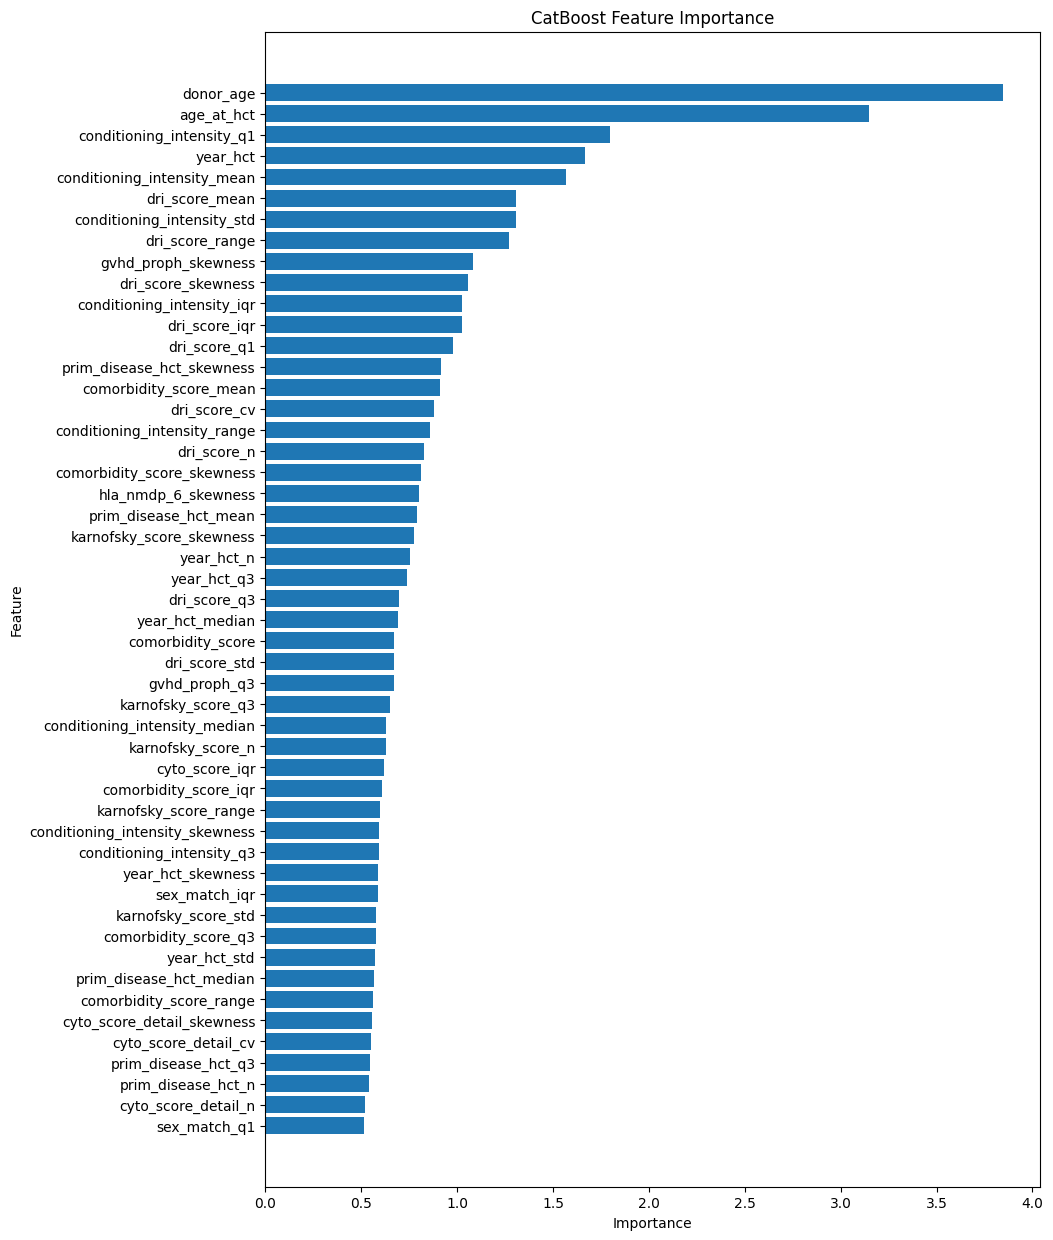

In [62]:
m_cat_kmf, oof_cat_kmf, pred_cat_kmf = train_cb(TRAIN_CB, FOLDS, SEED, 'kmf')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

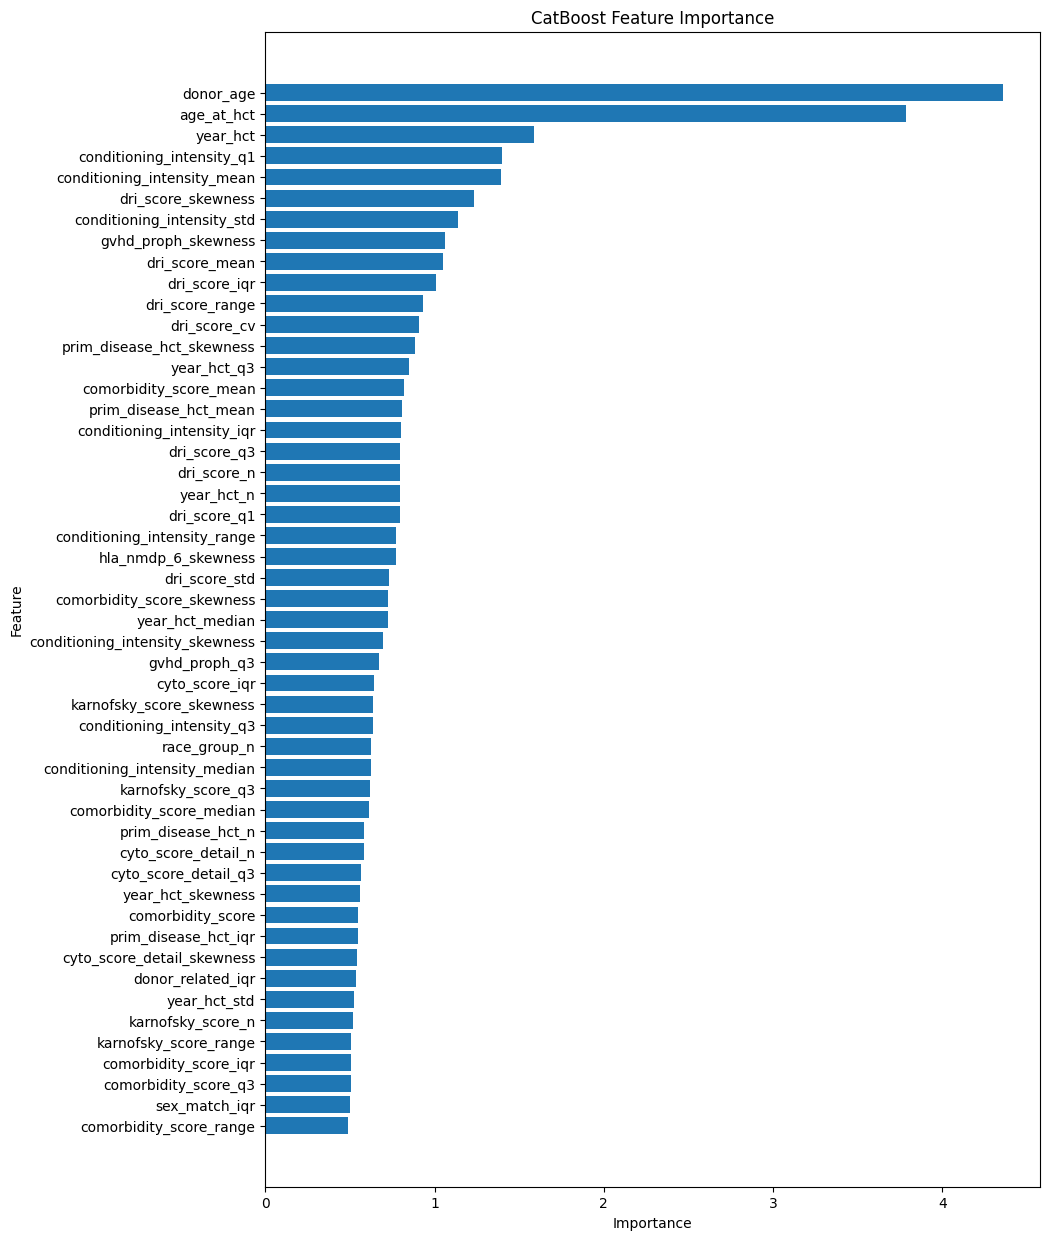

In [63]:
m_cat_naf, oof_cat_naf, pred_cat_naf = train_cb(TRAIN_CB, FOLDS, SEED, 'naf')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

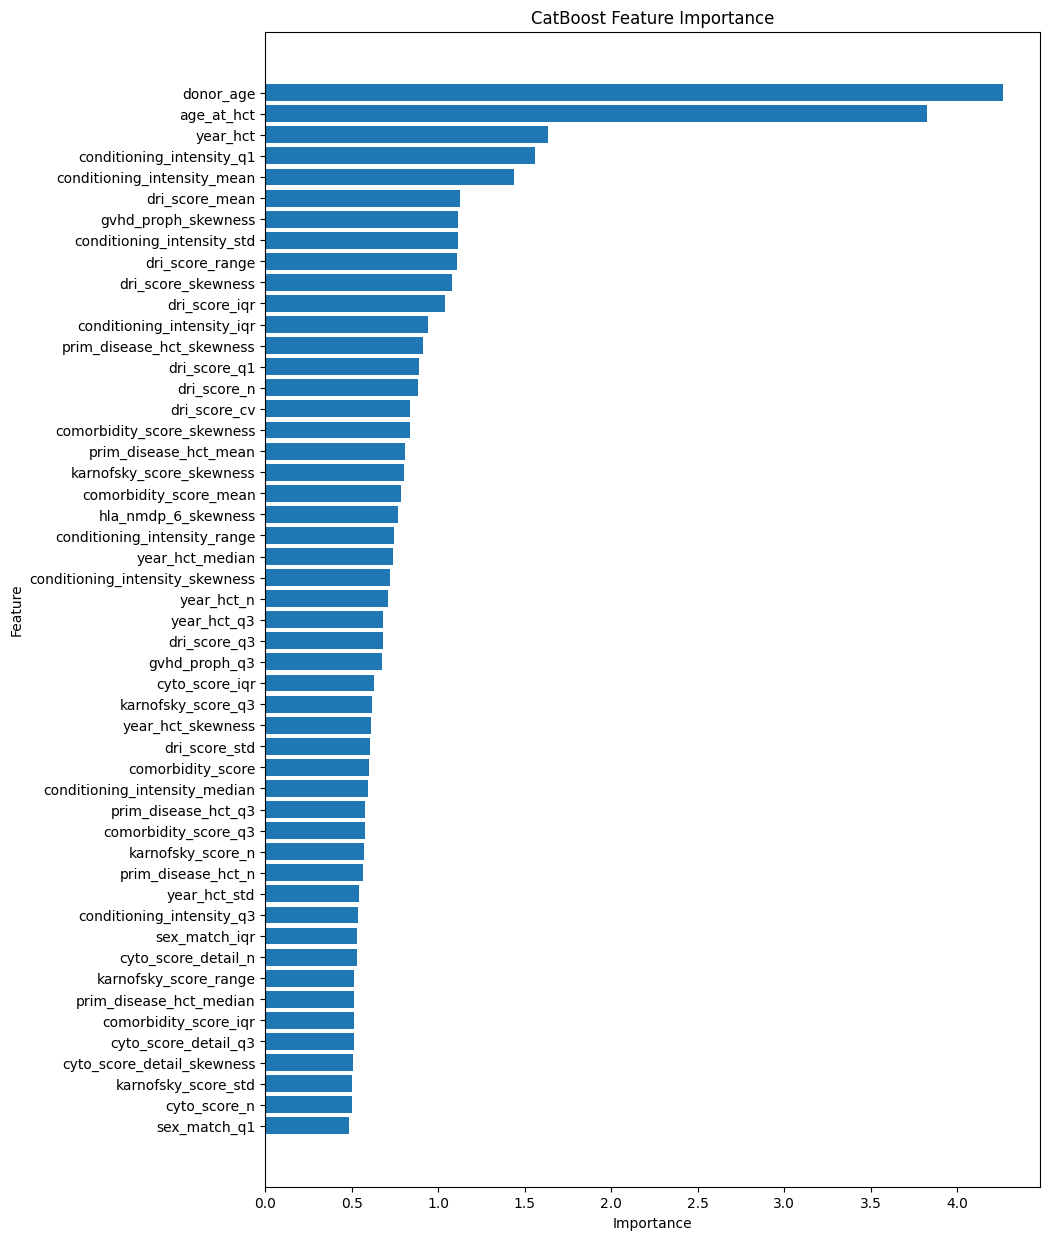

In [64]:
m_cat_bfhf, oof_cat_bfhf, pred_cat_bfhf = train_cb(TRAIN_CB, FOLDS, SEED, 'bfhf')

In [65]:
def train_xgb(train_flag, folds, seed, target):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        
    oof_xgb = np.zeros(len(train))
    pred_xgb = np.zeros(len(test))

    xgb_params = {
        'n_estimators': 10000,
        'early_stopping_rounds': 200,
        'random_state': seed,
        'learning_rate': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'hist',
        'eval_metric': 'rmse'
    }
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        print('\n' + '#' * 100)
        print(f'#### Fold {i + 1}')
        print('#' * 100 + '\n')
        
        X_train = train.loc[train_index, ALL].copy()
        y_train = train.loc[train_index, target]
        X_valid = train.loc[test_index, ALL].copy()
        y_valid = train.loc[test_index, target]
        X_test = test[ALL].copy()

        if train_flag:
            model_xgb = XGBRegressor(**xgb_params)
            model_xgb.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                verbose=100
            )
            os.makedirs(f'/kaggle/working/xgb_models_{target}', exist_ok=True)
            joblib.dump(model_xgb, f'/kaggle/working/xgb_models_{target}/xgb_model_{target}_fold_{i}.pkl')
        else:
            model_xgb = joblib.load(os.path.join(XGB_PATHS[target], f'xgb_model_{target}_fold_{i}.pkl'))

        oof_xgb[test_index] = model_xgb.predict(X_valid)
        pred_xgb += model_xgb.predict(X_test)
    
    pred_xgb /= FOLDS

    y_true = train[['ID', 'efs', 'efs_time', 'race_group']].copy()
    y_pred = train[['ID']].copy()
    y_pred['prediction'] = oof_xgb
    m_xgb = score(y_true.copy(), y_pred.copy(), 'ID')
    print(f'\nOverall CV for XGB w/ target {target} =', m_xgb) 

    return m_xgb, oof_xgb, pred_xgb

In [66]:
TRAIN_XGB = False

In [67]:
m_xgb_kmf, oof_xgb_kmf, pred_xgb_kmf = train_xgb(TRAIN_XGB, FOLDS, SEED, 'kmf')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

In [68]:
m_xgb_naf, oof_xgb_naf, pred_xgb_naf = train_xgb(TRAIN_XGB, FOLDS, SEED, 'naf')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

In [69]:
m_xgb_bfhf, oof_xgb_bfhf, pred_xgb_bfhf = train_xgb(TRAIN_XGB, FOLDS, SEED, 'bfhf')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

In [70]:
def train_lgb(train_flag, folds, seed, target):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        
    oof_lgb = np.zeros(len(train))
    pred_lgb = np.zeros(len(test))
    
    lgb_params = {
        'n_estimators': 10000,
        'random_state': seed,
        'learning_rate': 0.01,
        'max_depth': 4,
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'reg_alpha': 0.2,
        'reg_lambda': 5,
        'extra_trees': True,
        'metric': 'rmse',
        'verbose': -1
    }
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=100)
    ]
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        print('\n' + '#' * 100)
        print(f'#### Fold {i + 1}')
        print('#' * 100 + '\n')
        
        X_train = train.loc[train_index, ALL].copy()
        y_train = train.loc[train_index, target]
        X_valid = train.loc[test_index, ALL].copy()
        y_valid = train.loc[test_index, target]
        X_test = test[ALL].copy()
        
        if train_flag:
            model_lgb = lgb.LGBMRegressor(**lgb_params)
            model_lgb.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                callbacks=callbacks
            )
            os.makedirs(f'/kaggle/working/lgb_models_{target}', exist_ok=True)
            joblib.dump(model_lgb, f'/kaggle/working/lgb_models_{target}/lgb_model_{target}_fold_{i}.pkl')
        else:
            model_lgb = joblib.load(os.path.join(LGB_PATHS[target], f'lgb_model_{target}_fold_{i}.pkl'))
        
        oof_lgb[test_index] = model_lgb.predict(X_valid)
        pred_lgb += model_lgb.predict(X_test)
    
    pred_lgb /= FOLDS
    
    y_true = train[['ID', 'efs', 'efs_time', 'race_group']].copy()
    y_pred = train[['ID']].copy()
    y_pred['prediction'] = oof_lgb
    m_lgb = score(y_true.copy(), y_pred.copy(), 'ID')
    print(f'\nOverall CV for LGB w/ target {target} =', m_lgb)
    
    return m_lgb, oof_lgb, pred_lgb

In [71]:
TRAIN_LGB = False

In [72]:
m_lgb_kmf, oof_lgb_kmf, pred_lgb_kmf = train_lgb(TRAIN_LGB, FOLDS, SEED, 'kmf')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

In [73]:
m_lgb_naf, oof_lgb_naf, pred_lgb_naf = train_lgb(TRAIN_LGB, FOLDS, SEED, 'naf')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

In [74]:
m_lgb_bfhf, oof_lgb_bfhf, pred_lgb_bfhf = train_lgb(TRAIN_LGB, FOLDS, SEED, 'bfhf')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

In [75]:
def train_cb_cox(train_flag, folds, seed, target):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        
    oof_cat = np.zeros(len(train))
    pred_cat = np.zeros(len(test))

    cb_params = {
        'iterations': 10000,
        'early_stopping_rounds': 200,
        'loss_function': 'Cox',
        'random_state': seed
    }
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        print('\n' + '#' * 100)
        print(f'#### Fold {i + 1}')
        print('#' * 100 + '\n')
        
        X_train = train.loc[train_index, ALL].copy()
        y_train = train.loc[train_index, target]
        X_valid = train.loc[test_index, ALL].copy()
        y_valid = train.loc[test_index, target]
        X_test = test[ALL].copy()

        if train_flag:
            model_cat = CatBoostRegressor(**cb_params)
            model_cat.fit(
                X_train,
                y_train,
                eval_set=(X_valid, y_valid),
                #cat_features=CAT_FEATURES,
                verbose=100
            )
            os.makedirs(f'/kaggle/working/cat_models_{target}', exist_ok=True)
            joblib.dump(model_cat, f'/kaggle/working/cat_models_{target}/cat_model_{target}_fold_{i}.pkl')
        else:
            model_cat = joblib.load(os.path.join(CAT_PATHS[target], f'cat_model_{target}_fold_{i}.pkl'))

        oof_cat[test_index] = model_cat.predict(X_valid)
        pred_cat += model_cat.predict(X_test)
    
    pred_cat /= FOLDS

    y_true = train[['ID', 'efs', 'efs_time', 'race_group']].copy()
    y_pred = train[['ID']].copy()
    y_pred['prediction'] = oof_cat
    m_cat = score(y_true.copy(), y_pred.copy(), 'ID')
    print(f'\nOverall CV for CB w/ target {target} =', m_cat) 

    plot_cb_imp(model_cat)

    return m_cat, oof_cat, pred_cat


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

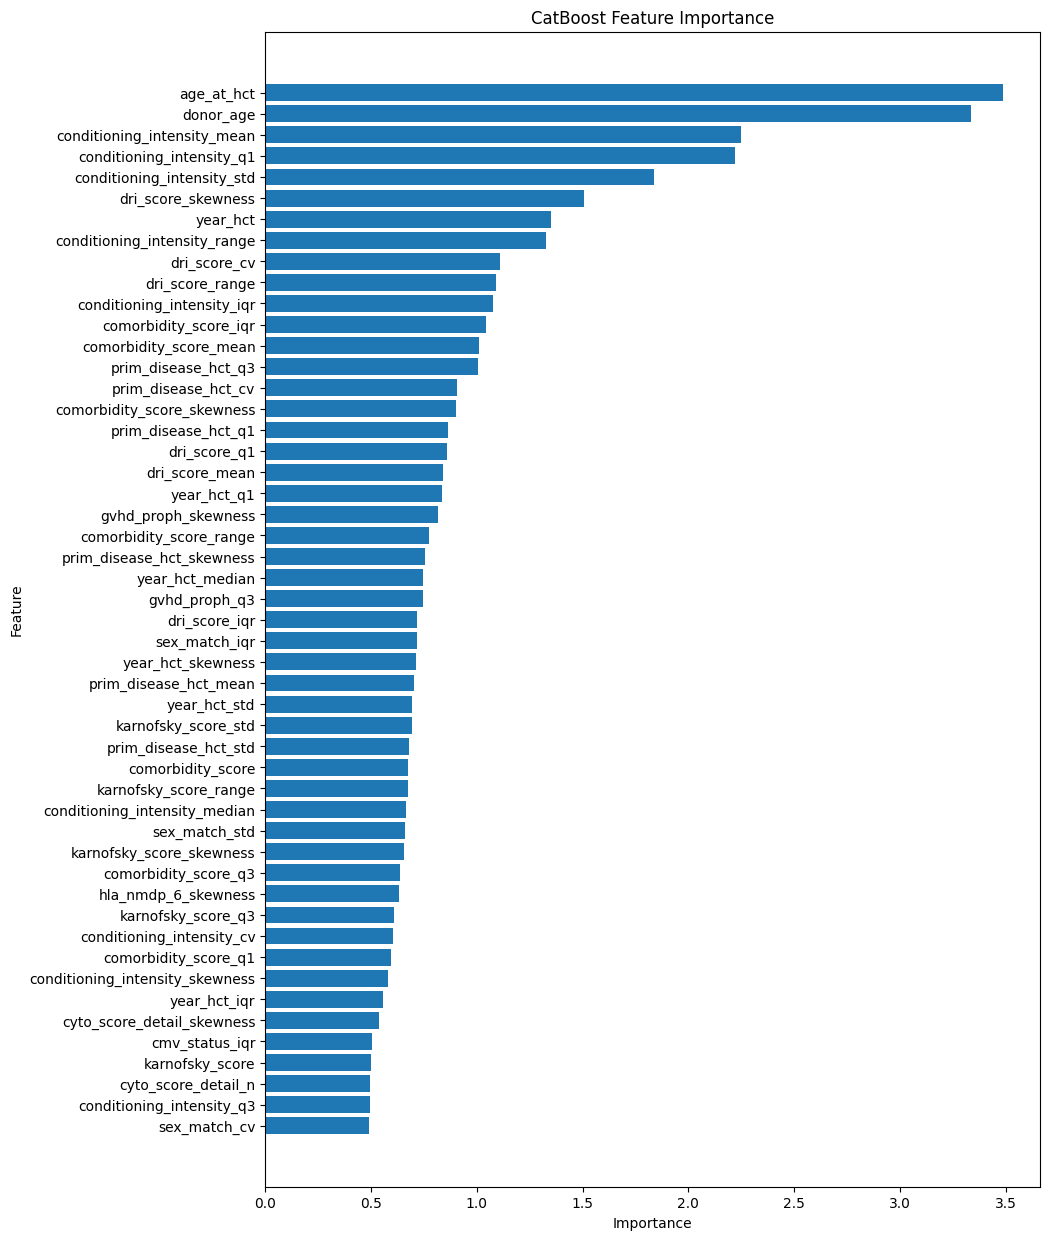

In [76]:
m_cat_cox228, oof_cat_cox228, pred_cat_cox228 = train_cb_cox(TRAIN_CB, FOLDS, SEED, 'cox')

In [77]:
def train_xgb_cox(train_flag, folds, seed, target):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        
    oof_xgb = np.zeros(len(train))
    pred_xgb = np.zeros(len(test))

    xgb_params = {
        'n_estimators': 10000,
        'early_stopping_rounds': 200,
        'random_state': seed,
        'learning_rate': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'hist',
        'objective': 'survival:cox',
        'eval_metric': 'cox-nloglik',
    }
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        print('\n' + '#' * 100)
        print(f'#### Fold {i + 1}')
        print('#' * 100 + '\n')
        
        X_train = train.loc[train_index, ALL].copy()
        y_train = train.loc[train_index, target]
        X_valid = train.loc[test_index, ALL].copy()
        y_valid = train.loc[test_index, target]
        X_test = test[ALL].copy()

        if train_flag:
            model_xgb = XGBRegressor(**xgb_params)
            model_xgb.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                verbose=100
            )
            os.makedirs(f'/kaggle/working/xgb_models_{target}', exist_ok=True)
            joblib.dump(model_xgb, f'/kaggle/working/xgb_models_{target}/xgb_model_{target}_fold_{i}.pkl')
        else:
            model_xgb = joblib.load(os.path.join(XGB_PATHS[target], f'xgb_model_{target}_fold_{i}.pkl'))

        oof_xgb[test_index] = model_xgb.predict(X_valid)
        pred_xgb += model_xgb.predict(X_test)
    
    pred_xgb /= FOLDS

    y_true = train[['ID', 'efs', 'efs_time', 'race_group']].copy()
    y_pred = train[['ID']].copy()
    y_pred['prediction'] = oof_xgb
    m_xgb = score(y_true.copy(), y_pred.copy(), 'ID')
    print(f'\nOverall CV for XGB w/ target {target} =', m_xgb) 

    return m_xgb, oof_xgb, pred_xgb

In [78]:
m_xgb_cox228, oof_xgb_cox228, pred_xgb_cox228 = train_xgb_cox(TRAIN_XGB, FOLDS, SEED, 'cox')


####################################################################################################
#### Fold 1
####################################################################################################


####################################################################################################
#### Fold 2
####################################################################################################


####################################################################################################
#### Fold 3
####################################################################################################


####################################################################################################
#### Fold 4
####################################################################################################


####################################################################################################
#### Fold 5
######################

# chris deotte nn

In [79]:
# import numpy as np, pandas as pd
# import matplotlib.pyplot as plt
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 500)

# test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
# print("Test shape:", test.shape )

# train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
# print("Train shape:",train.shape)
# train.head()

In [80]:
# train["y"] = train.efs_time.values
# mx = train.loc[train.efs==1,"efs_time"].max()
# mn = train.loc[train.efs==0,"efs_time"].min()
# train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
# train.y = train.y.rank()
# train.loc[train.efs==0,"y"] += 2*len(train)
# train.y = train.y / train.y.max()
# train.y = np.log( train.y )
# train.y -= train.y.mean()
# train.y *= -1.0

In [81]:
# RMV = ["ID","efs","efs_time","y"]
# FEATURES = [c for c in train.columns if not c in RMV]
# print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

In [82]:
# CATS = []
# for c in FEATURES:
#     if train[c].dtype=="object":
#         train[c] = train[c].fillna("NAN")
#         test[c] = test[c].fillna("NAN")
#         CATS.append(c)
#     elif not "age" in c:
#         train[c] = train[c].astype("str")
#         test[c] = test[c].astype("str")
#         CATS.append(c)
# print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In [83]:
# CAT_SIZE = []
# CAT_EMB = []
# NUMS = []

# combined = pd.concat([train,test],axis=0,ignore_index=True)
# #print("Combined data shape:", combined.shape )

# print("We LABEL ENCODE the CATEGORICAL FEATURES: ")

# for c in FEATURES:
#     if c in CATS:
#         # LABEL ENCODE
#         combined[c],_ = combined[c].factorize()
#         combined[c] -= combined[c].min()
#         combined[c] = combined[c].astype("int32")
#         #combined[c] = combined[c].astype("category")

#         n = combined[c].nunique()
#         mn = combined[c].min()
#         mx = combined[c].max()
#         print(f'{c} has ({n}) unique values')

#         CAT_SIZE.append(mx+1) 
#         CAT_EMB.append( int(np.ceil( np.sqrt(mx+1))) ) 
#     else:
#         if combined[c].dtype=="float64":
#             combined[c] = combined[c].astype("float32")
#         if combined[c].dtype=="int64":
#             combined[c] = combined[c].astype("int32")
            
#         m = combined[c].mean()
#         s = combined[c].std()
#         combined[c] = (combined[c]-m)/s
#         combined[c] = combined[c].fillna(0)
        
#         NUMS.append(c)
        
# train = combined.iloc[:len(train)].copy()
# test = combined.iloc[len(train):].reset_index(drop=True).copy()

In [84]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, Input, Embedding
# from tensorflow.keras.layers import Concatenate, BatchNormalization
# import tensorflow.keras.backend as K
# from sklearn.model_selection import KFold

# print('TF Version',tf.__version__)

In [85]:
# EPOCHS = 4
# LRS = [0.01]*2 + [0.001]*1 + [0.0001]*1

# def lrfn(epoch):
#     return LRS[epoch]

# rng = [i for i in range(EPOCHS)]
# lr_y = [lrfn(x) for x in rng]
# plt.figure(figsize=(10, 4))
# plt.plot(rng, lr_y, '-o')
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
#         format(lr_y[0], max(lr_y), lr_y[-1]))
# plt.xlabel("Epoch")
# plt.ylabel("Learning Rate")
# plt.title("Learning Rate Schedule")
# plt.show()

# lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)

In [86]:
# def build_model():
    
#     # CATEGORICAL FEATURES
#     x_input_cats = Input(shape=(len(CATS),))
#     embs = []
#     for j in range(len(CATS)):
#         e = tf.keras.layers.Embedding(CAT_SIZE[j],CAT_EMB[j])
#         x = e(x_input_cats[:,j])
#         x = tf.keras.layers.Flatten()(x)
#         embs.append(x)
        
#     # NUMERICAL FEATURES
#     x_input_nums = Input(shape=(len(NUMS),))
    
#     # COMBINE
#     x = tf.keras.layers.Concatenate(axis=-1)(embs+[x_input_nums]) 
#     x = Dense(256, activation='relu')(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dense(1, activation='linear')(x)
    
#     model = Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    
#     return model

In [87]:
# %%time

# REPEATS = 3
# FOLDS = 10
# kf = KFold(n_splits=FOLDS, random_state=52, shuffle=True)

# oof_nn = np.zeros( len(train) )
# pred_nn = np.zeros( len(test) )

# #directory = "checkpoints"
# #if not os.path.exists(directory):
# #    os.makedirs(directory)

# for r in range(REPEATS):
#     VERBOSE = r==0
#     print("#"*25)
#     print(f"### REPEAT {r+1} ###")
#     print("#"*25)
        
#     for i, (train_index, test_index) in enumerate(kf.split(train)):
        
#         X_train_cats = train.loc[train_index,CATS].values
#         X_train_nums = train.loc[train_index,NUMS].values
#         y_train = train.loc[train_index,"y"].values
#         y_train2 = train.loc[train_index,"efs"].values
        
#         X_valid_cats = train.loc[test_index,CATS].values
#         X_valid_nums = train.loc[test_index,NUMS].values
#         y_valid = train.loc[test_index,"y"].values
#         y_valid2 = train.loc[test_index,"efs"].values
        
#         X_test_cats = test[CATS].values
#         X_test_nums = test[NUMS].values

#         if VERBOSE:
#             print(" ","#"*25)
#             print(" ",f"### Fold {i+1} ###")
#             print(" ","#"*25)
        
#         # TRAIN MODEL
#         K.clear_session()
#         model = build_model()
#         model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
#                       loss="mean_squared_error",  
#                      )
#         v = 2 if VERBOSE else 0
#         model.fit([X_train_cats,X_train_nums], [y_train], 
#                   validation_data = ([X_valid_cats,X_valid_nums], [y_valid]),
#                   callbacks = [lr_callback],
#                   batch_size=512, epochs=EPOCHS, verbose=v)
#         #model.save_weights(f'{directory}/NN_f{i}_r{r}.weights.h5')
        
#         # INFER OOF
#         oof_nn[test_index] += model.predict([X_valid_cats,X_valid_nums], verbose=v, batch_size=512).flatten()
#         # INFER TEST
#         pred_nn += model.predict([X_test_cats,X_test_nums], verbose=v, batch_size=512).flatten()

# oof_nn /= REPEATS
# pred_nn /= (FOLDS*REPEATS)

In [88]:
# from metric import score

# y_true = train[["ID","efs","efs_time","race_group"]].copy()
# y_pred = train[["ID"]].copy()
# y_pred["prediction"] = oof_nn
# m = score(y_true.copy(), y_pred.copy(), "ID")
# print(f"\nOverall CV for NN =",m)

# deeptables

In [89]:
# !pip install --no-index -U --find-links=/kaggle/input/tensorflow-2-15/tensorflow tensorflow==2.15.0
# !pip install --no-index -U --find-links=/kaggle/input/deeptables-v0-2-5/deeptables-0.2.5 deeptables==0.2.5
# !pip install --no-index -U --find-links=/kaggle/input/fix-deeptables/deeptables-0.2.6 deeptables==0.2.6

In [90]:
# import os
# import math
# import random
# import warnings
# import matplotlib.pyplot as plt
# import numpy as np, pandas as pd
# from colorama import Fore, Style
# from numpy.typing import ArrayLike
# from sklearn.base import BaseEstimator
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import MinMaxScaler

# import tensorflow as tf, deeptables as dt
# from tensorflow.keras import backend as K
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.optimizers.legacy import Adam
# from deeptables.models import DeepTable, ModelConfig, deepnets

# from metric import score

# warnings.filterwarnings("ignore")
# print('TensorFlow version:',tf.__version__+',',
#       'GPU =',tf.test.is_gpu_available())
# print('DeepTables version:',dt.__version__)

In [91]:
# def seed_everything(seed):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     random.seed(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
# seed_everything(seed=52)

In [92]:
# train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
# test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
# print("Train shape:", train.shape)
# print("Test shape:", test.shape )

In [93]:
# train["y"] = train.efs_time.values
# mx = train.loc[train.efs==1,"efs_time"].max()
# mn = train.loc[train.efs==0,"efs_time"].min()
# train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
# train.y = train.y.rank()
# train.loc[train.efs==0,"y"] += 2*len(train)
# train.y = train.y / train.y.max()
# train.y = np.log( train.y )
# train.y -= train.y.mean()
# train.y *= -1.0

# # def create_fold_specific_target(data, time_col='efs_time', event_col='efs', group_col='race_group'):
# #     cv = KFold(n_splits=10, shuffle=True, random_state=52)
# #     target = np.zeros(len(data))

# #     for train_index, valid_index in cv.split(data):
# #         train_data = data.iloc[train_index]
# #         valid_data = data.iloc[valid_index]

# #         kmf = KaplanMeierFitter()
# #         kmf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
# #         target[valid_index] = kmf.survival_function_at_times(valid_data[time_col]).values
        
# #     data['y'] = target
    
# #     return data

# # def create_fold_specific_target(data, time_col='efs_time', event_col='efs', group_col='race_group'):
# #     cv = KFold(n_splits=10, shuffle=True, random_state=52)
# #     target = np.zeros(len(data))

# #     for train_index, valid_index in cv.split(data):
# #         train_data = data.iloc[train_index]
# #         valid_data = data.iloc[valid_index]

# #         naf = NelsonAalenFitter()
# #         naf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
# #         target[valid_index] = -naf.cumulative_hazard_at_times(valid_data[time_col]).values
        
# #     data['y'] = target
    
# #     return data
    
# # train = create_fold_specific_target(train, time_col='efs_time', event_col='efs', group_col='race_group')

In [94]:
# RMV = ['ID','efs','efs_time','y']
# X = train.drop(RMV, axis=1)
# y = train.y
# y_true = train[RMV + ['race_group']]
# y_pred = train[['ID']]
# X_test = test.drop(['ID'], axis=1)
# print("X  shape:", X.shape)
# print("X_test shape:", X_test.shape, '\n')

# cat_cols = X.select_dtypes(include=['object']).columns.tolist()
# num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
# print("len(cat_cols):", len(cat_cols))
# print("len(num_cols):", len(num_cols))

# # Preprocessing numerical
# imputer = SimpleImputer(strategy="median")
# X[num_cols] = imputer.fit_transform(X[num_cols])
# X_test[num_cols] = imputer.transform(X_test[num_cols])
# scaler = MinMaxScaler()
# X[num_cols] = scaler.fit_transform(X[num_cols])
# X_test[num_cols] = scaler.transform(X_test[num_cols])

In [95]:
# # https://www.kaggle.com/code/cdeotte/tensorflow-transformer-0-790/notebook
# LR_START = 1e-3
# LR_MAX = 1e-2
# LR_MIN = 1e-4
# LR_RAMPUP_EPOCHS = 0
# LR_SUSTAIN_EPOCHS = 0
# EPOCHS = 25

# def lrfn(epoch):
#     if epoch < LR_RAMPUP_EPOCHS:
#         lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
#     elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
#         lr = LR_MAX
#     else:
#         decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
#         decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
#         phase = math.pi * decay_epoch_index / decay_total_epochs
#         cosine_decay = 0.5 * (1 + math.cos(phase))
#         lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN    
#     return lr

# rng = [i for i in range(EPOCHS)]
# lr_y = [lrfn(x) for x in rng]
# plt.figure(figsize=(10, 4))
# plt.plot(rng, lr_y, '-o')
# plt.xlabel('Epoch'); plt.ylabel('LR')
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
#       format(lr_y[0], max(lr_y), lr_y[-1]))
# LR_Scheduler = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [96]:
# class CFG:
#     TRAIN_ = TRAIN
#     folds = 10
#     epochs = 25
#     batch_size = 128
#     LR_Scheduler = [LR_Scheduler]
#     optimizer = Adam(learning_rate=1e-3)
    
#     conf = ModelConfig(auto_imputation=True,
#                        auto_categorize=True,
#                        cat_remain_numeric=True,
#                        fixed_embedding_dim=True,
#                        embeddings_output_dim=4,
#                        embedding_dropout=0.3,
#                        nets=['dnn_nets'], #cin_nets, autoint_nets
#                        dnn_params={
#                            'hidden_units': ((128, 0.3, True),
#                                             (64, 0.3, True)),
#                            'dnn_activation': 'relu',
#                            },
#                        stacking_op='concat',
#                        output_use_bias=False,
#                        optimizer=optimizer,
#                        task='regression',
#                        loss='auto',
#                        metrics=["RootMeanSquaredError"],
#                        earlystopping_patience=2,
#                        )

In [97]:
import os
import shutil

In [98]:
# %%time
# def train_model(X, y, y_true, y_pred):
#     print("Data shape:", X.shape,"\n")
#     kf = KFold(n_splits=CFG.folds, shuffle=True, random_state=42)
#     oof = np.zeros(len(X))
#     models = []
#     for fi, (train_idx, valid_idx) in enumerate(kf.split(X)):
#         print("#"*25)
#         print(f"### Fold {fi+1}/{CFG.folds} ...")
#         print("#"*25)

#         K.clear_session()
#         model = DeepTable(config=CFG.conf)
#         model.fit(X.iloc[train_idx], y.iloc[train_idx],
#                   validation_data=(X.iloc[valid_idx], y.iloc[valid_idx]),
#                   callbacks=CFG.LR_Scheduler,
#                   batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2)
#         models.append(model)

#         # Save model
#         os.makedirs(f"/kaggle/working/models/fold{fi}", exist_ok=True)
#         os.makedirs(f"/tmp/workdir/kaggle/working/models/fold{fi}", exist_ok=True)
#         model.save(f'/kaggle/working/models/fold{fi}')
#         os.system(f'cp -r /kaggle/working/models/fold{fi}/* /tmp/workdir/kaggle/working/models/fold{fi}/')
#         # Avoid some errors
#         with K.name_scope(CFG.optimizer.__class__.__name__):
#             for j, var in enumerate(CFG.optimizer.weights):
#                 name = 'variable{}'.format(j)
#                 CFG.optimizer.weights[j] = tf.Variable(var, name=name)
#         CFG.conf = CFG.conf._replace(optimizer=CFG.optimizer)

#         oof_pred = model.predict(X.iloc[valid_idx], verbose=1, batch_size=512).flatten()
#         y_pred.loc[valid_idx,'prediction'] = oof_pred
#         m = score(y_true.iloc[valid_idx].copy(), y_pred.copy(), 'ID')
#         print(f'{Fore.GREEN}{Style.BRIGHT}\nFold {fi+1} | score: {m:.4f}\n')
#         oof[valid_idx] = oof_pred
#     m_all = score(y_true.copy(), y_pred.copy(), 'ID')
#     print(f'{Fore.BLUE}{Style.BRIGHT}Overall CV score: {m_all:.4f}\n')
#     display(plot_model(model.get_model().model))
#     return models, oof

# if CFG.TRAIN_==True:
#     models, oof_nn_2 = train_model(X, y, y_true, y_pred)
#     os.makedirs('/kaggle/working/models', exist_ok=True)
#     joblib.dump(oof_nn_2, '/kaggle/working/models/oof_nn_2.pkl')
# else:
#     for fi in range(10):
#         source_dir = f"/kaggle/input/cibmtr-models/models/fold{fi}"
#         destination_dir = f"/kaggle/working/models/fold{fi}"
#         os.makedirs(destination_dir, exist_ok=True)
#         for item in os.listdir(source_dir):
#             source_path = os.path.join(source_dir, item)
#             destination_path = os.path.join(destination_dir, item)
#             shutil.copy2(source_path, destination_path)
    
#     oof_nn_2 = joblib.load(os.path.join(DEEPTABLES_PATH, 'oof_nn_2.pkl'))
    
#     for fi in range(10):
#         os.makedirs(f"/tmp/workdir/kaggle/working/models/fold{fi}", exist_ok=True)
#         os.system(f'cp -r /kaggle/working/models/fold{fi}/* /tmp/workdir/kaggle/working/models/fold{fi}/')

In [99]:
# y_true = train[["ID","efs","efs_time","race_group"]].copy()
# y_pred = train[["ID"]].copy()
# y_pred["prediction"] = oof_nn_2
# m_nn_2 = score(y_true.copy(), y_pred.copy(), "ID")
# print(f"\nOverall CV for DeepTables =",m_nn_2)

In [100]:
# # Load models
# def load_model(paths):
#     models = []
#     for fold in sorted(os.listdir(paths)):
#         path = os.path.join(paths, fold)
#         for file in os.listdir(path):
#             if file.endswith('.h5'):
#                 models.append(DeepTable.load(path, file))
#     return models

# path_ = "/kaggle/working/models"
# models = load_model(path_)
# print('\nmodels:', models)

In [101]:
# # Inference
# class AvgModel:
#     def __init__(self, models: list[BaseEstimator]):
#         self.models = models
#     def predict(self, X: ArrayLike):
#         preds = []
#         for model in self.models:
#             pred = model.predict(X, verbose=1, batch_size=512).flatten()
#             preds.append(pred)
#         return np.mean(preds, axis=0)

# avg_model = AvgModel(models)
# pred_nn_2 = avg_model.predict(X_test)

# adb catboost

In [102]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import polars as pl
import pandas as pd

from sklearn.base import clone
import optuna
import os
from colorama import Fore

from tqdm import tqdm
from IPython.display import clear_output
from lifelines import KaplanMeierFitter
pd.options.display.max_columns = None
from lifelines.utils import concordance_index


import lightgbm as lgb
from lightgbm import early_stopping  
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 114514
n_splits = 10

In [103]:
%%time

sp = '/kaggle/input/abdbase/AbdML/main.py'
tp = '/kaggle/working/main.py'

with open(sp, 'r', encoding='utf-8') as file:
    content = file.read()
with open(tp, 'w', encoding='utf-8') as file:
    file.write(content)

from main import AbdBase

train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
sample = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
train_solution = train[['ID','efs','efs_time','race_group']].copy()

cat_c = ['dri_score','psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist',
 'renal_issue','pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type',
 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match',
 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group',
 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac','pulm_moderate']

def update(df):
    
    global cat_c

    for c in cat_c:
        df[c] = df[c].fillna('None').astype('category')

    j_ch=',[]{}:"\\<'
    for ch in j_ch:
        for c in cat_c:
            df[c] = df[c].apply(lambda x:str(x).replace(ch,''))
                
    return df

train = update(train)
test = update(test)

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):

    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities

def update_target_with_survival_probabilities(df, time_col='efs_time', event_col='efs'):

    race_group = sorted(df['race_group'].unique())
    survival_probs_dict = {}
    for race in race_group:
        race_df = df[df['race_group'] == race]
        survival_probs_dict[race] = transform_survival_probability(race_df, time_col, event_col)
    for race in race_group:
        df.loc[df['race_group'] == race, 'target'] = survival_probs_dict[race]
    df.loc[df[event_col] == 0, 'target'] -= 0.15
    
    return df

train = update_target_with_survival_probabilities(train, time_col='efs_time', event_col='efs')

f_fe = [
    'year_hct', 'dri_score_High', 'comorbidity_score', 'conditioning_intensity_None', 
    'karnofsky_score', 'donor_age', 'age_at_hct', 'mrd_hct_None', 
    'cyto_score_detail_Poor', 'dri_score_Intermediate', 'conditioning_intensity_RIC', 
    'cyto_score_Poor', 'hla_match_a_high', 'prim_disease_hct_ALL', 
    'gvhd_proph_FK+ MMF +- others', 
    'dri_score_High - TED AML case missing cytogenetics', 'sex_match_F-M', 
    'pulm_severe_Yes', 'cmv_status_-/+', 'hla_nmdp_6', 'cardiac_Yes', 
    'race_group_Black or African-American', 'sex_match_M-M', 'prim_disease_hct_AML', 
    'mrd_hct_Negative', 'donor_related_Related', 'hla_match_a_low', 
    'cyto_score_detail_None', 'cyto_score_Favorable', 'sex_match_M-F', 
    'arrhythmia_No', 'prior_tumor_No', 'in_vivo_tcd_Yes', 
    'race_group_More than one race', 'sex_match_F-F', 'hla_match_drb1_high', 
    'donor_related_Unrelated', 'tbi_status_No TBI', 'cyto_score_detail_Favorable', 
    'pulm_severe_No', 'tce_imm_match_None', 'mrd_hct_Positive', 
    'prim_disease_hct_MDS', 'diabetes_Yes', 'cmv_status_+/-', 
    'gvhd_proph_FKalone', 'prior_tumor_Not done', 'melphalan_dose_MEL', 
    'diabetes_No', 'arrhythmia_None', 'gvhd_proph_Cyclophosphamide +- others', 
    'hla_low_res_8', 'gvhd_proph_CSA + MMF +- others(not FK)', 'hepatic_severe_No', 
    'hla_low_res_6', 'graft_type_Bone marrow', 'cmv_status_+/+', 
    'prim_disease_hct_IEA', 'hla_match_dqb1_high', 'hla_match_dqb1_low', 
    'hla_match_b_low', 'dri_score_N/A - pediatric', 'dri_score_TBD cytogenetics', 
    'conditioning_intensity_MAC', 'obesity_No', 'tce_match_None', 
    'in_vivo_tcd_None', 'race_group_White', 'tce_div_match_None', 
    'hla_high_res_10', 'prod_type_BM', 'prim_disease_hct_IIS', 
    'hla_match_c_high', 'hla_match_c_low', 'prod_type_PB', 'hla_low_res_10', 
    'cyto_score_None', 'cmv_status_-/-', 'prior_tumor_Yes', 
    'conditioning_intensity_NMA', 'arrhythmia_Not done', 'cardiac_None', 
    'tce_imm_match_G/G', 'prim_disease_hct_NHL', 'cyto_score_detail_Not tested', 
    'dri_score_Low', 'ethnicity_Not Hispanic or Latino', 'hla_match_b_high', 
    'race_group_Asian', 'melphalan_dose_N/A Mel not given', 'hepatic_mild_None', 
    'psych_disturb_No', 'tbi_status_TBI +- Other =cGy', 
    'cyto_score_detail_Intermediate', 'in_vivo_tcd_No', 'conditioning_intensity_TBD', 
    'hla_match_drb1_low', 'graft_type_Peripheral blood', 'hla_high_res_8', 
    'hla_high_res_6', 'prim_disease_hct_HIS', 'cyto_score_Intermediate', 
    'cyto_score_TBD', 'donor_related_Multiple donor (non-UCB)', 
    'pulm_moderate_Yes', 'tce_imm_match_P/P', 'tbi_status_TBI +- Other >cGy', 
    'vent_hist_Yes', 'tbi_status_TBI + Cy +- Other', 'tce_div_match_HvG non-permissive', 
    'cyto_score_detail_TBD', 'gvhd_proph_Cyclophosphamide alone', 
    'tce_div_match_Permissive mismatched', 'obesity_None', 'tce_match_Permissive', 
    'pulm_severe_None', 'rheum_issue_Yes', 'tce_div_match_GvH non-permissive', 
    'cardiac_No', 'dri_score_Very high', 'diabetes_Not done', 'rituximab_None', 
    'tce_match_GvH non-permissive', 'tce_imm_match_H/H', 'gvhd_proph_None', 
    'prim_disease_hct_SAA', 'rituximab_No', 'vent_hist_No', 'hepatic_severe_Yes', 
    'tce_imm_match_G/B', 'pulm_moderate_No', 'vent_hist_None', 
    'gvhd_proph_TDEPLETION alone', 'dri_score_N/A - non-malignant indication', 
    'race_group_Native Hawaiian or other Pacific Islander', 'prim_disease_hct_PCD', 
    'rheum_issue_Not done', 'cyto_score_Other', 'dri_score_None', 'ethnicity_None', 
    'dri_score_Intermediate - TED AML case missing cytogenetics', 
    'cmv_status_None', 'melphalan_dose_None', 'gvhd_proph_FK+ MTX +- others(not MMF)', 
    'psych_disturb_Yes', 'ethnicity_Hispanic or Latino', 'pulm_severe_Not done', 
    'renal_issue_None', 'peptic_ulcer_No', 'donor_related_None', 
    'prim_disease_hct_AI', 'tbi_status_TBI +- Other -cGy unknown dose', 
    'hepatic_severe_Not done', 'peptic_ulcer_None', 
    'tce_div_match_Bi-directional non-permissive', 'renal_issue_No', 
    'arrhythmia_Yes', 'tce_match_Fully matched', 'pulm_moderate_None', 
    'rituximab_Yes'
]

def c_index_score(modeloff, model_name, weights=None):
    y_true = train_solution 
    y_pred = train_solution[["ID"]].copy()

    if isinstance(modeloff, (list, tuple, np.ndarray)) and all(isinstance(m, np.ndarray) for m in modeloff):
        if weights is None:
            weights = [1] * len(modeloff)
        
        assert len(modeloff) == len(weights), "The number of models must match the number of weights."
        
        combined_modeloff = sum(weight * model for weight, model in zip(weights, modeloff))
        y_pred["prediction"] = combined_modeloff
    else:
        y_pred["prediction"] = modeloff

    c_index = base.CIBMTR_score(y_true.copy(), y_pred.copy(), "ID")
    print(Fore.YELLOW + f"The Score of {model_name} is: {c_index:.4f}")
    
ohe_cols = {'cat_c': cat_c}

base = AbdBase(train_data=train, test_data=test, target_column='target',gpu=USE_GPU,
                 problem_type="regression", metric="mae", seed=SEED,ohe_fe=ohe_cols,
                 n_splits=10,early_stop=True,num_classes=0,cat_features=None,
                 fold_type='RKF')

base.X_train = base.X_train[f_fe]
base.X_test = base.X_test[f_fe]

def year_tf(df):
    df['cos_year'] = np.cos(df['year_hct'] * (2 * np.pi) / 100)
    df['sin_year'] = np.sin(df['year_hct'] * (2 * np.pi) / 100)
    return df
    
base.X_train = year_tf(base.X_train)
base.X_test = year_tf(base.X_test)

*** AbdBase ['V_1.3'] ***

 *** Available Settings *** 

Available Models: LGBM, CAT, XGB, Voting, TABNET, Ridge, LR
Available Metrics: roc_auc, accuracy, f1, precision, recall, rmse, wmae, rmsle, mae, r2, mse, mape, custom
Available Problem Types: classification, regression
Available Fold Types: SKF, KF, GKF, GSKF, RKF

 *** Configuration *** 

Problem Type Selected: REGRESSION
Metric Selected: MAE
Fold Type Selected: RKF
Calculate Train Probabilities: False
Calculate Test Probabilities: False
Early Stopping: True
GPU: False
Eval_Metric Selected is: None

---> Adding OHE Features

CPU times: user 1.24 s, sys: 40.9 ms, total: 1.28 s
Wall time: 1.29 s


In [104]:
CP = {'iterations': 3114, 'learning_rate': 0.020996758976627422, 'depth': 7, 'l2_leaf_reg': 1.213620321659482,
      'border_count': 153, 'bagging_temperature': 0.24943381016139077}

results_CAT = base.Train_ML(CP,'CAT',e_stop=100)  
oof_cat_adb = results_CAT[0]
c_index_score(oof_cat_adb, 'CAT_MODEL') # 0.6784

Training Folds: 100%|██████████| 10/10 [02:48<00:00, 16.84s/it]

Overall Train MAE: 0.1509
Overall OOF MAE: 0.1783 


The Score of CAT_MODEL is: 0.6789


In [105]:
pred_cat_adb = results_CAT[1]

In [106]:
y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = oof_cat_adb
m_cat_adb = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Cat ADB =",m_cat_adb)


Overall CV for Cat ADB = 0.6789266812736328


# adb catboost 2

In [107]:
CP_1 = {'iterations': 4491, 'learning_rate': 0.022249526148312184, 'depth': 5, 'eval_metric':'MAE',
      'l2_leaf_reg': 0.7357305158548999, 'border_count': 246, 'bagging_temperature': 0.6896908609682827}

results_CAT_1 = base.Train_ML(CP_1,'CAT',e_stop=200)
oof_cat_adb_1 = results_CAT_1[0]
c_index_score(oof_cat_adb_1, 'CAT_MODEL_1') #0.6780

Training Folds: 100%|██████████| 10/10 [03:50<00:00, 23.04s/it]

Overall Train MAE: 0.1495
Overall OOF MAE: 0.1773 


The Score of CAT_MODEL_1 is: 0.6780


In [108]:
pred_cat_adb_1 = results_CAT_1[1]

In [109]:
y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = oof_cat_adb_1
m_cat_adb_1 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Cat ADB 1 = ",m_cat_adb_1)


Overall CV for Cat ADB 1 =  0.6779920860690529


# adb catboost breslow

In [110]:
from lifelines import KaplanMeierFitter,BreslowFlemingHarringtonFitter,SplineFitter

In [111]:
%%time

sp = '/kaggle/input/abdbase/AbdML/main.py'
tp = '/kaggle/working/main.py'

with open(sp, 'r', encoding='utf-8') as file:
    content = file.read()
with open(tp, 'w', encoding='utf-8') as file:
    file.write(content)

from main import AbdBase

train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
sample = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
train_solution = train[['ID','efs','efs_time','race_group']].copy()

cat_c = ['dri_score','psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist',
 'renal_issue','pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type',
 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match',
 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group',
 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac','pulm_moderate']

def update(df):
    
    global cat_c

    for c in cat_c:
        df[c] = df[c].fillna('None').astype('category')

    j_ch=',[]{}:"\\<'
    for ch in j_ch:
        for c in cat_c:
            df[c] = df[c].apply(lambda x:str(x).replace(ch,''))
                
    return df

train = update(train)
test = update(test)

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = BreslowFlemingHarringtonFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities

def update_target_with_survival_probabilities(df, time_col='efs_time', event_col='efs'):

    race_group = sorted(df['race_group'].unique())
    survival_probs_dict = {}
    for race in race_group:
        race_df = df[df['race_group'] == race]
        survival_probs_dict[race] = transform_survival_probability(race_df, time_col, event_col)
    for race in race_group:
        df.loc[df['race_group'] == race, 'target'] = survival_probs_dict[race]
    df.loc[df[event_col] == 0, 'target'] -= 0.15
    
    return df

train = update_target_with_survival_probabilities(train, time_col='efs_time', event_col='efs')
train

f_fe = [
    'year_hct', 'dri_score_High', 'comorbidity_score', 'conditioning_intensity_None', 
    'karnofsky_score', 'donor_age', 'age_at_hct', 'mrd_hct_None', 
    'cyto_score_detail_Poor', 'dri_score_Intermediate', 'conditioning_intensity_RIC', 
    'cyto_score_Poor', 'hla_match_a_high', 'prim_disease_hct_ALL', 
    'gvhd_proph_FK+ MMF +- others', 
    'dri_score_High - TED AML case missing cytogenetics', 'sex_match_F-M', 
    'pulm_severe_Yes', 'cmv_status_-/+', 'hla_nmdp_6', 'cardiac_Yes', 
    'race_group_Black or African-American', 'sex_match_M-M', 'prim_disease_hct_AML', 
    'mrd_hct_Negative', 'donor_related_Related', 'hla_match_a_low', 
    'cyto_score_detail_None', 'cyto_score_Favorable', 'sex_match_M-F', 
    'arrhythmia_No', 'prior_tumor_No', 'in_vivo_tcd_Yes', 
    'race_group_More than one race', 'sex_match_F-F', 'hla_match_drb1_high', 
    'donor_related_Unrelated', 'tbi_status_No TBI', 'cyto_score_detail_Favorable', 
    'pulm_severe_No', 'tce_imm_match_None', 'mrd_hct_Positive', 
    'prim_disease_hct_MDS', 'diabetes_Yes', 'cmv_status_+/-', 
    'gvhd_proph_FKalone', 'prior_tumor_Not done', 'melphalan_dose_MEL', 
    'diabetes_No', 'arrhythmia_None', 'gvhd_proph_Cyclophosphamide +- others', 
    'hla_low_res_8', 'gvhd_proph_CSA + MMF +- others(not FK)', 'hepatic_severe_No', 
    'hla_low_res_6', 'graft_type_Bone marrow', 'cmv_status_+/+', 
    'prim_disease_hct_IEA', 'hla_match_dqb1_high', 'hla_match_dqb1_low', 
    'hla_match_b_low', 'dri_score_N/A - pediatric', 'dri_score_TBD cytogenetics', 
    'conditioning_intensity_MAC', 'obesity_No', 'tce_match_None', 
    'in_vivo_tcd_None', 'race_group_White', 'tce_div_match_None', 
    'hla_high_res_10', 'prod_type_BM', 'prim_disease_hct_IIS', 
    'hla_match_c_high', 'hla_match_c_low', 'prod_type_PB', 'hla_low_res_10', 
    'cyto_score_None', 'cmv_status_-/-', 'prior_tumor_Yes', 
    'conditioning_intensity_NMA', 'arrhythmia_Not done', 'cardiac_None', 
    'tce_imm_match_G/G', 'prim_disease_hct_NHL', 'cyto_score_detail_Not tested', 
    'dri_score_Low', 'ethnicity_Not Hispanic or Latino', 'hla_match_b_high', 
    'race_group_Asian', 'melphalan_dose_N/A Mel not given', 'hepatic_mild_None', 
    'psych_disturb_No', 'tbi_status_TBI +- Other =cGy', 
    'cyto_score_detail_Intermediate', 'in_vivo_tcd_No', 'conditioning_intensity_TBD', 
    'hla_match_drb1_low', 'graft_type_Peripheral blood', 'hla_high_res_8', 
    'hla_high_res_6', 'prim_disease_hct_HIS', 'cyto_score_Intermediate', 
    'cyto_score_TBD', 'donor_related_Multiple donor (non-UCB)', 
    'pulm_moderate_Yes', 'tce_imm_match_P/P', 'tbi_status_TBI +- Other >cGy', 
    'vent_hist_Yes', 'tbi_status_TBI + Cy +- Other', 'tce_div_match_HvG non-permissive', 
    'cyto_score_detail_TBD', 'gvhd_proph_Cyclophosphamide alone', 
    'tce_div_match_Permissive mismatched', 'obesity_None', 'tce_match_Permissive', 
    'pulm_severe_None', 'rheum_issue_Yes', 'tce_div_match_GvH non-permissive', 
    'cardiac_No', 'dri_score_Very high', 'diabetes_Not done', 'rituximab_None', 
    'tce_match_GvH non-permissive', 'tce_imm_match_H/H', 'gvhd_proph_None', 
    'prim_disease_hct_SAA', 'rituximab_No', 'vent_hist_No', 'hepatic_severe_Yes', 
    'tce_imm_match_G/B', 'pulm_moderate_No', 'vent_hist_None', 
    'gvhd_proph_TDEPLETION alone', 'dri_score_N/A - non-malignant indication', 
    'race_group_Native Hawaiian or other Pacific Islander', 'prim_disease_hct_PCD', 
    'rheum_issue_Not done', 'cyto_score_Other', 'dri_score_None', 'ethnicity_None', 
    'dri_score_Intermediate - TED AML case missing cytogenetics', 
    'cmv_status_None', 'melphalan_dose_None', 'gvhd_proph_FK+ MTX +- others(not MMF)', 
    'psych_disturb_Yes', 'ethnicity_Hispanic or Latino', 'pulm_severe_Not done', 
    'renal_issue_None', 'peptic_ulcer_No', 'donor_related_None', 
    'prim_disease_hct_AI', 'tbi_status_TBI +- Other -cGy unknown dose', 
    'hepatic_severe_Not done', 'peptic_ulcer_None', 
    'tce_div_match_Bi-directional non-permissive', 'renal_issue_No', 
    'arrhythmia_Yes', 'tce_match_Fully matched', 'pulm_moderate_None', 
    'rituximab_Yes'
]

def c_index_score(modeloff, model_name, weights=None):
    y_true = train_solution 
    y_pred = train_solution[["ID"]].copy()

    if isinstance(modeloff, (list, tuple, np.ndarray)) and all(isinstance(m, np.ndarray) for m in modeloff):
        if weights is None:
            weights = [1] * len(modeloff)
        
        assert len(modeloff) == len(weights), "The number of models must match the number of weights."
        
        combined_modeloff = sum(weight * model for weight, model in zip(weights, modeloff))
        y_pred["prediction"] = combined_modeloff
    else:
        y_pred["prediction"] = modeloff

    c_index = base.CIBMTR_score(y_true.copy(), y_pred.copy(), "ID")
    print(Fore.YELLOW + f"The Score of {model_name} is: {c_index:.4f}")
    
ohe_cols = {'cat_c': cat_c}

SEED = 114514

base = AbdBase(train_data=train, test_data=test, target_column='target',gpu=False,
                 problem_type="regression", metric="mae", seed=SEED,ohe_fe=ohe_cols,
                 n_splits=10,early_stop=True,num_classes=0,cat_features=None,
                 fold_type='RKF')

base.X_train = base.X_train[f_fe]
base.X_test = base.X_test[f_fe]

def FE(df):
    df['sexmatchsame'] = ((df['sex_match_M-M'] == 1) | (df['sex_match_F-F'] == 1)).astype(int)
    df['age_at_hctmin']=df['year_hct']-df['age_at_hct']
    return df
    
base.X_train = FE(base.X_train)
base.X_test = FE(base.X_test)

*** AbdBase ['V_1.3'] ***

 *** Available Settings *** 

Available Models: LGBM, CAT, XGB, Voting, TABNET, Ridge, LR
Available Metrics: roc_auc, accuracy, f1, precision, recall, rmse, wmae, rmsle, mae, r2, mse, mape, custom
Available Problem Types: classification, regression
Available Fold Types: SKF, KF, GKF, GSKF, RKF

 *** Configuration *** 

Problem Type Selected: REGRESSION
Metric Selected: MAE
Fold Type Selected: RKF
Calculate Train Probabilities: False
Calculate Test Probabilities: False
Early Stopping: True
GPU: False
Eval_Metric Selected is: None

---> Adding OHE Features

CPU times: user 1.21 s, sys: 85.1 ms, total: 1.3 s
Wall time: 1.3 s


In [112]:
%%time
CP_2={'iterations': 5425, 'learning_rate': 0.014371039913552555, 'depth': 6, 'l2_leaf_reg': 0.7055468002158896, 'border_count': 248, 'bagging_temperature': 0.5649412591124418, 'random_strength': 5.721598140617754, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 6, 'max_ctr_complexity': 1}
results_CAT_2 = base.Train_ML(CP_2,'CAT', e_stop=200)  
oof_cat_adb_2 = results_CAT_2[0]
c_index_score(oof_cat_adb_2,'CAT_MODEL_OPTIMIZED') #0.6802

Training Folds: 100%|██████████| 10/10 [05:28<00:00, 32.84s/it]

Overall Train MAE: 0.1518
Overall OOF MAE: 0.1779 


The Score of CAT_MODEL_OPTIMIZED is: 0.6802
CPU times: user 18min 50s, sys: 2min 4s, total: 20min 54s
Wall time: 5min 28s


In [113]:
pred_cat_adb_2 = results_CAT_2[1]

In [114]:
y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = oof_cat_adb_2
m_cat_adb_2 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Cat ADB Breslow = ",m_cat_adb_2)


Overall CV for Cat ADB Breslow =  0.6801674115898318


# hillclimbing ensemble

In [115]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import lightgbm as lgb
import catboost
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

from IPython.display import clear_output

from metric import score
import warnings
warnings.filterwarnings('ignore')

import joblib

In [116]:
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [117]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= 0.2

train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [118]:
combined = pd.concat([train, test], axis=0)

RMV = ["ID","efs","efs_time", "label", "y", "efs_time2"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [119]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [120]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [121]:
cats_index = [train[FEATURES].columns.get_loc(cat) for cat in CATS] # for lgb

In [122]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

RANDOM_STATE = 52

target = 'label'

folds = 10
train['kfold'] = -1  

kf = KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(kf.split(X=train)):
    train.loc[val_idx, 'kfold'] = fold

oof_lgb2 = np.zeros(train.shape[0])
oof_cb2 = np.zeros(train.shape[0])
oof_xgb2 = np.zeros(train.shape[0])
oof_gbtl2 = np.zeros(train.shape[0])


test_lgb = np.zeros((folds, test.shape[0]))
test_cb = np.zeros((folds, test.shape[0]))
test_xgb = np.zeros((folds, test.shape[0]))
test_gbtl = np.zeros((folds, test.shape[0]))

oof_metric = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_metric['prediction'] = 0.0

In [123]:
device = 'gpu' if USE_GPU else 'cpu'

LGB_Params = {
    'learning_rate': 0.02,
    'max_depth': 6,
    'n_estimators': 2000,
    'subsample': 0.4,
    'colsample_bytree': 0.4,
    'reg_alpha': 0.2,
    'reg_lambda': 0.5,
    'random_state': 52,
    'device' : device,
    'gpu_use_dp': True,
    'objective': 'l2',
}


train_rmse_scores = []
val_rmse_scores = []
train_cindex_scores = []
val_cindex_scores = []


for i, (train_index, val_index) in enumerate(kf.split(train[FEATURES])):
    ds_true_for_train = oof_metric.loc[oof_metric.kfold != i, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred_for_train = oof_metric.loc[oof_metric.kfold != i, ["ID"]].copy().reset_index(drop=True)
    ds_true = oof_metric.loc[oof_metric.kfold==i, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_metric.loc[oof_metric.kfold==i, ["ID"]].copy().reset_index(drop=True)

    y_train = train[target].iloc[train_index]
    y_valid = train[target].iloc[val_index]

    if TRAIN:
        lgb_model = lgb.LGBMRegressor(**LGB_Params, categorical_feature=cats_index)
        lgb_model.fit((train[FEATURES].loc[train_index]), y_train,
                        eval_set=[(train[FEATURES].loc[val_index], y_valid)],
                        # eval_metric=[CIndexMetric_LGB],
                        eval_metric='rmse',
                        callbacks=[
                        lgb.early_stopping(100),
                        lgb.log_evaluation(10),
                            ])
        os.makedirs('/kaggle/working/hc_lgb_models', exist_ok=True)
        joblib.dump(lgb_model, f'/kaggle/working/hc_lgb_models/hc_lgb_model_fold_{i}.pkl')
    else:
        lgb_model = joblib.load(os.path.join(HC_LGB_PATH, f'hc_lgb_model_fold_{i}.pkl'))
    
    y_train_pred = lgb_model.predict(train[FEATURES].loc[train_index])
    y_val_pred = lgb_model.predict(train[FEATURES].loc[val_index])

    oof_lgb2[val_index] = y_val_pred

    test_lgb[i] = lgb_model.predict(test[FEATURES])

    train_rmse = mean_squared_error(y_train, y_train_pred) ** 0.5
    val_rmse = mean_squared_error(y_valid, y_val_pred) ** 0.5

    train_rmse_scores.append(train_rmse)
    val_rmse_scores.append(val_rmse)

    # index
    ds_pred_for_train['prediction'] = y_train_pred
    train_cindex = score(ds_true_for_train.copy(), ds_pred_for_train.copy(), "ID")
    
    ds_pred["prediction"] = y_val_pred
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")

    train_cindex_scores.append(train_cindex)
    val_cindex_scores.append(val_cindex)

    clear_output(wait=True)
    print(f'Fold {i} Train RMSE: {train_rmse:.6f}, Validation RMSE: {val_rmse:.6f}')
    print(f'Fold {i} Train C-Index: {train_cindex:.6f}, Validation C-Index: {val_cindex:.6f}')

Fold 9 Train RMSE: 0.196927, Validation RMSE: 0.229015
Fold 9 Train C-Index: 0.776411, Validation C-Index: 0.687553


In [124]:
print("Mean Train RMSE: {:.6f}, Mean Validation RMSE: {:.6f}".format(np.mean(train_rmse_scores), np.mean(val_rmse_scores)))
print("Mean Train C-Index: {:.6f}, Mean Validation C-Index: {:.6f}".format(np.mean(train_cindex_scores), np.mean(val_cindex_scores)))
print("OOF RMSE: {:.6f}".format(mean_squared_error(train[target], oof_lgb2) ** 0.5))

results_df = pd.DataFrame({
        'Fold': np.arange(1, folds+1),
        'Train RMSE': train_rmse_scores,
        'Validation RMSE': val_rmse_scores,
        'Train C-Index': train_cindex_scores,
        'Validation C-Index': val_cindex_scores
    })

print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb2
m_lgb_from_hc = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LGB KaplanMeier =",m_lgb_from_hc)

Mean Train RMSE: 0.203249, Mean Validation RMSE: 0.231437
Mean Train C-Index: 0.761464, Mean Validation C-Index: 0.670159
OOF RMSE: 0.231446

=== KFold RMSE Results ===
   Fold  Train RMSE  Validation RMSE  Train C-Index  Validation C-Index
0     1    0.209763         0.230312       0.745441            0.675920
1     2    0.203320         0.229366       0.762685            0.667606
2     3    0.203477         0.231063       0.760127            0.678301
3     4    0.212318         0.228649       0.741020            0.656949
4     5    0.205602         0.233534       0.755103            0.667975
5     6    0.197962         0.231991       0.774076            0.679692
6     7    0.198232         0.232384       0.771984            0.662225
7     8    0.198898         0.235739       0.772065            0.659282
8     9    0.205987         0.232316       0.755725            0.666085
9    10    0.196927         0.229015       0.776411            0.687553

Overall CV for LGB KaplanMeier = 0.677

In [125]:
device = 'cuda' if USE_GPU else 'cpu'
m = 'gpu_hist' if USE_GPU else 'hist'

XGB_Params = {
    'learning_rate': 0.02,
    'max_depth': 6,
    'n_estimators': 5000,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'random_state': 52,
    'tree_method': m,
    'min_child_weight': 80,
    'device' : device,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'early_stopping_rounds' : 100,
    
}

train_rmse_scores = []
val_rmse_scores = []
train_cindex_scores = []
val_cindex_scores = []

for i, (train_index, val_index) in enumerate(kf.split(train[FEATURES])):
    ds_true = oof_metric.loc[oof_metric.kfold==i, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_metric.loc[oof_metric.kfold==i, ["ID"]].copy().reset_index(drop=True)
    ds_true_for_train = oof_metric.loc[oof_metric.kfold != i, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred_for_train = oof_metric.loc[oof_metric.kfold != i, ["ID"]].copy().reset_index(drop=True)

    y_train = train[target].iloc[train_index]
    y_valid = train[target].iloc[val_index]

    if TRAIN:
        XGB_model = xgb.XGBRegressor(**XGB_Params, enable_categorical=True)
        XGB_model.fit(train[FEATURES].loc[train_index], y_train,
                        eval_set=[(train[FEATURES].loc[val_index], y_valid)],
                        verbose=10)
        os.makedirs('/kaggle/working/hc_xgb_models', exist_ok=True)
        joblib.dump(XGB_model, f'/kaggle/working/hc_xgb_models/hc_xgb_model_fold_{i}.pkl')
    else:
        XGB_model = joblib.load(os.path.join(HC_XGB_PATH, f'hc_xgb_model_fold_{i}.pkl'))
        
    y_train_pred = XGB_model.predict(train[FEATURES].loc[train_index])
    y_val_pred = XGB_model.predict(train[FEATURES].loc[val_index])

    oof_xgb2[val_index] = y_val_pred

    test_xgb[i] = XGB_model.predict(test[FEATURES])

    train_rmse = mean_squared_error(y_train, y_train_pred) ** 0.5
    val_rmse = mean_squared_error(y_valid, y_val_pred) ** 0.5

    train_rmse_scores.append(train_rmse)
    val_rmse_scores.append(val_rmse)

    ds_pred_for_train['prediction'] = y_train_pred
    train_cindex = score(ds_true_for_train.copy(), ds_pred_for_train.copy(), "ID")

    ds_pred["prediction"] = y_val_pred
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")

    train_cindex_scores.append(train_cindex)
    val_cindex_scores.append(val_cindex)

    clear_output(wait=True)
    print(f'Fold {i} Train RMSE: {train_rmse:.6f}, Validation RMSE: {val_rmse:.6f}')
    print(f'Fold {i} Train C-Index: {train_cindex:.6f}, Validation C-Index: {val_cindex:.6f}')

Fold 9 Train RMSE: 0.202196, Validation RMSE: 0.229050
Fold 9 Train C-Index: 0.763978, Validation C-Index: 0.684304


In [126]:
print("Mean Train RMSE: {:.6f}, Mean Validation RMSE: {:.6f}".format(np.mean(train_rmse_scores), np.mean(val_rmse_scores)))
print("Mean Train C-Index: {:.6f}, Mean Validation C-Index: {:.6f}".format(np.mean(train_cindex_scores), np.mean(val_cindex_scores)))

print("OOF RMSE: {:.6f}".format(mean_squared_error(train[target], oof_xgb2) ** 0.5))

results_df = pd.DataFrame({
        'Fold': np.arange(1, folds+1),
        'Train RMSE': train_rmse_scores,
        'Validation RMSE': val_rmse_scores,
        'Train C-Index': train_cindex_scores,
        'Validation C-Index': val_cindex_scores,
    })

print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb2
m_xgb_from_hc = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGB KaplanMeier =",m_xgb_from_hc)

Mean Train RMSE: 0.204504, Mean Validation RMSE: 0.231199
Mean Train C-Index: 0.758599, Mean Validation C-Index: 0.670741
OOF RMSE: 0.231210

=== KFold RMSE Results ===
   Fold  Train RMSE  Validation RMSE  Train C-Index  Validation C-Index
0     1    0.208696         0.229459       0.747902            0.679208
1     2    0.205880         0.228937       0.756043            0.668678
2     3    0.203642         0.230958       0.760419            0.679817
3     4    0.205300         0.228469       0.758610            0.658439
4     5    0.205300         0.233051       0.755756            0.669792
5     6    0.200783         0.231913       0.768248            0.678951
6     7    0.203045         0.232187       0.760432            0.663645
7     8    0.203910         0.236229       0.759579            0.657292
8     9    0.206284         0.231738       0.755022            0.667279
9    10    0.202196         0.229050       0.763978            0.684304

Overall CV for XGB KaplanMeier = 0.678

In [127]:
device = 'GPU' if USE_GPU else 'CPU'

cb_params = {
    'iterations': 3000,
    'task_type': device,
    'learning_rate' : 0.1,
    'grow_policy' : 'Lossguide',
    'random_state': 52
}

train_rmse_scores = []
val_rmse_scores = []
train_cindex_scores = []
val_cindex_scores = []

for cat_fold, (train_index, val_index) in enumerate(kf.split(train[FEATURES])):
    ds_true = oof_metric.loc[oof_metric.kfold==cat_fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_metric.loc[oof_metric.kfold==cat_fold, ["ID"]].copy().reset_index(drop=True) 
    ds_true_for_train = oof_metric.loc[oof_metric.kfold != cat_fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred_for_train = oof_metric.loc[oof_metric.kfold != cat_fold, ["ID"]].copy().reset_index(drop=True)

    y_train = train[target].iloc[train_index]
    y_valid = train[target].iloc[val_index]

    if TRAIN:
        cat_model = catboost.CatBoostRegressor(**cb_params)
        cat_model.fit(train[FEATURES].loc[train_index], y_train,
                        eval_set=[(train[FEATURES].loc[val_index], y_valid)],
                        early_stopping_rounds=100,
                        verbose=10, 
                        cat_features=CATS,
                        )
        os.makedirs('/kaggle/working/hc_cat_models', exist_ok=True)
        joblib.dump(cat_model, f'/kaggle/working/hc_cat_models/hc_cat_model_fold_{cat_fold}.pkl')
    else:
        cat_model = joblib.load(os.path.join(HC_CAT_PATH, f'hc_cat_model_fold_{cat_fold}.pkl'))
        
    y_train_pred = cat_model.predict(train[FEATURES].loc[train_index])
    y_val_pred = cat_model.predict(train[FEATURES].loc[val_index])

    oof_cb2[val_index] = y_val_pred

    test_cb[cat_fold] = cat_model.predict(test[FEATURES])

    train_rmse = mean_squared_error(y_train, y_train_pred) ** 0.5
    val_rmse = mean_squared_error(y_valid, y_val_pred) ** 0.5

    train_rmse_scores.append(train_rmse)
    val_rmse_scores.append(val_rmse)

    ds_pred_for_train['prediction'] = y_train_pred
    train_cindex = score(ds_true_for_train.copy(), ds_pred_for_train.copy(), "ID")
    
    ds_pred["prediction"] = y_val_pred
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")

    train_cindex_scores.append(train_cindex)
    val_cindex_scores.append(val_cindex)

    clear_output(wait=True)
    print(f'Fold {cat_fold} Train RMSE: {train_rmse:.6f}, Validation RMSE: {val_rmse:.6f}')
    print(f'Fold {cat_fold} Train C-Index: {train_cindex:.6f}, Validation C-Index: {val_cindex:.6f}')

Fold 9 Train RMSE: 0.210549, Validation RMSE: 0.229630
Fold 9 Train C-Index: 0.737445, Validation C-Index: 0.683250


In [128]:
print("Mean Train RMSE: {:.6f}, Mean Validation RMSE: {:.6f}".format(np.mean(train_rmse_scores), np.mean(val_rmse_scores)))
print("Mean Train C-Index: {:.6f}, Mean Validation C-Index: {:.6f}".format(np.mean(train_cindex_scores), np.mean(val_cindex_scores)))
print("OOF RMSE: {:.6f}".format(mean_squared_error(train[target], oof_cb2) ** 0.5))

results_df = pd.DataFrame({
        'Fold': np.arange(1, folds+1),
        'Train RMSE': train_rmse_scores,
        'Validation RMSE': val_rmse_scores,
        'Train C-Index': train_cindex_scores,
        'Validation C-Index': val_cindex_scores,
    })

print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cb2
m_cat_from_hc = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CAT KaplanMeier =",m_cat_from_hc)

Mean Train RMSE: 0.213565, Mean Validation RMSE: 0.232375
Mean Train C-Index: 0.730814, Mean Validation C-Index: 0.668638
OOF RMSE: 0.232384

=== KFold RMSE Results ===
   Fold  Train RMSE  Validation RMSE  Train C-Index  Validation C-Index
0     1    0.218097         0.231636       0.719057            0.672641
1     2    0.213755         0.230002       0.731212            0.667187
2     3    0.215082         0.232306       0.727300            0.677449
3     4    0.215137         0.230198       0.728432            0.654194
4     5    0.211936         0.234208       0.734578            0.667001
5     6    0.205802         0.232921       0.751706            0.676937
6     7    0.217320         0.232877       0.719249            0.663169
7     8    0.208860         0.236656       0.742980            0.658306
8     9    0.219116         0.233313       0.716178            0.666247
9    10    0.210549         0.229630       0.737445            0.683250

Overall CV for CAT KaplanMeier = 0.675

In [129]:
from scipy.stats import rankdata 

#oof_mean = rankdata(oof_lgb2) + rankdata(oof_xgb2) + rankdata(oof_cb2)
oof_mean = np.mean(np.vstack([oof_lgb2, oof_xgb2, oof_cb2]), axis=0)

In [130]:
oof_lgb_from_hc = oof_lgb2
oof_xgb_from_hc = oof_xgb2
oof_cat_from_hc = oof_cb2

In [131]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_mean
m_from_hc = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for mean  =",m_from_hc)


Overall CV for mean  = 0.6797961857463212


In [132]:
test_cb_mean = np.mean(test_cb, axis=0) 
test_lgb_mean = np.mean(test_lgb, axis=0) 
test_xgb_mean = np.mean(test_xgb, axis=0) 

In [133]:
pred_lgb_from_hc = test_lgb_mean
pred_xgb_from_hc = test_xgb_mean
pred_cat_from_hc = test_cb_mean

# yunbase

In [134]:
# source_file_path = '/kaggle/input/yunbase/Yunbase/baseline.py'
# target_file_path = '/kaggle/working/baseline.py'
# with open(source_file_path, 'r', encoding='utf-8') as file:
#     content = file.read()
# with open(target_file_path, 'w', encoding='utf-8') as file:
#     file.write(content)

In [135]:
# !pip install -q --requirement /kaggle/input/yunbase/Yunbase/requirements.txt  \
# --no-index --find-links file:/kaggle/input/yunbase/

In [136]:
# from baseline import Yunbase
import pandas as pd#read csv,parquet
import numpy as np#for scientific computation of matrices
from lightgbm import LGBMRegressor,LGBMClassifier,log_evaluation,early_stopping
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBRegressor,XGBClassifier
from lifelines import KaplanMeierFitter
import warnings#avoid some negligible errors
#The filterwarnings () method is used to set warning filters, which can control the output method and level of warning information.
warnings.filterwarnings('ignore')
import random#provide some function to generate random_seed.
#set random seed,to make sure model can be recurrented.
def seed_everything(seed):
    np.random.seed(seed)#numpy's random seed
    random.seed(seed)#python built-in random seed
seed_everything(seed=52)

In [137]:
train=pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test=pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train_solution=train[['ID','efs','efs_time','race_group']].copy()

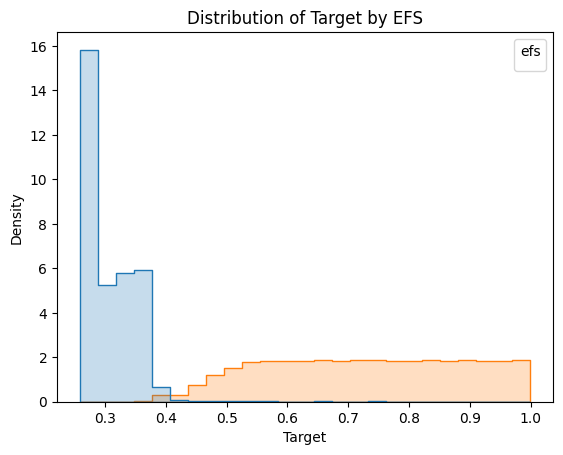

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities

race_group=sorted(train['race_group'].unique())
for race in race_group:
    train.loc[train['race_group']==race,"target"] = transform_survival_probability(train[train['race_group']==race], time_col='efs_time', event_col='efs')
    gap=0.75*(train.loc[(train['race_group']==race)&(train['efs']==0)]['target'].max()-train.loc[(train['race_group']==race)&(train['efs']==1)]['target'].min())/2
    train.loc[(train['race_group']==race)&(train['efs']==0),'target']-=gap

sns.histplot(data=train, x='target', hue='efs', element='step', stat='density', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

train.drop(['efs','efs_time'],axis=1,inplace=True)

In [139]:
def FE(df):
    #object and nunique<20
    object_cols=['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']
    df[object_cols]=df[object_cols].fillna('NaN')
    #json_columns
    json_char=',[]{}:"\\<'
    for char in json_char:
        for col in object_cols:
            df[col]=df[col].apply(lambda x:str(x).replace(char,''))

    #text_cols
    text_cols=['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']
    df['text']=list(df[text_cols].values)
    df['text']=df['text'].apply(lambda x:" ".join(x))
        
    df.drop(['ID'],axis=1,inplace=True,errors='ignore')
    return df

device1 = 'gpu' if USE_GPU else 'cpu'
device2 = 'GPU' if USE_GPU else 'CPU'

lgb_params={"boosting_type": "gbdt","metric": 'mae',
            'random_state': 2024,  "max_depth": 10,"learning_rate": 0.1,
            "n_estimators": 1024,"colsample_bytree": 0.6,"colsample_bynode": 0.6,
            "verbose": -1,"reg_alpha": 0.2,"reg_lambda": 5,"extra_trees":True,
            'num_leaves':64,"max_bin":255,
            'device': device1,'gpu_use_dp':True,
            }
models=[
        (LGBMRegressor(**lgb_params),'lgb'),
        (
        CatBoostRegressor(
        task_type=device2,  
        learning_rate=0.1,    
        grow_policy='Lossguide',),'cat'
        )
       ]

yunbase=Yunbase(num_folds=10,
                n_repeats=1,
                  models=models,
                  FE=FE,
                  seed=2024,
                  objective='regression',
                  metric='mae',
                  target_col='target',
                  device=device1,
                  one_hot_max=20,
                  early_stop=1000,
                  use_data_augmentation=True,
                  text_cols=['text'],
                  use_pseudo_label=False,
                  use_high_corr_feat=False,
                  use_scaler=True,
                  log=250,
                  plot_feature_importance=True,
)
if TRAIN:
    yunbase.fit(train)
    os.makedirs('/kaggle/working/yunbase', exist_ok=True)
    joblib.dump(yunbase, '/kaggle/working/yunbase/yunbase_ensemble.pkl')
else:
    yunbase = joblib.load(os.path.join(YUNBASE_PATH, 'yunbase_ensemble.pkl'))

Currently supported metrics:['custom_metric', 'mae', 'rmse', 'mse', 'medae', 'rmsle', 'msle', 'mape', 'r2', 'auc', 'logloss', 'f1_score', 'mcc', 'accuracy', 'multi_logloss']
Currently supported models:['lgb', 'cat', 'xgb', 'ridge', 'LinearRegression', 'LogisticRegression', 'tabnet', 'Word2Vec', 'tfidfvec', 'countvec']
Currently supported kfolds:['KFold', 'GroupKFold', 'StratifiedKFold', 'StratifiedGroupKFold', 'purged_CV']
Currently supported objectives:['binary', 'multi_class', 'regression']


In [140]:
import shutil
import os

In [141]:
if TRAIN:
    lgb_prediction=np.load(f"Yunbase_info/lgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy")
    lgb_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':lgb_prediction})
    print(f"lgb_score:{score(train_solution.copy(),lgb_prediction.copy(),row_id_column_name='ID')}")
    
    cat_prediction=np.load(f"Yunbase_info/cat_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy")
    cat_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':cat_prediction})
    print(f"cat_score:{score(train_solution.copy(),cat_prediction.copy(),row_id_column_name='ID')}")
    
    # Define source and destination paths
    lgb_source = f"Yunbase_info/lgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy"
    cat_source = f"Yunbase_info/cat_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy"
    destination_folder = "/kaggle/working/yunbase"
    
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)
    
    # Move the files
    shutil.copy2(lgb_source, os.path.join(destination_folder, os.path.basename(lgb_source)))
    shutil.copy2(cat_source, os.path.join(destination_folder, os.path.basename(cat_source)))
    
    print("Files moved successfully.")

else:
    # Define source and destination paths
    lgb_p = os.path.join(YUNBASE_PATH, f"lgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy")
    cat_p = os.path.join(YUNBASE_PATH, f"cat_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy")
    lgb_source = f"Yunbase_info/lgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy"
    cat_source = f"Yunbase_info/cat_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy"
    
    # Create the destination folder if it doesn't exist
    os.makedirs('Yunbase_info', exist_ok=True)
    
    # Move the files
    shutil.copy2(lgb_p, f"Yunbase_info/lgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy")
    shutil.copy2(cat_p, f"Yunbase_info/cat_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy")
    
    lgb_prediction=np.load(f"Yunbase_info/lgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy")
    lgb_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':lgb_prediction})
    print(f"lgb_score:{score(train_solution.copy(),lgb_prediction.copy(),row_id_column_name='ID')}")
    
    cat_prediction=np.load(f"Yunbase_info/cat_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}.npy")
    cat_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':cat_prediction})
    print(f"cat_score:{score(train_solution.copy(),cat_prediction.copy(),row_id_column_name='ID')}")

final_prediction=lgb_prediction.copy()
final_prediction['prediction']=(final_prediction['prediction']+cat_prediction['prediction'])/2
m_yunbase = score(train_solution.copy(),final_prediction.copy(),row_id_column_name='ID')
print(f"final_score:{m_yunbase}")

oof_yunbase = final_prediction['prediction']

lgb_score:0.6735597741955338
cat_score:0.673897384853874
final_score:0.6771496174725505


In [142]:
pred_yunbase = yunbase.predict(test)

predict......
weight normalization
final_repeat0_mae:0.18184765973533779
load test data
test.shape:(3, 58)
Feature Engineer
< text column's feature >
-> for column text text clean
-> for column text word feature
-> for column text sentence feature
-> for column text paragraph feature
< one hot encoder >
< drop useless cols >
< robust scaler >
------------------------------
prediction on test data


# multitarget

In [143]:
# additional imports
from lifelines import KaplanMeierFitter
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# load data
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
sample_submission = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")

In [144]:
# def kaplan(df, time_col = 'efs_time', event_col='efs'):
#     kmf = KaplanMeierFitter()
#     kmf.fit(df[time_col], event_observed=df[event_col])
#     return kmf.survival_function_at_times(df[time_col]).values.flatten()

def kaplan(data, time_col='efs_time', event_col='efs', group_col='race_group'):
    cv = KFold(n_splits=10, shuffle=True, random_state=52)
    target = np.zeros(len(data))

    for train_index, valid_index in cv.split(data):
        train_data = data.iloc[train_index]
        valid_data = data.iloc[valid_index]

        kmf = KaplanMeierFitter()
        kmf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
        target[valid_index] = kmf.survival_function_at_times(valid_data[time_col]).values
    
    return target

train['rank1'] = kaplan(train)

train['rank2'] = kaplan(train)
train['rank2'] = np.where(train['efs']==0, train['rank2']-0.05, train['rank2'])

train['rank3'] = kaplan(train)
train['rank3'] = np.where(train['efs']==0, train['rank3']-0.1, train['rank3'])

train['rank4'] = kaplan(train)
train['rank4'] = np.where(train['efs']==0, train['rank4']-0.2, train['rank4'])

In [145]:
# features
cols_to_use = [col for col in train.columns if col not in ['efs', 'ID', 'rank1', 'rank2', 'rank3', 'rank4', 'efs_time']]
categorical_columns = train[cols_to_use].select_dtypes(include=['object', 'category']).columns.tolist()

# fill missing in categoricals
train[categorical_columns] = train[categorical_columns].fillna('nan')
test[categorical_columns] = test[categorical_columns].fillna('nan')

In [146]:
# copy train and test
df_train = train.copy()
df_test = test.copy()

# iterations
mod4_it = 3000

In [147]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=52)
    
oof_cat_multitarget = np.zeros(len(train))
pred_cat_multitarget = np.zeros(len(test))

device = 'GPU' if USE_GPU else 'CPU'

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = df_train.loc[train_index,cols_to_use].copy()
    y_train = df_train.iloc[train_index][['rank1', 'rank2', 'rank3', 'rank4']]
    x_valid = df_train.loc[test_index,cols_to_use].copy()
    y_valid = df_train.iloc[test_index][['rank1', 'rank2', 'rank3', 'rank4']]
    x_test = df_test[cols_to_use].copy()

    # Multitarget Regressor
    if TRAIN:
        model_multitarget = CatBoostRegressor(
            iterations = mod4_it,
            loss_function = 'MultiRMSE',
            cat_features=categorical_columns,         
            task_type=device,
            boosting_type='Plain',
            random_seed=52,
            early_stopping_rounds=100
        )
        model_multitarget.fit(
            x_train, 
            y_train, 
            eval_set=(x_valid, y_valid),
            cat_features=categorical_columns, 
            verbose=250
        )
        os.makedirs('/kaggle/working/multitarget_models', exist_ok=True)
        joblib.dump(model_multitarget, f'/kaggle/working/multitarget_models/multitarget_model_fold_{i}.pkl')
    else:
        model_multitarget = joblib.load(os.path.join(MULTITARGET_PATH, f'multitarget_model_fold_{i}.pkl'))

    # INFER OOF
    pred_val = model_multitarget.predict(x_valid)
    pred_val = (pred_val[:,0] + pred_val[:,1] + pred_val[:,2]+ pred_val[:,3]) / 4
    oof_cat_multitarget[test_index] = pred_val
    
    # INFER TEST
    pred_val = model_multitarget.predict(x_test)
    pred_val = (pred_val[:,0] + pred_val[:,1] + pred_val[:,2]+ pred_val[:,3]) / 4
    pred_cat_multitarget += pred_val

# COMPUTE AVERAGE TEST PREDS
pred_cat_multitarget /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################
CPU times: user 2.89 s, sys: 98 ms, total: 2.98 s
Wall time: 1.95 s


In [148]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_multitarget
m_multitarget = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for cat_multitarget KaplanMeier =",m_multitarget)


Overall CV for cat_multitarget KaplanMeier = 0.6763832159136757


# tabm kaplan

In [149]:
!pip install rtdl_num_embeddings -q --no-index --find-links=/kaggle/input/cibmtr2024-import/rtdl_num_embeddings
!pip install delu -q --no-index --find-links=/kaggle/input/cibmtr2024-import/delu

In [150]:
# License: https://github.com/yandex-research/tabm/blob/main/LICENSE

# NOTE
# The minimum required versions of the dependencies are specified in README.md.

import itertools
from typing import Any, Literal

import rtdl_num_embeddings
import torch
import torch.nn as nn
from torch import Tensor


# ======================================================================================
# Initialization
# ======================================================================================
def init_rsqrt_uniform_(x: Tensor, d: int) -> Tensor:
    assert d > 0
    d_rsqrt = d**-0.5
    return nn.init.uniform_(x, -d_rsqrt, d_rsqrt)


@torch.inference_mode()
def init_random_signs_(x: Tensor) -> Tensor:
    return x.bernoulli_(0.5).mul_(2).add_(-1)


# ======================================================================================
# Modules
# ======================================================================================
class NLinear(nn.Module):
    """N linear layers applied in parallel to N disjoint parts of the input.

    **Shape**

    - Input: ``(B, N, in_features)``
    - Output: ``(B, N, out_features)``

    The i-th linear layer is applied to the i-th matrix of the shape (B, in_features).

    Technically, this is a simplified version of delu.nn.NLinear:
    https://yura52.github.io/delu/stable/api/generated/delu.nn.NLinear.html.
    The difference is that this layer supports only 3D inputs
    with exactly one batch dimension. By contrast, delu.nn.NLinear supports
    any number of batch dimensions.
    """

    def __init__(
        self, n: int, in_features: int, out_features: int, bias: bool = True
    ) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n, in_features, out_features))
        self.bias = nn.Parameter(torch.empty(n, out_features)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        d = self.weight.shape[-2]
        init_rsqrt_uniform_(self.weight, d)
        if self.bias is not None:
            init_rsqrt_uniform_(self.bias, d)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        assert x.shape[-(self.weight.ndim - 1) :] == self.weight.shape[:-1]

        x = x.transpose(0, 1)
        x = x @ self.weight
        x = x.transpose(0, 1)
        if self.bias is not None:
            x = x + self.bias
        return x


class OneHotEncoding0d(nn.Module):
    # Input:  (*, n_cat_features=len(cardinalities))
    # Output: (*, sum(cardinalities))

    def __init__(self, cardinalities: list[int]) -> None:
        super().__init__()
        self._cardinalities = cardinalities

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim >= 1
        assert x.shape[-1] == len(self._cardinalities)
        
        return torch.cat(
            [
                # NOTE
                # This is a quick hack to support out-of-vocabulary categories.
                #
                # Recall that lib.data.transform_cat encodes categorical features
                # as follows:
                # - In-vocabulary values receive indices from `range(cardinality)`.
                # - All out-of-vocabulary values (i.e. new categories in validation
                #   and test data that are not presented in the training data)
                #   receive the index `cardinality`.
                #
                # As such, the line below will produce the standard one-hot encoding for
                # known categories, and the all-zeros encoding for unknown categories.
                # This may not be the best approach to deal with unknown values,
                # but should be enough for our purposes.
                nn.functional.one_hot(x[..., i], cardinality + 1)[..., :-1]
                for i, cardinality in enumerate(self._cardinalities)
            ],
            -1,
        )


class ScaleEnsemble(nn.Module):
    def __init__(
        self,
        k: int,
        d: int,
        *,
        init: Literal['ones', 'normal', 'random-signs'],
    ) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.empty(k, d))
        self._weight_init = init
        self.reset_parameters()

    def reset_parameters(self) -> None:
        if self._weight_init == 'ones':
            nn.init.ones_(self.weight)
        elif self._weight_init == 'normal':
            nn.init.normal_(self.weight)
        elif self._weight_init == 'random-signs':
            init_random_signs_(self.weight)
        else:
            raise ValueError(f'Unknown weight_init: {self._weight_init}')

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim >= 2
        return x * self.weight


class LinearEfficientEnsemble(nn.Module):
    """
    This layer is a more configurable version of the "BatchEnsemble" layer
    from the paper
    "BatchEnsemble: An Alternative Approach to Efficient Ensemble and Lifelong Learning"
    (link: https://arxiv.org/abs/2002.06715).

    First, this layer allows to select only some of the "ensembled" parts:
    - the input scaling  (r_i in the BatchEnsemble paper)
    - the output scaling (s_i in the BatchEnsemble paper)
    - the output bias    (not mentioned in the BatchEnsemble paper,
                          but is presented in public implementations)

    Second, the initialization of the scaling weights is configurable
    through the `scaling_init` argument.

    NOTE
    The term "adapter" is used in the TabM paper only to tell the story.
    The original BatchEnsemble paper does NOT use this term. So this class also
    avoids the term "adapter".
    """

    r: None | Tensor
    s: None | Tensor
    bias: None | Tensor

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        *,
        k: int,
        ensemble_scaling_in: bool,
        ensemble_scaling_out: bool,
        ensemble_bias: bool,
        scaling_init: Literal['ones', 'random-signs'],
    ):
        assert k > 0
        if ensemble_bias:
            assert bias
        super().__init__()

        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.register_parameter(
            'r',
            (
                nn.Parameter(torch.empty(k, in_features))
                if ensemble_scaling_in
                else None
            ),  # type: ignore[code]
        )
        self.register_parameter(
            's',
            (
                nn.Parameter(torch.empty(k, out_features))
                if ensemble_scaling_out
                else None
            ),  # type: ignore[code]
        )
        self.register_parameter(
            'bias',
            (
                nn.Parameter(torch.empty(out_features))  # type: ignore[code]
                if bias and not ensemble_bias
                else nn.Parameter(torch.empty(k, out_features))
                if ensemble_bias
                else None
            ),
        )

        self.in_features = in_features
        self.out_features = out_features
        self.k = k
        self.scaling_init = scaling_init

        self.reset_parameters()

    def reset_parameters(self):
        init_rsqrt_uniform_(self.weight, self.in_features)
        scaling_init_fn = {'ones': nn.init.ones_, 'random-signs': init_random_signs_}[
            self.scaling_init
        ]
        if self.r is not None:
            scaling_init_fn(self.r)
        if self.s is not None:
            scaling_init_fn(self.s)
        if self.bias is not None:
            bias_init = torch.empty(
                # NOTE: the shape of bias_init is (out_features,) not (k, out_features).
                # It means that all biases have the same initialization.
                # This is similar to having one shared bias plus
                # k zero-initialized non-shared biases.
                self.out_features,
                dtype=self.weight.dtype,
                device=self.weight.device,
            )
            bias_init = init_rsqrt_uniform_(bias_init, self.in_features)
            with torch.inference_mode():
                self.bias.copy_(bias_init)

    def forward(self, x: Tensor) -> Tensor:
        # x.shape == (B, K, D)
        assert x.ndim == 3

        # >>> The equation (5) from the BatchEnsemble paper (arXiv v2).
        if self.r is not None:
            x = x * self.r
        x = x @ self.weight.T
        if self.s is not None:
            x = x * self.s
        # <<<

        if self.bias is not None:
            x = x + self.bias
        return x


class MLP(nn.Module):
    def __init__(
        self,
        *,
        d_in: None | int = None,
        d_out: None | int = None,
        n_blocks: int,
        d_block: int,
        dropout: float,
        activation: str = 'ReLU',
    ) -> None:
        super().__init__()

        d_first = d_block if d_in is None else d_in
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(d_first if i == 0 else d_block, d_block),
                    getattr(nn, activation)(),
                    nn.Dropout(dropout),
                )
                for i in range(n_blocks)
            ]
        )
        self.output = None if d_out is None else nn.Linear(d_block, d_out)

    def forward(self, x: Tensor) -> Tensor:
        for block in self.blocks:
            x = block(x)
        if self.output is not None:
            x = self.output(x)
        return x


def make_efficient_ensemble(module: nn.Module, **kwargs) -> None:
    """Replace torch.nn.Linear modules with LinearEfficientEnsemble.

    NOTE
    In the paper, there are no experiments with networks with normalization layers.
    Perhaps, their trainable weights (the affine transformations) also need
    "ensemblification" as in the paper about "FiLM-Ensemble".
    Additional experiments are required to make conclusions.
    """
    for name, submodule in list(module.named_children()):
        if isinstance(submodule, nn.Linear):
            module.add_module(
                name,
                LinearEfficientEnsemble(
                    in_features=submodule.in_features,
                    out_features=submodule.out_features,
                    bias=submodule.bias is not None,
                    **kwargs,
                ),
            )
        else:
            make_efficient_ensemble(submodule, **kwargs)


def _get_first_ensemble_layer(backbone: MLP) -> LinearEfficientEnsemble:
    if isinstance(backbone, MLP):
        return backbone.blocks[0][0]  # type: ignore[code]
    else:
        raise RuntimeError(f'Unsupported backbone: {backbone}')


@torch.inference_mode()
def _init_first_adapter(
    weight: Tensor,
    distribution: Literal['normal', 'random-signs'],
    init_sections: list[int],
) -> None:
    """Initialize the first adapter.

    NOTE
    The `init_sections` argument is a historical artifact that accidentally leaked
    from irrelevant experiments to the final models. Perhaps, the code related
    to `init_sections` can be simply removed, but this was not tested.
    """
    assert weight.ndim == 2
    assert weight.shape[1] == sum(init_sections)

    if distribution == 'normal':
        init_fn_ = nn.init.normal_
    elif distribution == 'random-signs':
        init_fn_ = init_random_signs_
    else:
        raise ValueError(f'Unknown distribution: {distribution}')

    section_bounds = [0, *torch.tensor(init_sections).cumsum(0).tolist()]
    for i in range(len(init_sections)):
        # NOTE
        # As noted above, this section-based initialization is an arbitrary historical
        # artifact. Consider the first adapter of one ensemble member.
        # This adapter vector is implicitly split into "sections",
        # where one section corresponds to one feature. The code below ensures that
        # the adapter weights in one section are initialized with the same random value
        # from the given distribution.
        w = torch.empty((len(weight), 1), dtype=weight.dtype, device=weight.device)
        init_fn_(w)
        weight[:, section_bounds[i] : section_bounds[i + 1]] = w


_CUSTOM_MODULES = {
    # https://docs.python.org/3/library/stdtypes.html#definition.__name__
    CustomModule.__name__: CustomModule
    for CustomModule in [
        rtdl_num_embeddings.LinearEmbeddings,
        rtdl_num_embeddings.LinearReLUEmbeddings,
        rtdl_num_embeddings.PeriodicEmbeddings,
        rtdl_num_embeddings.PiecewiseLinearEmbeddings,
        MLP,
    ]
}


def make_module(type: str, *args, **kwargs) -> nn.Module:
    Module = getattr(nn, type, None)
    if Module is None:
        Module = _CUSTOM_MODULES[type]
    return Module(*args, **kwargs)


# ======================================================================================
# Optimization
# ======================================================================================
def default_zero_weight_decay_condition(
    module_name: str, module: nn.Module, parameter_name: str, parameter: nn.Parameter
):
    from rtdl_num_embeddings import _Periodic

    del module_name, parameter
    return parameter_name.endswith('bias') or isinstance(
        module,
        nn.BatchNorm1d
        | nn.LayerNorm
        | nn.InstanceNorm1d
        | rtdl_num_embeddings.LinearEmbeddings
        | rtdl_num_embeddings.LinearReLUEmbeddings
        | _Periodic,
    )


def make_parameter_groups(
    module: nn.Module,
    zero_weight_decay_condition=default_zero_weight_decay_condition,
    custom_groups: None | list[dict[str, Any]] = None,
) -> list[dict[str, Any]]:
    if custom_groups is None:
        custom_groups = []
    custom_params = frozenset(
        itertools.chain.from_iterable(group['params'] for group in custom_groups)
    )
    assert len(custom_params) == sum(
        len(group['params']) for group in custom_groups
    ), 'Parameters in custom_groups must not intersect'
    zero_wd_params = frozenset(
        p
        for mn, m in module.named_modules()
        for pn, p in m.named_parameters()
        if p not in custom_params and zero_weight_decay_condition(mn, m, pn, p)
    )
    default_group = {
        'params': [
            p
            for p in module.parameters()
            if p not in custom_params and p not in zero_wd_params
        ]
    }
    return [
        default_group,
        {'params': list(zero_wd_params), 'weight_decay': 0.0},
        *custom_groups,
    ]


# ======================================================================================
# The model
# ======================================================================================
class Model(nn.Module):
    """MLP & TabM."""

    def __init__(
        self,
        *,
        n_num_features: int,
        cat_cardinalities: list[int],
        n_classes: None | int,
        backbone: dict,
        bins: None | list[Tensor],  # For piecewise-linear encoding/embeddings.
        num_embeddings: None | dict = None,
        arch_type: Literal[
            # Plain feed-forward network without any kind of ensembling.
            'plain',
            #
            # TabM-mini
            'tabm-mini',
            #
            # TabM-mini. The first adapter is initialized from the normal distribution.
            # This is used in Section 5.1 of the paper.
            'tabm-mini-normal',
            #
            # TabM
            'tabm',
            #
            # TabM. The first adapter is initialized from the normal distribution.
            # This variation is not used in the paper, but there is a preliminary
            # evidence that may be a better default strategy.
            'tabm-normal',
        ],
        k: None | int = None,
    ) -> None:
        # >>> Validate arguments.
        assert n_num_features >= 0
        assert n_num_features or cat_cardinalities
        if arch_type == 'plain':
            assert k is None
        else:
            assert k is not None
            assert k > 0

        super().__init__()

        # >>> Continuous (numerical) features
        first_adapter_sections = []  # See the comment in `_init_first_adapter`.

        if n_num_features == 0:
            assert bins is None
            self.num_module = None
            d_num = 0

        elif num_embeddings is None:
            assert bins is None
            self.num_module = None
            d_num = n_num_features
            first_adapter_sections.extend(1 for _ in range(n_num_features))

        else:
            if bins is None:
                self.num_module = make_module(
                    **num_embeddings, n_features=n_num_features
                )
            else:
                assert num_embeddings['type'].startswith('PiecewiseLinearEmbeddings')
                self.num_module = make_module(**num_embeddings, bins=bins)
            d_num = n_num_features * num_embeddings['d_embedding']
            first_adapter_sections.extend(
                num_embeddings['d_embedding'] for _ in range(n_num_features)
            )

        # >>> Categorical features
        self.cat_module = (
            OneHotEncoding0d(cat_cardinalities) if cat_cardinalities else None
        )
        first_adapter_sections.extend(cat_cardinalities)
        d_cat = sum(cat_cardinalities)

        # >>> Backbone
        d_flat = d_num + d_cat
        self.minimal_ensemble_adapter = None
        # Any backbone can be here but we provide only MLP
        self.backbone = make_module(d_in=d_flat, **backbone)

        if arch_type != 'plain':
            assert k is not None
            first_adapter_init = (
                'normal'
                if arch_type in ('tabm-mini-normal', 'tabm-normal')
                # For other arch_types, the initialization depends
                # on the presense of num_embeddings.
                else 'random-signs'
                if num_embeddings is None
                else 'normal'
            )

            if arch_type in ('tabm-mini', 'tabm-mini-normal'):
                # Minimal ensemble
                self.minimal_ensemble_adapter = ScaleEnsemble(
                    k,
                    d_flat,
                    init='random-signs' if num_embeddings is None else 'normal',
                )
                _init_first_adapter(
                    self.minimal_ensemble_adapter.weight,  # type: ignore[code]
                    first_adapter_init,
                    first_adapter_sections,
                )

            elif arch_type in ('tabm', 'tabm-normal'):
                # Like BatchEnsemble, but all multiplicative adapters,
                # except for the very first one, are initialized with ones.
                make_efficient_ensemble(
                    self.backbone,
                    k=k,
                    ensemble_scaling_in=True,
                    ensemble_scaling_out=True,
                    ensemble_bias=True,
                    scaling_init='ones',
                )
                _init_first_adapter(
                    _get_first_ensemble_layer(self.backbone).r,  # type: ignore[code]
                    first_adapter_init,
                    first_adapter_sections,
                )

            else:
                raise ValueError(f'Unknown arch_type: {arch_type}')

        # >>> Output
        d_block = backbone['d_block']
        d_out = 1 if n_classes is None else n_classes
        self.output = (
            nn.Linear(d_block, d_out)
            if arch_type == 'plain'
            else NLinear(k, d_block, d_out)  # type: ignore[code]
        )

        # >>>
        self.arch_type = arch_type
        self.k = k

    def forward(
        self, x_num: None | Tensor = None, x_cat: None | Tensor = None
    ) -> Tensor:
        x = []
        if x_num is not None:
            x.append(x_num if self.num_module is None else self.num_module(x_num))
        if x_cat is None:
            assert self.cat_module is None
        else:
            assert self.cat_module is not None
            x.append(self.cat_module(x_cat).float())
        x = torch.column_stack([x_.flatten(1, -1) for x_ in x])

        if self.k is not None:
            x = x[:, None].expand(-1, self.k, -1)  # (B, D) -> (B, K, D)
            if self.minimal_ensemble_adapter is not None:
                x = self.minimal_ensemble_adapter(x)
        else:
            assert self.minimal_ensemble_adapter is None

        x = self.backbone(x)
        x = self.output(x)
        if self.k is None:
            # Adjust the output shape for plain networks to make them compatible
            # with the rest of the script (loss, metrics, predictions, ...).
            # (B, D_OUT) -> (B, 1, D_OUT)
            x = x[:, None]
        return x

In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import rtdl_num_embeddings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score

from IPython.display import clear_output

from metric import score
import warnings
warnings.filterwarnings('ignore')

import joblib
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset

import delu
import math

from collections import OrderedDict
from tqdm import tqdm

In [152]:
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [153]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

def create_fold_specific_target(data, time_col='efs_time', event_col='efs', group_col='race_group'):
    cv = KFold(n_splits=10, shuffle=True, random_state=52)
    target = np.zeros(len(data))

    for train_index, valid_index in cv.split(data):
        train_data = data.iloc[train_index]
        valid_data = data.iloc[valid_index]

        kmf = KaplanMeierFitter()
        kmf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
        target[valid_index] = kmf.survival_function_at_times(valid_data[time_col]).values
        
    data['y'] = target
    
    return data

def create_fold_specific_target2(data, time_col='efs_time', event_col='efs', group_col='race_group'):
    cv = KFold(n_splits=10, shuffle=True, random_state=52)
    target = np.zeros(len(data))

    for train_index, valid_index in cv.split(data):
        train_data = data.iloc[train_index]
        valid_data = data.iloc[valid_index]

        naf = NelsonAalenFitter()
        naf.fit(durations=train_data[time_col], event_observed=train_data[event_col])
        target[valid_index] = -naf.cumulative_hazard_at_times(valid_data[time_col]).values
        
    data['y_2'] = target
    
    return data

train = create_fold_specific_target(train, time_col='efs_time', event_col='efs', group_col='race_group')

# train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
# train.loc[train['efs']==0, 'label'] -= 0.2

# train["efs_time2"] = train.efs_time.copy()
# train.loc[train.efs==0,"efs_time2"] *= -1

In [154]:
combined = pd.concat([train, test], axis=0)

RMV = ["ID","efs","efs_time", "y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [155]:
CATS = []
for c in FEATURES:
    num_unique = combined[c].nunique()
    if num_unique < 100:
        CATS.append(c)
        train[c] = train[c].fillna(999)
        test[c] = test[c].fillna(999)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

NUMS = [c for c in FEATURES if not c in CATS]

In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [156]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

cat_unique = combined[CATS].nunique().to_list()

for c in NUMS:
    combined[c] = combined[c].fillna(0)

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, hla_match_c_high, hla_high_res_8, tbi_status, arrhythmia, hla_low_res_6, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, hla_high_res_6, cmv_status, hla_high_res_10, hla_match_dqb1_high, tce_imm_match, hla_nmdp_6, hla_match_c_low, rituximab, hla_match_drb1_low, hla_match_dqb1_low, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, year_hct, obesity, mrd_hct, in_vivo_tcd, tce_match, hla_match_a_high, hepatic_severe, prior_tumor, hla_match_b_low, peptic_ulcer, hla_match_a_low, gvhd_proph, rheum_issue, sex_match, hla_match_b_high, race_group, comorbidity_score, karnofsky_score, hepatic_mild, tce_div_match, donor_related, melphalan_dose, hla_low_res_8, cardiac, hla_match_drb1_high, pulm_moderate, hla_low_res_10, 

In [157]:
cats_index = [train[FEATURES].columns.get_loc(cat) for cat in CATS]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[NUMS] = scaler.fit_transform(train[NUMS])
test[NUMS] = scaler.transform(test[NUMS])

In [158]:
folds = 10
train['kfold'] = -1  

target = 'y'
kf = KFold(n_splits=folds, random_state=52, shuffle=True)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(kf.split(X=train)):
    train.loc[val_idx, 'kfold'] = fold

oof_metric = train[['kfold','ID','efs','efs_time','y','race_group']].copy()
oof_metric['prediction'] = 0.0

oof_tabm = np.zeros(train.shape[0])
test_tabm = np.zeros((folds, test.shape[0]))

In [159]:
X_num = train[NUMS].values
X_cat = train[CATS].values

X_num_test = test[NUMS].values
X_cat_test = test[CATS].values

y = train[target].values

test_dl = DataLoader(TensorDataset(torch.tensor(X_num_test, dtype=torch.float32), torch.tensor(X_cat_test, dtype=torch.int64)), batch_size=1024, shuffle=False)

In [160]:
n_cont_features = len(NUMS)
n_cat_features = len(CATS)
n_classes = None
cat_cardinalities = cat_unique

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [161]:
# TabM
# arch_type = 'tabm'
# bins = None

# TabM-mini with the piecewise-linear embeddings.
arch_type = 'tabm-mini'

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

loss_fn = RMSELoss()

In [162]:
MODEL_SAVE_PATH = "tabm_models"  # Папка для сохранения/загрузки моделей
dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_rmse_scores = []
val_cindex_scores = []    

if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

for i, (train_index, val_index) in enumerate(kf.split(train[FEATURES])):
    model_path = os.path.join(MODEL_SAVE_PATH, f"model_fold_{i}.pt")

    best = {
        "val": -math.inf,
        "epoch": -1,
    }
    ds_true = oof_metric.loc[oof_metric.kfold==i, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_metric.loc[oof_metric.kfold==i, ["ID"]].copy().reset_index(drop=True)

    X_num_train = X_num[train_index]
    X_cat_train = X_cat[train_index]
    y_train = y[train_index]

    X_num_val = X_num[val_index]
    X_cat_val = X_cat[val_index]
    y_val_all = y[val_index]

    train_dl = DataLoader(TensorDataset(torch.tensor(X_num_train, dtype=torch.float32), torch.tensor(X_cat_train, dtype=torch.int64), 
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=32, shuffle=True)
    valid_dl = DataLoader(TensorDataset(torch.tensor(X_num_val, dtype=torch.float32), torch.tensor(X_cat_val, dtype=torch.int64), 
                                        torch.tensor(y_val_all, dtype=torch.float32)), batch_size=32, shuffle=False)

    bins = rtdl_num_embeddings.compute_bins(torch.tensor(X_num_train, dtype=torch.float32))

    model = Model(
        n_num_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        n_classes=n_classes,
        backbone={
            'type': 'MLP',
            'n_blocks': 3 ,
            'd_block': 512,
            'dropout': 0.1,
        },
        bins=bins,
        num_embeddings=(
            None
            if bins is None
            else {
                'type': 'PiecewiseLinearEmbeddings',
                'd_embedding': 64,
                'activation': True,
                'version': 'B',
            }
        ),
        arch_type=arch_type,
        k=32,
    ).to(device)

    if TRAIN:  # Обучение модели
        optimizer = torch.optim.AdamW(
            make_parameter_groups(model),
            lr=1e-4,
            weight_decay=1e-3 ,
        )

        patience = 15
        early_stopping = delu.tools.EarlyStopping(patience, mode="max")

        for epoch in range(100):
            model.train()   
            with tqdm(train_dl, total=len(train_dl), leave=True) as phar:
                for train_tensor in phar:
                    optimizer.zero_grad()
                    X_num_train, X_cat_train, y_train = [t.to(device) for t in train_tensor]

                    output = model(X_num_train, X_cat_train).squeeze(-1)
                    loss = loss_fn(output.flatten(0, 1), y_train.repeat_interleave(32))
                    loss.backward()
                    optimizer.step()

                    phar.set_postfix(OrderedDict(epoch=f'{epoch+1}/{100}', loss=f'{loss.item():.6f}'))
                    phar.update(1)

            # Валидация
            model.eval()
            valid_pred_list = []
            for valid_tensor in valid_dl:
                X_num_val, X_cat_val, y_val = [t.to(device) for t in valid_tensor]
                with torch.no_grad():
                    output = model(X_num_val, X_cat_val).squeeze(-1)
                valid_pred_list.append((output.mean(1).cpu().numpy(), y_val.cpu().numpy()))

            valid_pred = np.concatenate([p[0] for p in valid_pred_list])
            valid_true = np.concatenate([p[1] for p in valid_pred_list])
            val_loss = loss_fn(torch.tensor(valid_pred), torch.tensor(valid_true)).item()

            ds_pred["prediction"] = valid_pred
            val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
            
            if val_cindex > best["val"]:
                print("🌸 New best epoch! 🌸 with cindex: ", val_cindex)
                best = {"val": val_cindex, "epoch": epoch, 'pred' : valid_pred}

            early_stopping.update(val_cindex)
            if early_stopping.should_stop():
                print("Early stopping")
                break

        # Сохранение модели
        torch.save(model.state_dict(), model_path)
    else:  # Загрузка предобученной модели
        mp = os.path.join(TABM_PATH, f"model_fold_{i}.pt")
        print(f"Loading model from {mp}")
        model.load_state_dict(torch.load(mp, map_location=dvc))

    # Валидация
    model.eval()
    valid_pred_list = []
    for valid_tensor in valid_dl:
        X_num_val, X_cat_val, y_val = [t.to(device) for t in valid_tensor]
        with torch.no_grad():
            output = model(X_num_val, X_cat_val).squeeze(-1)
        valid_pred_list.append((output.mean(1).cpu().numpy(), y_val.cpu().numpy()))

    valid_pred = np.concatenate([p[0] for p in valid_pred_list])
    best['pred'] = valid_pred

    oof_tabm[val_index] = best['pred']
    val_rmse = mean_squared_error(y_val_all, best['pred']) ** 0.5
    val_rmse_scores.append(val_rmse)

    ds_pred["prediction"] = best['pred']
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
    val_cindex_scores.append(val_cindex)

    # Инференс на тесте
    model.eval()
    test_pred_list = []
    with torch.no_grad():
        for test_tensor in test_dl:
            X_num_test, X_cat_test = [t.to(device) for t in test_tensor]
            output = model(X_num_test, X_cat_test).squeeze(-1)
            test_pred_list.append(output.mean(1).cpu().numpy())

    test_pred = np.concatenate([p for p in test_pred_list])
    test_tabm[i] = test_pred

    print(" *************************************************************************************** ")
    print(f"Fold {i+1} RMSE: {val_rmse:.6f}", f"Fold {i+1} C-Index: {val_cindex:.6f}")
    print("\n")
    print(" *************************************************************************************** ")

Loading model from /kaggle/input/cibmtr-models-meier/tabm_models/model_fold_0.pt
 *************************************************************************************** 
Fold 1 RMSE: 0.155096 Fold 1 C-Index: 0.672735


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-models-meier/tabm_models/model_fold_1.pt
 *************************************************************************************** 
Fold 2 RMSE: 0.154199 Fold 2 C-Index: 0.664519


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-models-meier/tabm_models/model_fold_2.pt
 *************************************************************************************** 
Fold 3 RMSE: 0.155930 Fold 3 C-Index: 0.683152


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-models-meier/tabm_models/model

In [163]:
print("Mean Validation RMSE: {:.6f}".format(np.mean(val_rmse_scores)))
print("Mean Validation C-Index: {:.6f}".format(np.mean(val_cindex_scores)))
print("OOF RMSE: {:.6f}".format(mean_squared_error(train[target], oof_tabm) ** 0.5))

results_df = pd.DataFrame({
        'Fold': np.arange(1, folds+1),
        'Validation RMSE': val_rmse_scores,
        'Validation C-Index': val_cindex_scores
    })

print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_tabm
m_tabm = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for TabM KaplanMeier =",m_tabm)

Mean Validation RMSE: 0.156413
Mean Validation C-Index: 0.667259
OOF RMSE: 0.156427

=== KFold RMSE Results ===
   Fold  Validation RMSE  Validation C-Index
0     1         0.155096            0.672735
1     2         0.154199            0.664519
2     3         0.155930            0.683152
3     4         0.153663            0.651451
4     5         0.158362            0.669366
5     6         0.156838            0.678491
6     7         0.158359            0.663978
7     8         0.159311            0.651800
8     9         0.158787            0.664765
9    10         0.153588            0.672329

Overall CV for TabM KaplanMeier = 0.6748220959683676


In [164]:
pred_tabm = np.mean(test_tabm , axis=0) 

# tabm aalen

In [165]:
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [166]:
train = create_fold_specific_target2(train, time_col='efs_time', event_col='efs', group_col='race_group')

In [167]:
combined = pd.concat([train, test], axis=0)

RMV = ["ID","efs","efs_time", "y_2"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [168]:
CATS = []
for c in FEATURES:
    num_unique = combined[c].nunique()
    if num_unique < 100:
        CATS.append(c)
        train[c] = train[c].fillna(999)
        test[c] = test[c].fillna(999)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

NUMS = [c for c in FEATURES if not c in CATS]

In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [169]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

cat_unique = combined[CATS].nunique().to_list()

for c in NUMS:
    combined[c] = combined[c].fillna(0)

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, hla_match_c_high, hla_high_res_8, tbi_status, arrhythmia, hla_low_res_6, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, hla_high_res_6, cmv_status, hla_high_res_10, hla_match_dqb1_high, tce_imm_match, hla_nmdp_6, hla_match_c_low, rituximab, hla_match_drb1_low, hla_match_dqb1_low, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, year_hct, obesity, mrd_hct, in_vivo_tcd, tce_match, hla_match_a_high, hepatic_severe, prior_tumor, hla_match_b_low, peptic_ulcer, hla_match_a_low, gvhd_proph, rheum_issue, sex_match, hla_match_b_high, race_group, comorbidity_score, karnofsky_score, hepatic_mild, tce_div_match, donor_related, melphalan_dose, hla_low_res_8, cardiac, hla_match_drb1_high, pulm_moderate, hla_low_res_10, 

In [170]:
cats_index = [train[FEATURES].columns.get_loc(cat) for cat in CATS]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[NUMS] = scaler.fit_transform(train[NUMS])
test[NUMS] = scaler.transform(test[NUMS])

In [171]:
folds = 10
train['kfold'] = -1  

target = 'y_2'
kf = KFold(n_splits=folds, random_state=52, shuffle=True)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(kf.split(X=train)):
    train.loc[val_idx, 'kfold'] = fold

oof_metric_2 = train[['kfold','ID','efs','efs_time','y_2','race_group']].copy()
oof_metric_2['prediction'] = 0.0

oof_tabm_2 = np.zeros(train.shape[0])
test_tabm = np.zeros((folds, test.shape[0]))

In [172]:
X_num = train[NUMS].values
X_cat = train[CATS].values

X_num_test = test[NUMS].values
X_cat_test = test[CATS].values

y = train[target].values

test_dl = DataLoader(TensorDataset(torch.tensor(X_num_test, dtype=torch.float32), torch.tensor(X_cat_test, dtype=torch.int64)), batch_size=1024, shuffle=False)

In [173]:
n_cont_features = len(NUMS)
n_cat_features = len(CATS)
n_classes = None
cat_cardinalities = cat_unique

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [174]:
# TabM
# arch_type = 'tabm'
# bins = None

# TabM-mini with the piecewise-linear embeddings.
arch_type = 'tabm-mini'

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

loss_fn = RMSELoss()

In [175]:
MODEL_SAVE_PATH = "tabm_models_aalen"  # Папка для сохранения/загрузки моделей
dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_rmse_scores = []
val_cindex_scores = []    

if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

for i, (train_index, val_index) in enumerate(kf.split(train[FEATURES])):
    model_path = os.path.join(MODEL_SAVE_PATH, f"model_fold_{i}.pt")

    best = {
        "val": -math.inf,
        "epoch": -1,
    }
    ds_true = oof_metric_2.loc[oof_metric_2.kfold==i, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_metric_2.loc[oof_metric_2.kfold==i, ["ID"]].copy().reset_index(drop=True)

    X_num_train = X_num[train_index]
    X_cat_train = X_cat[train_index]
    y_train = y[train_index]

    X_num_val = X_num[val_index]
    X_cat_val = X_cat[val_index]
    y_val_all = y[val_index]

    train_dl = DataLoader(TensorDataset(torch.tensor(X_num_train, dtype=torch.float32), torch.tensor(X_cat_train, dtype=torch.int64), 
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=32, shuffle=True)
    valid_dl = DataLoader(TensorDataset(torch.tensor(X_num_val, dtype=torch.float32), torch.tensor(X_cat_val, dtype=torch.int64), 
                                        torch.tensor(y_val_all, dtype=torch.float32)), batch_size=32, shuffle=False)

    bins = rtdl_num_embeddings.compute_bins(torch.tensor(X_num_train, dtype=torch.float32))

    model = Model(
        n_num_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        n_classes=n_classes,
        backbone={
            'type': 'MLP',
            'n_blocks': 3 ,
            'd_block': 512,
            'dropout': 0.1,
        },
        bins=bins,
        num_embeddings=(
            None
            if bins is None
            else {
                'type': 'PiecewiseLinearEmbeddings',
                'd_embedding': 64,
                'activation': True,
                'version': 'B',
            }
        ),
        arch_type=arch_type,
        k=32,
    ).to(device)

    if TRAIN:  # Обучение модели
        optimizer = torch.optim.AdamW(
            make_parameter_groups(model),
            lr=1e-4,
            weight_decay=1e-3 ,
        )

        patience = 15
        early_stopping = delu.tools.EarlyStopping(patience, mode="max")

        for epoch in range(100):
            model.train()   
            with tqdm(train_dl, total=len(train_dl), leave=True) as phar:
                for train_tensor in phar:
                    optimizer.zero_grad()
                    X_num_train, X_cat_train, y_train = [t.to(device) for t in train_tensor]

                    output = model(X_num_train, X_cat_train).squeeze(-1)
                    loss = loss_fn(output.flatten(0, 1), y_train.repeat_interleave(32))
                    loss.backward()
                    optimizer.step()

                    phar.set_postfix(OrderedDict(epoch=f'{epoch+1}/{100}', loss=f'{loss.item():.6f}'))
                    phar.update(1)

            # Валидация
            model.eval()
            valid_pred_list = []
            for valid_tensor in valid_dl:
                X_num_val, X_cat_val, y_val = [t.to(device) for t in valid_tensor]
                with torch.no_grad():
                    output = model(X_num_val, X_cat_val).squeeze(-1)
                valid_pred_list.append((output.mean(1).cpu().numpy(), y_val.cpu().numpy()))

            valid_pred = np.concatenate([p[0] for p in valid_pred_list])
            valid_true = np.concatenate([p[1] for p in valid_pred_list])
            val_loss = loss_fn(torch.tensor(valid_pred), torch.tensor(valid_true)).item()

            ds_pred["prediction"] = valid_pred
            val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
            
            if val_cindex > best["val"]:
                print("🌸 New best epoch! 🌸 with cindex: ", val_cindex)
                best = {"val": val_cindex, "epoch": epoch, 'pred' : valid_pred}

            early_stopping.update(val_cindex)
            if early_stopping.should_stop():
                print("Early stopping")
                break

        # Сохранение модели
        torch.save(model.state_dict(), model_path)
    else:  # Загрузка предобученной модели
        mp = os.path.join(TABM_Y2_PATH, f"model_fold_{i}.pt")
        print(f"Loading model from {mp}")
        model.load_state_dict(torch.load(mp, map_location=dvc))

    # Валидация
    model.eval()
    valid_pred_list = []
    for valid_tensor in valid_dl:
        X_num_val, X_cat_val, y_val = [t.to(device) for t in valid_tensor]
        with torch.no_grad():
            output = model(X_num_val, X_cat_val).squeeze(-1)
        valid_pred_list.append((output.mean(1).cpu().numpy(), y_val.cpu().numpy()))

    valid_pred = np.concatenate([p[0] for p in valid_pred_list])
    best['pred'] = valid_pred

    oof_tabm_2[val_index] = best['pred']
    val_rmse = mean_squared_error(y_val_all, best['pred']) ** 0.5
    val_rmse_scores.append(val_rmse)

    ds_pred["prediction"] = best['pred']
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
    val_cindex_scores.append(val_cindex)

    # Инференс на тесте
    model.eval()
    test_pred_list = []
    with torch.no_grad():
        for test_tensor in test_dl:
            X_num_test, X_cat_test = [t.to(device) for t in test_tensor]
            output = model(X_num_test, X_cat_test).squeeze(-1)
            test_pred_list.append(output.mean(1).cpu().numpy())

    test_pred = np.concatenate([p for p in test_pred_list])
    test_tabm[i] = test_pred

    print(" *************************************************************************************** ")
    print(f"Fold {i+1} RMSE: {val_rmse:.6f}", f"Fold {i+1} C-Index: {val_cindex:.6f}")
    print("\n")
    print(" *************************************************************************************** ")

Loading model from /kaggle/input/cibmtr-tabm-y/tabm_models_aalen/model_fold_0.pt
 *************************************************************************************** 
Fold 1 RMSE: 0.240906 Fold 1 C-Index: 0.673669


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-tabm-y/tabm_models_aalen/model_fold_1.pt
 *************************************************************************************** 
Fold 2 RMSE: 0.237911 Fold 2 C-Index: 0.665646


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-tabm-y/tabm_models_aalen/model_fold_2.pt
 *************************************************************************************** 
Fold 3 RMSE: 0.240885 Fold 3 C-Index: 0.688068


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-tabm-y/tabm_models_aalen/model

In [176]:
print("Mean Validation RMSE: {:.6f}".format(np.mean(val_rmse_scores)))
print("Mean Validation C-Index: {:.6f}".format(np.mean(val_cindex_scores)))
print("OOF RMSE: {:.6f}".format(mean_squared_error(train[target], oof_tabm) ** 0.5))

results_df = pd.DataFrame({
        'Fold': np.arange(1, folds+1),
        'Validation RMSE': val_rmse_scores,
        'Validation C-Index': val_cindex_scores
    })

print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_tabm_2
m_tabm_2 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for TabM Aalen =",m_tabm_2)

Mean Validation RMSE: 0.241428
Mean Validation C-Index: 0.668630
OOF RMSE: 1.157911

=== KFold RMSE Results ===
   Fold  Validation RMSE  Validation C-Index
0     1         0.240906            0.673669
1     2         0.237911            0.665646
2     3         0.240885            0.688068
3     4         0.236147            0.654842
4     5         0.243109            0.671011
5     6         0.240297            0.675281
6     7         0.244090            0.664591
7     8         0.246845            0.651892
8     9         0.246366            0.662673
9    10         0.237727            0.678627

Overall CV for TabM Aalen = 0.6743211486635763


In [177]:
pred_tabm_2 = np.mean(test_tabm , axis=0) 

# tabm old

In [178]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import rtdl_num_embeddings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score

from IPython.display import clear_output

from metric import score
import warnings
warnings.filterwarnings('ignore')

import joblib
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset

import delu
import math

from collections import OrderedDict
from tqdm import tqdm

In [179]:
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [180]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= 0.2

train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [181]:
combined = pd.concat([train, test], axis=0)

RMV = ["ID","efs","efs_time", "label", "y", "efs_time2"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [182]:
CATS = []
for c in FEATURES:
    num_unique = combined[c].nunique()
    if num_unique < 100:
        CATS.append(c)
        train[c] = train[c].fillna(999)
        test[c] = test[c].fillna(999)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

NUMS = [c for c in FEATURES if not c in CATS]

In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [183]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

cat_unique = combined[CATS].nunique().to_list()

for c in NUMS:
    combined[c] = combined[c].fillna(0)

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, hla_match_c_high, hla_high_res_8, tbi_status, arrhythmia, hla_low_res_6, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, hla_high_res_6, cmv_status, hla_high_res_10, hla_match_dqb1_high, tce_imm_match, hla_nmdp_6, hla_match_c_low, rituximab, hla_match_drb1_low, hla_match_dqb1_low, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, year_hct, obesity, mrd_hct, in_vivo_tcd, tce_match, hla_match_a_high, hepatic_severe, prior_tumor, hla_match_b_low, peptic_ulcer, hla_match_a_low, gvhd_proph, rheum_issue, sex_match, hla_match_b_high, race_group, comorbidity_score, karnofsky_score, hepatic_mild, tce_div_match, donor_related, melphalan_dose, hla_low_res_8, cardiac, hla_match_drb1_high, pulm_moderate, hla_low_res_10, 

In [184]:
cats_index = [train[FEATURES].columns.get_loc(cat) for cat in CATS]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[NUMS] = scaler.fit_transform(train[NUMS])
test[NUMS] = scaler.transform(test[NUMS])

In [185]:
folds = 10
train['kfold'] = -1  

target = 'label'
kf = KFold(n_splits=folds, random_state=52, shuffle=True)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(kf.split(X=train)):
    train.loc[val_idx, 'kfold'] = fold

oof_metric = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_metric['prediction'] = 0.0

oof_tabm_old = np.zeros(train.shape[0])
test_tabm_old = np.zeros((folds, test.shape[0]))

In [186]:
X_num = train[NUMS].values
X_cat = train[CATS].values

X_num_test = test[NUMS].values
X_cat_test = test[CATS].values

y = train[target].values

test_dl = DataLoader(TensorDataset(torch.tensor(X_num_test, dtype=torch.float32), torch.tensor(X_cat_test, dtype=torch.int64)), batch_size=1024, shuffle=False)

In [187]:
n_cont_features = len(NUMS)
n_cat_features = len(CATS)
n_classes = None
cat_cardinalities = cat_unique

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [188]:
# TabM
# arch_type = 'tabm'
# bins = None

# TabM-mini with the piecewise-linear embeddings.
arch_type = 'tabm-mini'

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

loss_fn = RMSELoss()

In [189]:
MODEL_SAVE_PATH = "tabm_models"  # Папка для сохранения/загрузки моделей
dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_rmse_scores = []
val_cindex_scores = []    

if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

for i, (train_index, val_index) in enumerate(kf.split(train[FEATURES])):
    model_path = os.path.join(MODEL_SAVE_PATH, f"model_fold_{i}.pt")

    best = {
        "val": -math.inf,
        "epoch": -1,
    }
    ds_true = oof_metric.loc[oof_metric.kfold==i, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_metric.loc[oof_metric.kfold==i, ["ID"]].copy().reset_index(drop=True)

    X_num_train = X_num[train_index]
    X_cat_train = X_cat[train_index]
    y_train = y[train_index]

    X_num_val = X_num[val_index]
    X_cat_val = X_cat[val_index]
    y_val_all = y[val_index]

    train_dl = DataLoader(TensorDataset(torch.tensor(X_num_train, dtype=torch.float32), torch.tensor(X_cat_train, dtype=torch.int64), 
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=32, shuffle=True)
    valid_dl = DataLoader(TensorDataset(torch.tensor(X_num_val, dtype=torch.float32), torch.tensor(X_cat_val, dtype=torch.int64), 
                                        torch.tensor(y_val_all, dtype=torch.float32)), batch_size=32, shuffle=False)

    bins = rtdl_num_embeddings.compute_bins(torch.tensor(X_num_train, dtype=torch.float32))

    model = Model(
        n_num_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        n_classes=n_classes,
        backbone={
            'type': 'MLP',
            'n_blocks': 3 ,
            'd_block': 512,
            'dropout': 0.1,
        },
        bins=bins,
        num_embeddings=(
            None
            if bins is None
            else {
                'type': 'PiecewiseLinearEmbeddings',
                'd_embedding': 64,
                'activation': True,
                'version': 'B',
            }
        ),
        arch_type=arch_type,
        k=32,
    ).to(device)

    if TRAIN:  # Обучение модели
        optimizer = torch.optim.AdamW(
            make_parameter_groups(model),
            lr=1e-4,
            weight_decay=1e-3 ,
        )

        patience = 15
        early_stopping = delu.tools.EarlyStopping(patience, mode="max")

        for epoch in range(100):
            model.train()   
            with tqdm(train_dl, total=len(train_dl), leave=True) as phar:
                for train_tensor in phar:
                    optimizer.zero_grad()
                    X_num_train, X_cat_train, y_train = [t.to(device) for t in train_tensor]

                    output = model(X_num_train, X_cat_train).squeeze(-1)
                    loss = loss_fn(output.flatten(0, 1), y_train.repeat_interleave(32))
                    loss.backward()
                    optimizer.step()

                    phar.set_postfix(OrderedDict(epoch=f'{epoch+1}/{100}', loss=f'{loss.item():.6f}'))
                    phar.update(1)

            # Валидация
            model.eval()
            valid_pred_list = []
            for valid_tensor in valid_dl:
                X_num_val, X_cat_val, y_val = [t.to(device) for t in valid_tensor]
                with torch.no_grad():
                    output = model(X_num_val, X_cat_val).squeeze(-1)
                valid_pred_list.append((output.mean(1).cpu().numpy(), y_val.cpu().numpy()))

            valid_pred = np.concatenate([p[0] for p in valid_pred_list])
            valid_true = np.concatenate([p[1] for p in valid_pred_list])
            val_loss = loss_fn(torch.tensor(valid_pred), torch.tensor(valid_true)).item()

            ds_pred["prediction"] = valid_pred
            val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
            
            if val_cindex > best["val"]:
                print("🌸 New best epoch! 🌸 with cindex: ", val_cindex)
                best = {"val": val_cindex, "epoch": epoch, 'pred' : valid_pred}

            early_stopping.update(val_cindex)
            if early_stopping.should_stop():
                print("Early stopping")
                break

        # Сохранение модели
        torch.save(model.state_dict(), model_path)
    else:  # Загрузка предобученной модели
        mp = os.path.join(TABM_OLD_PATH, f"model_fold_{i}.pt")
        print(f"Loading model from {mp}")
        model.load_state_dict(torch.load(mp, map_location=dvc))

    # Валидация
    model.eval()
    valid_pred_list = []
    for valid_tensor in valid_dl:
        X_num_val, X_cat_val, y_val = [t.to(device) for t in valid_tensor]
        with torch.no_grad():
            output = model(X_num_val, X_cat_val).squeeze(-1)
        valid_pred_list.append((output.mean(1).cpu().numpy(), y_val.cpu().numpy()))

    valid_pred = np.concatenate([p[0] for p in valid_pred_list])
    best['pred'] = valid_pred

    oof_tabm_old[val_index] = best['pred']
    val_rmse = mean_squared_error(y_val_all, best['pred']) ** 0.5
    val_rmse_scores.append(val_rmse)

    ds_pred["prediction"] = best['pred']
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
    val_cindex_scores.append(val_cindex)

    # Инференс на тесте
    model.eval()
    test_pred_list = []
    with torch.no_grad():
        for test_tensor in test_dl:
            X_num_test, X_cat_test = [t.to(device) for t in test_tensor]
            output = model(X_num_test, X_cat_test).squeeze(-1)
            test_pred_list.append(output.mean(1).cpu().numpy())

    test_pred = np.concatenate([p for p in test_pred_list])
    test_tabm_old[i] = test_pred

    print(" *************************************************************************************** ")
    print(f"Fold {i+1} RMSE: {val_rmse:.6f}", f"Fold {i+1} C-Index: {val_cindex:.6f}")
    print("\n")
    print(" *************************************************************************************** ")

Loading model from /kaggle/input/cibmtr-tabm/tabm_models/model_fold_0.pt
 *************************************************************************************** 
Fold 1 RMSE: 0.229945 Fold 1 C-Index: 0.675247


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-tabm/tabm_models/model_fold_1.pt
 *************************************************************************************** 
Fold 2 RMSE: 0.229618 Fold 2 C-Index: 0.669189


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-tabm/tabm_models/model_fold_2.pt
 *************************************************************************************** 
Fold 3 RMSE: 0.230804 Fold 3 C-Index: 0.683748


 *************************************************************************************** 
Loading model from /kaggle/input/cibmtr-tabm/tabm_models/model_fold_3.pt
 ********************

In [190]:
print("Mean Validation RMSE: {:.6f}".format(np.mean(val_rmse_scores)))
print("Mean Validation C-Index: {:.6f}".format(np.mean(val_cindex_scores)))
print("OOF RMSE: {:.6f}".format(mean_squared_error(train[target], oof_tabm_old) ** 0.5))

results_df = pd.DataFrame({
        'Fold': np.arange(1, folds+1),
        'Validation RMSE': val_rmse_scores,
        'Validation C-Index': val_cindex_scores
    })

print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_tabm_old
m_tabm_old = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for TabM Old =",m_tabm_old)

Mean Validation RMSE: 0.232259
Mean Validation C-Index: 0.669101
OOF RMSE: 0.232271

=== KFold RMSE Results ===
   Fold  Validation RMSE  Validation C-Index
0     1         0.229945            0.675247
1     2         0.229618            0.669189
2     3         0.230804            0.683748
3     4         0.229407            0.654718
4     5         0.234396            0.669641
5     6         0.232466            0.676589
6     7         0.233038            0.664648
7     8         0.236896            0.652663
8     9         0.234543            0.661773
9    10         0.231478            0.682791

Overall CV for TabM Old = 0.6761980610828718


In [191]:
pred_tabm_old = np.mean(test_tabm_old, axis=0) 

# hail mary ensemble

In [192]:
# Core imports
import pandas as pd
import numpy as np

# from fastai.imports import *

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.2)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Models
import lightgbm as lgbm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Model Selection
from sklearn.model_selection import KFold

from sklearn.ensemble import VotingRegressor

from lifelines import KaplanMeierFitter
from scipy.stats import rankdata

# Constants
DEVICE = 'CPU'
DATA_SUBFOLDER = 'equity-post-HCT-survival-predictions'
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Data Preprocessing 
def merge_train_and_test_to_X(train, test):
    df = pd.concat([train, test])
    return df

def split_X_back_to_train_and_test(df, train, test):
    n_train, n_test = train.shape[0], test.shape[0]
    test_chunk = df.iloc[n_train:, :]
    train_chunk = df.iloc[:n_train, :]
    return train_chunk, test_chunk

def box_plots_and_quantiles_for_numerical_columns(df, target, skip_columns=[]):
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    fig = plt.figure(figsize=(20, 5*((len(numerical_columns)+5)//2)))
    fig.tight_layout()

    iterable_columns = list(set(numerical_columns) - set(skip_columns))

    for i, col in enumerate(iterable_columns):
        print(f'===   {col}   ========================')
        print()
        print(df.groupby(target)[col].describe())
        print()
    

    for i, col in enumerate(iterable_columns):
        plt.subplot((len(numerical_columns)+1)//2, 2, i+1)
        sns.boxplot(data=df, x=target, y=col)
        plt.title(f'Boxplot of {col} by {target}')
        plt.xlabel('')
        plt.ylabel(col)

def kaplan_meier_fit(df, event_column, time_column):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_column], df[event_column])
    return kmf

def kaplan_meier_predict(kmf, time_list):
    result = kmf.survival_function_at_times(time_list).values
    return result

In [193]:
target_name = ['efs','efs_time']

df_train = pd.read_csv(f'/kaggle/input/{DATA_SUBFOLDER}/train.csv')
X_test = pd.read_csv(f'/kaggle/input/{DATA_SUBFOLDER}/test.csv')
X_train = df_train

X = merge_train_and_test_to_X(X_train, X_test)

# disease_treatment_columns = [
#     'psych_disturb',
#     'diabetes',
#     'arrhythmia',
#     'renal_issue',
#     'pulm_severe',
#     'obesity',
#     'hepatic_severe',
#     'prior_tumor',
#     'peptic_ulcer',
#     'rheum_issue',
#     'hepatic_mild',
#     'cardiac',
#     'pulm_moderate'
# ]

object_columns_w_missing_values = X.loc[:, (X.dtypes == 'object') & X.isna().any()].columns
object_columns_w_missing_values
for col in object_columns_w_missing_values:
    X[col] = X[col].fillna('MISSING_VALUE')

for col in X.loc[:, X.isna().any()].columns:
    X[col] = X[col].fillna(-1)

object_columns = X.loc[:, (X.dtypes == 'object')].columns

# features galore
for col in object_columns:
    X[col+"_target"] = X.groupby([col])["efs"].transform("mean")
    X[col] = LabelEncoder().fit_transform(X[col])

columns_to_drop = ['ID']
X = X.drop(columns_to_drop, axis=1).reset_index(drop=True)

X_train, X_test = split_X_back_to_train_and_test(X, X_train, X_test)


Y_train = X_train.loc[:,target_name]
X_train = X_train[[col for col in X_train.columns if col not in target_name]]
X_test = X_test[[col for col in X_test.columns if col not in target_name]]

event_col = 'efs'
censored_mask = Y_train[event_col] == 0

kmf = kaplan_meier_fit(Y_train, event_col, 'efs_time')
kmf_preds = kaplan_meier_predict(kmf, Y_train['efs_time'])
Y_train.loc[:,'risk_factor'] = kmf_preds

Y_train.loc[~censored_mask,'risk_factor'] += 0.05
Y_train.loc[censored_mask,'risk_factor'] -= 0.05

Y_train['efs_time_mod'] = Y_train['efs_time']
Y_train.loc[censored_mask, 'efs_time_mod'] = Y_train[censored_mask]['efs_time_mod'] * -1

In [194]:
XGB_DEVICE = 'cpu'

xgb_params = {
    'verbosity': 0,
    'random_state': RANDOM_STATE,
    'device': XGB_DEVICE,
    
    'n_estimators': 7000,
    'subsample': 0.5,
    'max_depth': 5,
    'learning_rate': 0.008,
    'colsample_bytree': 0.4,
    'reg_lambda': 10,

    'tree_method': 'hist',

    'objective': 'reg:gamma',
    'metric': 'rmsle',
    'eval_metric': 'rmsle',
    'early_stopping_rounds': 200,
    'enable_categorical': True
}

n_splits = 10
eval_results = []
xgb2_models = []
xgb2_errors = []
xgb2_scores = []
xgb2_val_preds = []
xgb2_test_preds = []

skf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
for j, (train_index, val_index) in enumerate(skf.split(X_train, Y_train)):
    model = XGBRegressor(**xgb_params,  n_jobs=-1)

    train_x, val_x = X_train.iloc[train_index], X_train.iloc[val_index]
    train_y, val_y = Y_train.iloc[train_index], Y_train.iloc[val_index]

    regression_train_y = train_y['risk_factor']
    regression_val_y = val_y['risk_factor']

    if TRAIN:
        model.fit(
                train_x,
                regression_train_y,
                eval_set=[(train_x, regression_train_y), (val_x, regression_val_y)],
                verbose=False
        )
        os.makedirs('/kaggle/working/xgb_hailmary_models', exist_ok=True)
        joblib.dump(model, f'/kaggle/working/xgb_hailmary_models/xgb_hailmary_model_fold_{j}.pkl')
    else:
        model = joblib.load(os.path.join(XGB_HAILMARY_PATH, f'xgb_hailmary_model_fold_{j}.pkl')) 
        
    eval_results.append(model.evals_result_)
    xgb2_models.append(model)

    val_preds = model.predict(val_x)
    xgb2_val_preds.append(val_preds)
    
    test_preds = model.predict(X_test)
    xgb2_test_preds.append(test_preds)

    err = mean_absolute_error(regression_val_y, val_preds)
    xgb2_errors.append(err)

    ci = score(pd.concat([df_train['ID'], X_train, Y_train], axis=1).iloc[val_index], pd.DataFrame({'ID': df_train.iloc[val_index]['ID'], 'prediction': val_preds}), 'ID')
    xgb2_scores.append(ci)

    print(f'fold {_ + 1}: MAE: {err:.8f} | score: {ci:.8f}')

print(f'Average MAE: {np.mean(xgb2_errors):.8f} with STD: {np.std(xgb2_errors, dtype=np.float64):.4f} | Average Score: {np.mean(xgb2_scores):.8f} with STD: {np.std(xgb2_scores, dtype=np.float64):.4f}') 

fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.16096224 | score: 0.67394777
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15597147 | score: 0.67891810
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15788451 | score: 0.68248350
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15980921 | score: 0.67392581
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15564151 | score: 0.67448308
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15896304 | score: 0.68015285
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.16257197 | score: 0.66670605
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15773054 | score: 0.66538073
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.16088763 | score: 0.6

In [195]:
cat_params = {
    'task_type': DEVICE,
    'random_state': RANDOM_STATE,
    'silent': True,
    # 'random_strength': 1,

    'subsample': 0.8,
    'learning_rate': 0.02,
    'depth': 5,
    'n_estimators': 5000,
    'l2_leaf_reg': 10,
    'colsample_bylevel': 0.5,
    # 'boosting_type': 'Ordered',
    # 'border_count': 254,
    'objective': 'Tweedie:variance_power=1.9',
    # 'objective': 'RMSE',
    # 'metrics': 'MSLE',
    # 'variance_power': 2,
    # 'max_bin': 300,
    'bootstrap_type': 'Bernoulli',
    # 'use_best_model' : True,
    'early_stopping_rounds': 200,
    'cat_features': object_columns.tolist()
}

n_splits = 10
cat_eval_results = []
cat_models = []
cat_errors = []
cat_scores = []
cat_val_preds = []
cat_test_preds = []

skf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
for j, (train_index, val_index) in enumerate(skf.split(X_train, Y_train)):

    model = CatBoostRegressor(**cat_params)
    
    train_x, val_x = X_train.iloc[train_index], X_train.iloc[val_index]
    train_y, val_y = Y_train.iloc[train_index], Y_train.iloc[val_index]

    regression_train_y = train_y['risk_factor']
    regression_val_y = val_y['risk_factor']

    if TRAIN:
        model.fit(
                train_x,
                regression_train_y,
                eval_set=[(train_x, regression_train_y), (val_x, regression_val_y)]
        )
        os.makedirs('/kaggle/working/cat_hailmary_models', exist_ok=True)
        joblib.dump(model, f'/kaggle/working/cat_hailmary_models/cat_hailmary_model_fold_{j}.pkl')
    else:
        model = joblib.load(os.path.join(CAT_HAILMARY_PATH, f'cat_hailmary_model_fold_{j}.pkl')) 
        
    cat_eval_results.append(model.evals_result_)
    cat_models.append(model)
    val_preds = model.predict(val_x, thread_count=1)
    cat_val_preds.append(val_preds)

    test_preds = model.predict(X_test)
    cat_test_preds.append(test_preds)

    err = mean_absolute_error(regression_val_y, val_preds)
    cat_errors.append(err)

    ci = score(pd.concat([df_train['ID'], X_train, Y_train], axis=1).iloc[val_index], pd.DataFrame({'ID': df_train.iloc[val_index]['ID'], 'prediction': val_preds}), 'ID')
    cat_scores.append(ci)

    print(f'fold {_ + 1}: MAE: {err:.8f} | score: {ci:.8f}')

print(f'Average MAE: {np.mean(cat_errors):.8f} with STD: {np.std(cat_errors, dtype=np.float64):.4f} | Average Score: {np.mean(cat_scores):.8f} with STD: {np.std(cat_scores, dtype=np.float64):.4f}') 

fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.16133669 | score: 0.67467168
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15716573 | score: 0.67885783
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15948131 | score: 0.68270167
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.16028494 | score: 0.67729380
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15597519 | score: 0.67526711
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15989791 | score: 0.67839944
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.16321885 | score: 0.66774131
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.15912067 | score: 0.66355286
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MAE: 0.16219475 | score: 0.6

In [196]:
LGBM_DEVICE = 'cpu'

lgbm_params = {
    'device': LGBM_DEVICE,
    'random_seed': RANDOM_STATE,
    'verbose': -1,
    'learning_rate': 0.03,
    'n_estimators': 1500,
    'max_depth': 5,
    'subsample': 0.5,
    'feature_fraction': 0.4,
    'reg_lambda': 5,
    'objective': 'gamma',
    'metric': 'gamma',
    'early_stopping_round': 150,
    'tree_learner': 'feature'
}

n_splits = 10
lgbm_eval_results = []
lgbm_models = []
lgbm_errors = []
lgbm_scores = []
lgbm_val_preds = []
lgbm_test_preds = []

skf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
for j, (train_index, val_index) in enumerate(skf.split(X_train, Y_train)):

    model = LGBMRegressor(**lgbm_params)

    train_x, val_x = X_train.iloc[train_index], X_train.iloc[val_index]
    train_y, val_y = Y_train.iloc[train_index], Y_train.iloc[val_index]

    regression_train_y = train_y['risk_factor']
    regression_val_y = val_y['risk_factor']

    if TRAIN:
        model.fit(
                train_x,
                regression_train_y,
                eval_set=[(train_x, regression_train_y), (val_x, regression_val_y)]
        )
        os.makedirs('/kaggle/working/lgb_hailmary_models', exist_ok=True)
        joblib.dump(model, f'/kaggle/working/lgb_hailmary_models/lgb_hailmary_model_fold_{j}.pkl')
    else:
        model = joblib.load(os.path.join(LGB_HAILMARY_PATH, f'lgb_hailmary_model_fold_{j}.pkl')) 
        
    lgbm_eval_results.append(model.evals_result_)
    lgbm_models.append(model)
    val_preds = model.predict(val_x)
    lgbm_val_preds.append(val_preds)

    test_preds = model.predict(X_test)
    lgbm_test_preds.append(test_preds)

    err = mean_absolute_error(regression_val_y, val_preds)
    lgbm_errors.append(err)

    ci = score(pd.concat([df_train['ID'], X_train, Y_train], axis=1).iloc[val_index], pd.DataFrame({'ID': df_train.iloc[val_index]['ID'], 'prediction': val_preds}), 'ID')
    lgbm_scores.append(ci)

    print(f'fold {_ + 1}: MGD: {err:.8f} | score: {ci:.8f}')

print(f'Average MAE: {np.mean(lgbm_errors):.8f} with STD: {np.std(lgbm_errors, dtype=np.float64):.4f} | Average Score: {np.mean(lgbm_scores):.8f} with STD: {np.std(lgbm_scores, dtype=np.float64):.4f}') 

fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.16173958 | score: 0.67188979
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.15729960 | score: 0.67786172
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.15923092 | score: 0.68129024
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.15991672 | score: 0.67332601
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.15594881 | score: 0.67243636
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.15879146 | score: 0.68072394
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.16353763 | score: 0.66526483
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.15835953 | score: 0.66768990
fold Index([11.0, 7.0, 10.0, 1000.0, 6.0, 9.0, 8.0, 5.0], dtype='float64'): MGD: 0.16157822 | score: 0.6

In [197]:
oof_mary_lgb = np.zeros(len(Y_train))
oof_mary_xgb = np.zeros(len(Y_train))
oof_mary_cat = np.zeros(len(Y_train))

for fold, (train_index, val_index) in enumerate(skf.split(X_train, Y_train)):
    oof_mary_lgb[val_index] = lgbm_val_preds[fold]
    oof_mary_xgb[val_index] = xgb2_val_preds[fold]
    oof_mary_cat[val_index] = cat_val_preds[fold]

In [198]:
pred_mary_lgb = np.mean(lgbm_test_preds, axis=0)
pred_mary_xgb = np.mean(xgb2_test_preds, axis=0)
pred_mary_cat = np.mean(cat_test_preds, axis=0)

In [199]:
y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = oof_mary_cat
m_mary_cat = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Hail Mary Cat =",m_mary_cat)


Overall CV for Hail Mary Cat = 0.6808164449615633


In [200]:
y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = oof_mary_lgb
m_mary_lgb = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Hail Mary LGB =",m_mary_lgb)


Overall CV for Hail Mary LGB = 0.6790497226282781


In [201]:
y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = oof_mary_xgb
m_mary_xgb = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Hail Mary XGB =",m_mary_xgb)


Overall CV for Hail Mary XGB = 0.6808346536851387


In [202]:
y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_mary_lgb) + rankdata(oof_mary_xgb) + rankdata(oof_mary_cat)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Hail Mary =",m)


Overall CV for Hail Mary = 0.6815449670689752


# LitNN

In [203]:
import pytorch_lightning as pl
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from pytorch_lightning.utilities import grad_norm
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging

In [204]:
import numpy as np
import pandas as pd
import torch
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset


def get_X_cat(df, cat_cols, transformers=None):
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T


def preprocess_data(train, val):
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


def get_categoricals(train, val):
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers


def init_dl(X_cat, X_num, df, training=False):
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
    bs = 2048
    # if not training:
    #     bs = 2048 * 8
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train


def get_feature_types(train):
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical


def add_features(df):
    sex_match = df.sex_match.astype(str)
    sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    df['sex_match_bool'] = sex_match
    df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
    df['big_age'] = df.age_at_hct > 16
    df.loc[df.year_hct == 2019, 'year_hct'] = 2020
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    df['strange_age'] = df.age_at_hct == 0.044
    df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
    df['age_ts'] = df.age_at_hct / df.donor_age
    return df


def load_data():
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train

In [205]:
import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm


class CatEmbeddings(nn.Module):
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x


@functools.lru_cache
def combinations(N):
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()


class LitNN(pl.LightningModule):
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        super(LitNN, self).__init__()
        self.save_hyperparameters()
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )

    def on_before_optimizer_step(self, optimizer):
        # Compute the 2-norm for each layer
        # If using mixed precision, the gradients are already unscaled here
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat):
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        # mask1 = (efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def validation_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    def _metric(self, efs, races, y, y_hat):
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    def test_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self) -> None:
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [206]:
import json
import os
import pytorch_lightning as pl

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold



pl.seed_everything(0xFACED)
os.makedirs('/kaggle/working/litnn/', exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def main(hparams):
    test, train_original = load_data()
    test['efs_time'] = 1
    test['efs'] = 1
    test_pred = np.zeros(test.shape[0])
    oof_preds = np.zeros(train_original.shape[0])  # Инициализация массива для out-of-fold предсказаний
    categorical_cols, numerical = get_feature_types(train_original)
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    
    for i, (train_index, test_index) in enumerate(
        kf.split(
            train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str)
        )
    ):
        tt = train_original.copy()
        train = tt.iloc[train_index]
        val = tt.iloc[test_index]
        
        # Предобработка данных для обучения и валидации
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
        if TRAIN:
            model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)
            torch.save(model.state_dict(), f'/kaggle/working/litnn/fold_{i}.pt')
        else:
            hparams = {
                "embedding_dim": 16,
                "projection_dim": 112,
                "hidden_dim": 56,
                "lr": 0.06464861983337984,
                "dropout": 0.05463240181423116,
                "aux_weight": 0.26545778308743806,
                "margin": 0.2588153271003354,
                "weight_decay": 0.0002773544957610778
            }
            model = LitNN(
                continuous_dim=X_num_train.shape[1],
                categorical_cardinality=[len(t.classes_) for t in transformers],
                race_index=categorical_cols.index("race_group"),
                **hparams
            )
            model.load_state_dict(torch.load(f'{LITNN_PATH}/fold_{i}.pt', map_location=device))
        
        # Получение out-of-fold предсказаний для валидационного набора
        with torch.no_grad():
            model.eval()
            val_pred, _ = model.to(device)(
                torch.tensor(X_cat_val, dtype=torch.long).to(device),
                torch.tensor(X_num_val, dtype=torch.float32).to(device)
            )
        val_pred_np = val_pred.detach().cpu().numpy().flatten()
        oof_preds[test_index] = val_pred_np  # Сохранение предсказаний для текущего фолда
        
        # Предобработка тестовых данных и получение предсказаний
        X_cat_test, X_num_train_test, X_num_test, dl_train_test, dl_test, transformers_test = preprocess_data(train, test)
        with torch.no_grad():
            model.eval()
            test_pred_i, _ = model.to(device)(
                torch.tensor(X_cat_test, dtype=torch.long).to(device),
                torch.tensor(X_num_test, dtype=torch.float32).to(device)
            )
        test_pred += test_pred_i.detach().cpu().numpy().flatten() / kf.get_n_splits()  # Усреднение по фолдам
    
    # Создание submission файла
    subm_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
    subm_data['prediction'] = -test_pred  # Учитываем отрицание, если необходимо
    subm_data.to_csv('submission.csv', index=False)
    
    display(subm_data.head())
    return oof_preds, test_pred



def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.06464861983337984,
            "dropout": 0.05463240181423116,
            "aux_weight": 0.26545778308743806,
            "margin": 0.2588153271003354,
            "weight_decay": 0.0002773544957610778
        }
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=60,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()


hparams = None
oof_litnn, pred_litnn = main(hparams)

Test shape: (3, 64)
Train shape: (28800, 66)
There are 63 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_

,ID,prediction
0,28800,-0.430700
1,28801,0.020373
2,28802,-0.572222


In [207]:
test, train = load_data()

Test shape: (3, 64)
Train shape: (28800, 66)


In [208]:
y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = -oof_litnn
m_litnn = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LitNN = ", m_litnn)


Overall CV for LitNN =  0.6819987590497351


# LitNN 690

In [209]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset
from warnings import filterwarnings

filterwarnings('ignore')


def get_X_cat(df, cat_cols, transformers=None):
    """
    Apply a specific categorical data transformer or a LabelEncoder if None.
    """
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T


def preprocess_data(train, val):
    """
    Standardize numerical variables and transform (Label-encode) categoricals.
    Fill NA values with mean for numerical.
    Create torch dataloaders to prepare data for training and evaluation.
    """
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


def get_categoricals(train, val):
    """
    Remove constant categorical columns and transform them using LabelEncoder.
    Return the label-transformers for each categorical column, categorical dataframes and numerical columns.
    """
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers


def init_dl(X_cat, X_num, df, training=False):
    """
    Initialize data loaders with 4 dimensions : categorical dataframe, numerical dataframe and target values (efs and efs_time).
    Notice that efs_time is log-transformed.
    Fix batch size to 2048 and return dataloader for training or validation depending on training value.
    """
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
    bs = 2048
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train


def get_feature_types(train):
    """
    Utility function to return categorical and numerical column names.
    """
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical


def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    # sex_match = df.sex_match.astype(str)
    # sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    # df['sex_match_bool'] = sex_match
    # df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
    # df['big_age'] = df.age_at_hct > 16
    # df.loc[df.year_hct == 2019, 'year_hct'] = 2020
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    # df['strange_age'] = df.age_at_hct == 0.044
    # df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
    # df['age_ts'] = df.age_at_hct / df.donor_age
    df['year_hct'] -= 2000
    
    return df


def load_data():
    """
    Load data and add features.
    """
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train

In [210]:
import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm


class CatEmbeddings(nn.Module):
    """
    Embedding module for the categorical dataframe.
    """
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        """
        projection_dim: The dimension of the final output after projecting the concatenated embeddings into a lower-dimensional space.
        categorical_cardinality: A list where each element represents the number of unique categories (cardinality) in each categorical feature.
        embedding_dim: The size of the embedding space for each categorical feature.
        self.embeddings: list of embedding layers for each categorical feature.
        self.projection: sequential neural network that goes from the embedding to the output projection dimension with GELU activation.
        """
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        """
        Apply the projection on concatened embeddings that contains all categorical features.
        """
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    """
    Train a model on both categorical embeddings and numerical data.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        """
        continuous_dim: The number of continuous features.
        categorical_cardinality: A list of integers representing the number of unique categories in each categorical feature.
        embedding_dim: The dimensionality of the embedding space for each categorical feature.
        projection_dim: The size of the projected output space for the categorical embeddings.
        hidden_dim: The number of neurons in the hidden layer of the MLP.
        dropout: The dropout rate applied in the network.
        self.embeddings: previous embeddings for categorical data.
        self.mlp: defines an MLP model with an ODST layer followed by batch normalization and dropout.
        self.out: linear output layer that maps the output of the MLP to a single value
        self.dropout: defines dropout
        Weights initialization with xavier normal algorithm and biases with zeros.
        """
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        """
        Create embedding layers for categorical data, concatenate with continous variables.
        Add dropout and goes through MLP and return raw output and 1-dimensional output as well.
        """
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x


@functools.lru_cache
def combinations(N):
    """
    calculates all possible 2-combinations (pairs) of a tensor of indices from 0 to N-1, 
    and caches the result using functools.lru_cache for optimization
    """
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()


class LitNN(pl.LightningModule):
    """
    Main Model creation and losses definition to fully train the model.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        """
        continuous_dim: The number of continuous input features.
        categorical_cardinality: A list of integers, where each element corresponds to the number of unique categories for each categorical feature.
        embedding_dim: The dimension of the embeddings for the categorical features.
        projection_dim: The dimension of the projected space after embedding concatenation.
        hidden_dim: The size of the hidden layers in the feedforward network (MLP).
        lr: The learning rate for the optimizer.
        dropout: Dropout probability to avoid overfitting.
        weight_decay: The L2 regularization term for the optimizer.
        aux_weight: Weight used for auxiliary tasks.
        margin: Margin used in some loss functions.
        race_index: An index that refer to race_group in the input data.
        """
        super(LitNN, self).__init__()
        self.save_hyperparameters()

        # Creates an instance of the NN model defined above
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []

        # Defines a small feedforward neural network that performs an auxiliary task with 1-dimensional output
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )

    def on_before_optimizer_step(self, optimizer):
        """
        Compute the 2-norm for each layer
        If using mixed precision, the gradients are already unscaled here
        """
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        """
        Forward pass that outputs the 1-dimensional prediction and the embeddings (raw output)
        """
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        """
        defines how the model processes each batch of data during training.
        A batch is a combination of : categorical data, continuous data, efs_time (y) and efs event.
        y_hat is the efs_time prediction on all data and aux_pred is auxiliary prediction on embeddings.
        Calculates loss and race_group loss on full data.
        Auxiliary loss is calculated with an event mask, ignoring efs=0 predictions and taking the average.
        Returns loss and aux_loss multiplied by weight defined above.
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat):
        """
        Output loss and race_group loss.
        """
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        """
        Calculate loss for each race_group based on deviation/variance.
        """
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        """
        Most important part of the model : loss function used for training.
        We face survival data with event indicators along with time-to-event.

        This function computes the main loss by the following the steps :
        * create all data pairs with "combinations" function (= all "two subjects" combinations)
        * make sure that we have at least 1 event in each pair
        * convert y to +1 or -1 depending on the correct ranking
        * loss is computed using a margin-based hinge loss
        * mask is applied to ensure only valid pairs are being used (censored data can't be ranked with event in some cases)
        * average loss on all pairs is returned
        """
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        """
        Defines all invalid comparisons :
        * Case 1: "Left outlived Right" but Right is censored
        * Case 2: "Right outlived Left" but Left is censored
        Masks for case 1 and case 2 are combined using |= operator and inverted using ~ to create a "valid pair mask"
        """
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def validation_step(self, batch, batch_idx):
        """
        This method defines how the model processes each batch during validation
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        """
        At the end of the validation epoch, it computes and logs the concordance index
        """
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        """
        Calculate c-index accounting for each race_group or global.
        """
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    def _metric(self, efs, races, y, y_hat):
        """
        Calculate c-index accounting for each race_group
        """
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    def test_step(self, batch, batch_idx):
        """
        Same as training step but to log test data
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self) -> None:
        """
        At the end of the test epoch, calculates and logs the concordance index for the test set
        """
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()


    def configure_optimizers(self):
        """
        configures the optimizer and learning rate scheduler:
        * Optimizer: Adam optimizer with weight decay (L2 regularization).
        * Scheduler: Cosine Annealing scheduler, which adjusts the learning rate according to a cosine curve.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [211]:
import json
import os
import pytorch_lightning as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold

pl.seed_everything(42)

os.makedirs('/kaggle/working/litnn690/', exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def main(hparams):
    test, train_original = load_data()
    test['efs_time'] = 1
    test['efs'] = 1
    test_pred = np.zeros(test.shape[0])
    if not hparams:
        DIM = 56
    else:
        DIM = hparams["hidden_dim"]
    test_embeds = np.zeros((test.shape[0], DIM))
    oof_preds = np.zeros(train_original.shape[0])
    oof_embeds = np.zeros((train_original.shape[0], DIM))
    categorical_cols, numerical = get_feature_types(train_original)
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for i, (train_index, test_index) in enumerate(
        kf.split(
            train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str)
        )
    ):
        tt = train_original.copy()
        train = tt.iloc[train_index]
        val = tt.iloc[test_index]
        
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
        if TRAIN:
            model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)
            torch.save(model.state_dict(), f'/kaggle/working/litnn690/fold_{i}.pt')
        else:
            hparams = {
                "embedding_dim": 16,
                "projection_dim": 112,
                "hidden_dim": 56,
                "lr": 0.06464861983337984,
                "dropout": 0.05463240181423116,
                "aux_weight": 0.26545778308743806,
                "margin": 0.2588153271003354,
                "weight_decay": 0.0002773544957610778
            }
            model = LitNN(
                continuous_dim=X_num_train.shape[1],
                categorical_cardinality=[len(t.classes_) for t in transformers],
                race_index=categorical_cols.index("race_group"),
                **hparams
            )
            model.load_state_dict(torch.load(f'{LITNN690_PATH}/fold_{i}.pt', map_location=device))
        
        # Получение out-of-fold предсказаний для валидационного набора
        with torch.no_grad():
            model.eval()
            val_pred, val_embeds = model.to(device)(
                torch.tensor(X_cat_val, dtype=torch.long).to(device),
                torch.tensor(X_num_val, dtype=torch.float32).to(device)
            )
        val_pred_np = val_pred.detach().cpu().numpy().flatten()
        val_embeds_np = val_embeds.detach().cpu().numpy()
        oof_preds[test_index] = val_pred_np
        oof_embeds[test_index] = val_embeds_np
        
        # Предобработка тестовых данных и получение предсказаний
        X_cat_test, X_num_train_test, X_num_test, dl_train_test, dl_test, transformers_test = preprocess_data(train, test)
        with torch.no_grad():
            model.eval()
            test_pred_i, test_embeds_i = model.to(device)(
                torch.tensor(X_cat_test, dtype=torch.long).to(device),
                torch.tensor(X_num_test, dtype=torch.float32).to(device)
            )
        test_pred += test_pred_i.detach().cpu().numpy().flatten() / kf.get_n_splits()
        test_embeds += test_embeds_i.detach().cpu().numpy() / kf.get_n_splits()
    
    subm_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
    subm_data['prediction'] = -test_pred
    subm_data.to_csv('submission.csv', index=False)
    
    display(subm_data.head())
    return oof_preds, oof_embeds, test_pred, test_embeds



def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    """
    Defines model hyperparameters and fit the model.
    """
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.06464861983337984,
            "dropout": 0.05463240181423116,
            "aux_weight": 0.26545778308743806,
            "margin": 0.2588153271003354,
            "weight_decay": 0.0002773544957610778
        }
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=55,
        log_every_n_steps=6,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=40, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()


hparams = None
oof_litnn690, oof_litnn_emb690, pred_litnn690, pred_litnn_emb690 = main(hparams)

Test shape: (3, 59)
Train shape: (28800, 61)


,ID,prediction
0,28800,-0.434632
1,28801,0.035225
2,28802,-0.555392


In [212]:
test, train = load_data()

Test shape: (3, 59)
Train shape: (28800, 61)


In [213]:
y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = -oof_litnn690
m_litnn690 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LitNN = ", m_litnn690)


Overall CV for LitNN =  0.6811094858159645


# TabM newloss

In [214]:
# License: https://github.com/yandex-research/tabm/blob/main/LICENSE

# NOTE
# The minimum required versions of the dependencies are specified in README.md.

import itertools
from typing import Any, Literal

import rtdl_num_embeddings
import torch
import torch.nn as nn
from torch import Tensor

import math


# ======================================================================================
# Initialization
# ======================================================================================
def init_rsqrt_uniform_(x: Tensor, d: int) -> Tensor:
    assert d > 0
    d_rsqrt = d**-0.5
    return nn.init.uniform_(x, -d_rsqrt, d_rsqrt)


@torch.inference_mode()
def init_random_signs_(x: Tensor) -> Tensor:
    return x.bernoulli_(0.5).mul_(2).add_(-1)


# ======================================================================================
# Modules
# ======================================================================================
class NLinear(nn.Module):
    """N linear layers applied in parallel to N disjoint parts of the input.

    **Shape**

    - Input: ``(B, N, in_features)``
    - Output: ``(B, N, out_features)``

    The i-th linear layer is applied to the i-th matrix of the shape (B, in_features).

    Technically, this is a simplified version of delu.nn.NLinear:
    https://yura52.github.io/delu/stable/api/generated/delu.nn.NLinear.html.
    The difference is that this layer supports only 3D inputs
    with exactly one batch dimension. By contrast, delu.nn.NLinear supports
    any number of batch dimensions.
    """

    def __init__(
        self, n: int, in_features: int, out_features: int, bias: bool = True
    ) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n, in_features, out_features))
        self.bias = nn.Parameter(torch.empty(n, out_features)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        d = self.weight.shape[-2]
        init_rsqrt_uniform_(self.weight, d)
        if self.bias is not None:
            init_rsqrt_uniform_(self.bias, d)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        assert x.shape[-(self.weight.ndim - 1) :] == self.weight.shape[:-1]

        x = x.transpose(0, 1)
        x = x @ self.weight
        x = x.transpose(0, 1)
        if self.bias is not None:
            x = x + self.bias
        return x


class OneHotEncoding0d(nn.Module):
    # Input:  (*, n_cat_features=len(cardinalities))
    # Output: (*, sum(cardinalities))

    def __init__(self, cardinalities: list[int]) -> None:
        super().__init__()
        self._cardinalities = cardinalities

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim >= 1
        assert x.shape[-1] == len(self._cardinalities)
        
        return torch.cat(
            [
                # NOTE
                # This is a quick hack to support out-of-vocabulary categories.
                #
                # Recall that lib.data.transform_cat encodes categorical features
                # as follows:
                # - In-vocabulary values receive indices from `range(cardinality)`.
                # - All out-of-vocabulary values (i.e. new categories in validation
                #   and test data that are not presented in the training data)
                #   receive the index `cardinality`.
                #
                # As such, the line below will produce the standard one-hot encoding for
                # known categories, and the all-zeros encoding for unknown categories.
                # This may not be the best approach to deal with unknown values,
                # but should be enough for our purposes.
                nn.functional.one_hot(x[..., i], cardinality + 1)[..., :-1]
                for i, cardinality in enumerate(self._cardinalities)
            ],
            -1,
        )
    
class SinPositionEncoding(nn.Module):
    def __init__(self, d_embedding, base=10000):
        super().__init__()
        """
        d_model : list [num_cat1, num_cat2, ...]
        """
        self.d_embedding = d_embedding
        self.base = base

    def pos_single(self, pos, d_embedding):
        """
        对单个类别向量进行位置编码
        """
        pos = pos.flatten()  # Ensure input is a 1D array
        PE = torch.zeros((len(pos), d_embedding))
        for i in range(d_embedding):
            if i % 2 == 0:
                PE[:, i] = torch.sin(pos / (10000 ** (i / d_embedding)))
            else:
                PE[:, i] = torch.cos(pos / (10000 ** (i / d_embedding)))
        return PE


    def forward(self, x):
        """
        x : (batch_size, num_cat)
        """

        encode_data = []
        for i, d_embedding in enumerate(self.d_embedding):
            encode_data.append(self.pos_single(x[:, i], d_embedding))

        # 把encode_data拼接起来，变成(batch_size,sum(self.d_embedding)
        pe = torch.cat(encode_data, dim=1)
        return pe
    
class TrainablePositionEncoding(nn.Module):
    def __init__(self, cardinality, d_embedding):
        super().__init__()
        """
        d_embedding : list [num_cat1, num_cat2, ...]
        cardinality : list [card1, card2, ...]
        """
        self.d_embedding = d_embedding
        self.cardinality = cardinality
        # 为每个类别创建一个embedding
        self.embedding = nn.ModuleList([nn.Embedding(card, d) for card, d in zip(cardinality, d_embedding)])


    def forward(self, x):

        encode_data = []
        for i in range(len(self.d_embedding)):
            data = x[:, i]
            data = self.embedding[i](data)
            encode_data.append(data)
        pe = torch.cat(encode_data, dim=1)
        
        # (batch_size,sum(self.d_embedding)
        return pe 

class ScaleEnsemble(nn.Module):
    def __init__(
        self,
        k: int,
        d: int,
        *,
        init: Literal['ones', 'normal', 'random-signs'],
    ) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.empty(k, d))
        self._weight_init = init
        self.reset_parameters()

    def reset_parameters(self) -> None:
        if self._weight_init == 'ones':
            nn.init.ones_(self.weight)
        elif self._weight_init == 'normal':
            nn.init.normal_(self.weight)
        elif self._weight_init == 'random-signs':
            init_random_signs_(self.weight)
        else:
            raise ValueError(f'Unknown weight_init: {self._weight_init}')

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim >= 2
        return x * self.weight


class LinearEfficientEnsemble(nn.Module):
    """
    This layer is a more configurable version of the "BatchEnsemble" layer
    from the paper
    "BatchEnsemble: An Alternative Approach to Efficient Ensemble and Lifelong Learning"
    (link: https://arxiv.org/abs/2002.06715).

    First, this layer allows to select only some of the "ensembled" parts:
    - the input scaling  (r_i in the BatchEnsemble paper)
    - the output scaling (s_i in the BatchEnsemble paper)
    - the output bias    (not mentioned in the BatchEnsemble paper,
                          but is presented in public implementations)

    Second, the initialization of the scaling weights is configurable
    through the `scaling_init` argument.

    NOTE
    The term "adapter" is used in the TabM paper only to tell the story.
    The original BatchEnsemble paper does NOT use this term. So this class also
    avoids the term "adapter".
    """

    r: None | Tensor
    s: None | Tensor
    bias: None | Tensor

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        *,
        k: int,
        ensemble_scaling_in: bool,
        ensemble_scaling_out: bool,
        ensemble_bias: bool,
        scaling_init: Literal['ones', 'random-signs'],
    ):
        assert k > 0
        if ensemble_bias:
            assert bias
        super().__init__()

        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.register_parameter(
            'r',
            (
                nn.Parameter(torch.empty(k, in_features))
                if ensemble_scaling_in
                else None
            ),  # type: ignore[code]
        )
        self.register_parameter(
            's',
            (
                nn.Parameter(torch.empty(k, out_features))
                if ensemble_scaling_out
                else None
            ),  # type: ignore[code]
        )
        self.register_parameter(
            'bias',
            (
                nn.Parameter(torch.empty(out_features))  # type: ignore[code]
                if bias and not ensemble_bias
                else nn.Parameter(torch.empty(k, out_features))
                if ensemble_bias
                else None
            ),
        )

        self.in_features = in_features
        self.out_features = out_features
        self.k = k
        self.scaling_init = scaling_init

        self.reset_parameters()

    def reset_parameters(self):
        init_rsqrt_uniform_(self.weight, self.in_features)
        scaling_init_fn = {'ones': nn.init.ones_, 'random-signs': init_random_signs_}[
            self.scaling_init
        ]
        if self.r is not None:
            scaling_init_fn(self.r)
        if self.s is not None:
            scaling_init_fn(self.s)
        if self.bias is not None:
            bias_init = torch.empty(
                # NOTE: the shape of bias_init is (out_features,) not (k, out_features).
                # It means that all biases have the same initialization.
                # This is similar to having one shared bias plus
                # k zero-initialized non-shared biases.
                self.out_features,
                dtype=self.weight.dtype,
                device=self.weight.device,
            )
            bias_init = init_rsqrt_uniform_(bias_init, self.in_features)
            with torch.inference_mode():
                self.bias.copy_(bias_init)

    def forward(self, x: Tensor) -> Tensor:
        # x.shape == (B, K, D)
        assert x.ndim == 3

        # >>> The equation (5) from the BatchEnsemble paper (arXiv v2).
        if self.r is not None:
            x = x * self.r
        x = x @ self.weight.T
        if self.s is not None:
            x = x * self.s
        # <<<

        if self.bias is not None:
            x = x + self.bias
        return x


class MLP(nn.Module):
    def __init__(
        self,
        *,
        d_in: None | int = None,
        d_out: None | int = None,
        n_blocks: None | int = None,
        d_block: list[int],
        dropout: float,
        activation: str = 'ReLU',
    ) -> None:
        super().__init__()
        if n_blocks is None:
            n_blocks = len(d_block)
        else:
            assert len(d_block) == n_blocks
        d_first = d_block[0] if d_in is None else d_in
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(d_first if i == 0 else d_block[i - 1], d_block[i]),
                    getattr(nn, activation)(),
                    nn.Dropout(dropout),
                )
                for i in range(n_blocks)
            ]
        )
        self.output = None if d_out is None else nn.Linear(d_block, d_out)

    def forward(self, x: Tensor) -> Tensor:

        for block in self.blocks:
            x = block(x)
        
        if self.output is not None:
            x = self.output(x)
        return x


def make_efficient_ensemble(module: nn.Module, **kwargs) -> None:
    """Replace torch.nn.Linear modules with LinearEfficientEnsemble.

    NOTE
    In the paper, there are no experiments with networks with normalization layers.
    Perhaps, their trainable weights (the affine transformations) also need
    "ensemblification" as in the paper about "FiLM-Ensemble".
    Additional experiments are required to make conclusions.
    """
    for name, submodule in list(module.named_children()):
        if isinstance(submodule, nn.Linear):
            module.add_module(
                name,
                LinearEfficientEnsemble(
                    in_features=submodule.in_features,
                    out_features=submodule.out_features,
                    bias=submodule.bias is not None,
                    **kwargs,
                ),
            )
        else:
            make_efficient_ensemble(submodule, **kwargs)


def _get_first_ensemble_layer(backbone: MLP) -> LinearEfficientEnsemble:
    if isinstance(backbone, MLP):
        return backbone.blocks[0][0]  # type: ignore[code]
    else:
        raise RuntimeError(f'Unsupported backbone: {backbone}')


@torch.inference_mode()
def _init_first_adapter(
    weight: Tensor,
    distribution: Literal['normal', 'random-signs'],
    init_sections: list[int],
) -> None:
    """Initialize the first adapter.

    NOTE
    The `init_sections` argument is a historical artifact that accidentally leaked
    from irrelevant experiments to the final models. Perhaps, the code related
    to `init_sections` can be simply removed, but this was not tested.
    """
    assert weight.ndim == 2
    assert weight.shape[1] == sum(init_sections)

    if distribution == 'normal':
        init_fn_ = nn.init.normal_
    elif distribution == 'random-signs':
        init_fn_ = init_random_signs_
    else:
        raise ValueError(f'Unknown distribution: {distribution}')

    section_bounds = [0, *torch.tensor(init_sections).cumsum(0).tolist()]
    for i in range(len(init_sections)):
        # NOTE
        # As noted above, this section-based initialization is an arbitrary historical
        # artifact. Consider the first adapter of one ensemble member.
        # This adapter vector is implicitly split into "sections",
        # where one section corresponds to one feature. The code below ensures that
        # the adapter weights in one section are initialized with the same random value
        # from the given distribution.
        w = torch.empty((len(weight), 1), dtype=weight.dtype, device=weight.device)
        init_fn_(w)
        weight[:, section_bounds[i] : section_bounds[i + 1]] = w


_CUSTOM_MODULES = {
    # https://docs.python.org/3/library/stdtypes.html#definition.__name__
    CustomModule.__name__: CustomModule
    for CustomModule in [
        rtdl_num_embeddings.LinearEmbeddings,
        rtdl_num_embeddings.LinearReLUEmbeddings,
        rtdl_num_embeddings.PeriodicEmbeddings,
        rtdl_num_embeddings.PiecewiseLinearEmbeddings,
        MLP,
        SinPositionEncoding,
        TrainablePositionEncoding,
    ]
}


def make_module(type: str, *args, **kwargs) -> nn.Module:
    Module = getattr(nn, type, None)
    if Module is None:
        Module = _CUSTOM_MODULES[type]
    return Module(*args, **kwargs)


# ======================================================================================
# Optimization
# ======================================================================================
def default_zero_weight_decay_condition(
    module_name: str, module: nn.Module, parameter_name: str, parameter: nn.Parameter
):
    from rtdl_num_embeddings import _Periodic

    del module_name, parameter
    return parameter_name.endswith('bias') or isinstance(
        module,
        nn.BatchNorm1d
        | nn.LayerNorm
        | nn.InstanceNorm1d
        | rtdl_num_embeddings.LinearEmbeddings
        | rtdl_num_embeddings.LinearReLUEmbeddings
        | _Periodic,
    )


def make_parameter_groups(
    module: nn.Module,
    zero_weight_decay_condition=default_zero_weight_decay_condition,
    custom_groups: None | list[dict[str, Any]] = None,
) -> list[dict[str, Any]]:
    if custom_groups is None:
        custom_groups = []
    custom_params = frozenset(
        itertools.chain.from_iterable(group['params'] for group in custom_groups)
    )
    assert len(custom_params) == sum(
        len(group['params']) for group in custom_groups
    ), 'Parameters in custom_groups must not intersect'
    zero_wd_params = frozenset(
        p
        for mn, m in module.named_modules()
        for pn, p in m.named_parameters()
        if p not in custom_params and zero_weight_decay_condition(mn, m, pn, p)
    )
    default_group = {
        'params': [
            p
            for p in module.parameters()
            if p not in custom_params and p not in zero_wd_params
        ]
    }
    return [
        default_group,
        {'params': list(zero_wd_params), 'weight_decay': 0.0},
        *custom_groups,
    ]


# ======================================================================================
# The model
# ======================================================================================
class Model(nn.Module):
    """MLP & TabM."""

    def __init__(
        self,
        *,
        n_num_features: int,
        cat_cardinalities: list[int],
        n_classes: None | int,
        backbone: dict,
        bins: None | list[Tensor],  # For piecewise-linear encoding/embeddings.
        num_embeddings: None | dict = None,
        cat_dmodel: None | list[int] = None, # 元素数量必须和cat_cardinalities一一对应
        cat_embeddings: None | dict = None, # 默认使用one-hot编码
        arch_type: Literal[
            # Plain feed-forward network without any kind of ensembling.
            'plain',
            #
            # TabM-mini
            'tabm-mini',
            #
            # TabM-mini. The first adapter is initialized from the normal distribution.
            # This is used in Section 5.1 of the paper.
            'tabm-mini-normal',
            #
            # TabM
            'tabm',
            #
            # TabM. The first adapter is initialized from the normal distribution.
            # This variation is not used in the paper, but there is a preliminary
            # evidence that may be a better default strategy.
            'tabm-normal',
        ],
        k: None | int = None,
    ) -> None:
        # >>> Validate arguments.
        assert n_num_features >= 0
        assert n_num_features or cat_cardinalities
        if arch_type == 'plain':
            assert k is None
        else:
            assert k is not None
            assert k > 0

        super().__init__()

        # >>> Continuous (numerical) features
        first_adapter_sections = []  # See the comment in `_init_first_adapter`.

        if n_num_features == 0:
            assert bins is None
            self.num_module = None
            d_num = 0

        elif num_embeddings is None:
            assert bins is None
            self.num_module = None
            d_num = n_num_features
            first_adapter_sections.extend(1 for _ in range(n_num_features))

        else:
            if bins is None:
                self.num_module = make_module(
                    **num_embeddings, n_features=n_num_features
                )
            else:
                assert num_embeddings['type'].startswith('PiecewiseLinearEmbeddings')
                self.num_module = make_module(**num_embeddings, bins=bins)
            d_num = n_num_features * num_embeddings['d_embedding']
            first_adapter_sections.extend(
                num_embeddings['d_embedding'] for _ in range(n_num_features)
            )

        # >>> Categorical features
        if cat_embeddings is None:
            self.cat_module = (
                OneHotEncoding0d(cat_cardinalities) if cat_cardinalities else None
            )
            first_adapter_sections.extend(cat_cardinalities)
            d_cat = sum(cat_cardinalities)
        else:
            assert cat_dmodel is not None
            self.cat_module = make_module(
                **cat_embeddings
            )
            # cat_module返回的维度为(batch_size, sum(d_embedding))
            first_adapter_sections.extend(cat_dmodel)
            d_cat = sum(cat_dmodel)

        # >>> Backbone
        d_flat = d_num + d_cat


        self.minimal_ensemble_adapter = None
        # Any backbone can be here but we provide only MLP
        self.backbone = make_module(d_in=d_flat, **backbone)

        if arch_type != 'plain':
            assert k is not None
            first_adapter_init = (
                'normal'
                if arch_type in ('tabm-mini-normal', 'tabm-normal')
                # For other arch_types, the initialization depends
                # on the presense of num_embeddings.
                else 'random-signs'
                if num_embeddings is None
                else 'normal'
            )

            if arch_type in ('tabm-mini', 'tabm-mini-normal'):
                # Minimal ensemble
                self.minimal_ensemble_adapter = ScaleEnsemble(
                    k,
                    d_flat,
                    init='random-signs' if num_embeddings is None else 'normal',
                )
                _init_first_adapter(
                    self.minimal_ensemble_adapter.weight,  # type: ignore[code]
                    first_adapter_init,
                    first_adapter_sections,
                )

            elif arch_type in ('tabm', 'tabm-normal'):
                # Like BatchEnsemble, but all multiplicative adapters,
                # except for the very first one, are initialized with ones.
                make_efficient_ensemble(
                    self.backbone,
                    k=k,
                    ensemble_scaling_in=True,
                    ensemble_scaling_out=True,
                    ensemble_bias=True,
                    scaling_init='ones',
                )
                _init_first_adapter(
                    _get_first_ensemble_layer(self.backbone).r,  # type: ignore[code]
                    first_adapter_init,
                    first_adapter_sections,
                )

            else:
                raise ValueError(f'Unknown arch_type: {arch_type}')


        # >>> Output
        d_block = backbone['d_block'][-1]
        d_out = 1 if n_classes is None else n_classes
        self.output = (
            nn.Linear(d_block, d_out)
            if arch_type == 'plain'
            else NLinear(k, d_block, d_out)  # type: ignore[code]
        )

        # >>>
        self.arch_type = arch_type
        self.k = k

    def forward(
        self, x_num: None | Tensor = None, x_cat: None | Tensor = None
    ) -> Tensor:
        x = []
        if x_num is not None:
            x.append(x_num if self.num_module is None else self.num_module(x_num))
        if x_cat is None:
            assert self.cat_module is None
        else:
            assert self.cat_module is not None
            x.append(self.cat_module(x_cat).float())
        x = torch.column_stack([x_.flatten(1, -1) for x_ in x])

        if self.k is not None:
            x = x[:, None].expand(-1, self.k, -1)  # (B, D) -> (B, K, D)
            if self.minimal_ensemble_adapter is not None:
                x = self.minimal_ensemble_adapter(x)
        else:
            assert self.minimal_ensemble_adapter is None

        x = self.backbone(x)


        x = self.output(x)
        if self.k is None:
            # Adjust the output shape for plain networks to make them compatible
            # with the rest of the script (loss, metrics, predictions, ...).
            # (B, D_OUT) -> (B, 1, D_OUT)
            x = x[:, None]
        return x

In [215]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import rtdl_num_embeddings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import rankdata

from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

import joblib
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset

import math
from collections import OrderedDict
from tqdm import tqdm

import functools

from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging

from lifelines.utils import concordance_index

from typing import List
from pytorch_lightning.cli import ReduceLROnPlateau
from torch import nn
from pytorch_lightning.utilities import grad_norm
import pytorch_lightning as pl

import os

pl.seed_everything(0xFACED)

1027309

In [216]:
def recalculate_hla_sums(df):
    # 填充缺失值为 0
    df['hla_match_a_low'] = df['hla_match_a_low'].fillna(0)
    df['hla_match_b_low'] = df['hla_match_b_low'].fillna(0)
    df['hla_match_drb1_high'] = df['hla_match_drb1_high'].fillna(0)
    df['hla_match_drb1_low'] = df['hla_match_drb1_low'].fillna(0)
    df['hla_match_a_high'] = df['hla_match_a_high'].fillna(0)
    df['hla_match_b_high'] = df['hla_match_b_high'].fillna(0)
    df['hla_match_c_low'] = df['hla_match_c_low'].fillna(0)
    df['hla_match_c_high'] = df['hla_match_c_high'].fillna(0)
    df['hla_match_dqb1_low'] = df['hla_match_dqb1_low'].fillna(0)
    df['hla_match_dqb1_high'] = df['hla_match_dqb1_high'].fillna(0)

    # 计算新的列
    df['hla_nmdp_6'] = df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_drb1_high']
    df['hla_low_res_6'] = df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_drb1_low']
    df['hla_high_res_6'] = df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_drb1_high']
    df['hla_low_res_8'] = df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_c_low'] + df['hla_match_drb1_low']
    df['hla_high_res_8'] = df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_c_high'] + df['hla_match_drb1_high']
    df['hla_low_res_10'] = df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_c_low'] + df['hla_match_drb1_low'] + df['hla_match_dqb1_low']
    df['hla_high_res_10'] = df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_c_high'] + df['hla_match_drb1_high'] + df['hla_match_dqb1_high']

    return df

In [217]:
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [218]:
train = recalculate_hla_sums(train)
test = recalculate_hla_sums(test)

train['race_group_copy'] = train['race_group'].copy()
test['race_group_copy'] = test['race_group'].copy()

train['year_hct'] -= 2000
test['year_hct'] -= 2000

train['is_cyto_score_same'] = (train['cyto_score'] == train['cyto_score_detail']).astype(int)
test['is_cyto_score_same'] = (test['cyto_score'] == test['cyto_score_detail']).astype(int)

RMV = ["ID","efs","efs_time", "y", "efs_time2", "race_group", "KM", "NA", "BFH"]

FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'race_group_copy', 'is_cyto_score_same']


In [219]:
CATS = []
for c in FEATURES:
    if c == 'cos_year' or c == 'sin_year':
        continue
    num_unique = train[c].nunique()
    if num_unique < 100:
        CATS.append(c)

print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

def update(df):
    
    global CATS

    j_ch=',[]{}:"\\<'
    for ch in j_ch:
        for c in CATS:
            df[c] = df[c].apply(lambda x:str(x).replace(ch,''))
            df[c] = df[c].replace('nan', np.nan)
    return df


train = update(train)
test = update(test)

NUMS = [c for c in FEATURES if not c in CATS]

In these features, there are 56 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'race_group_copy', 'is_cyto_score_same']


In [220]:
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
category_mappings = {}
for c in FEATURES:
    if c in CATS:
        print(f"{c}, ", end="")
        train[c] = train[c].fillna(0)
        train[c], uniques = train[c].factorize()
        train[c] -= train[c].min()
        train[c] = train[c].astype("int32")
        train[c] = train[c].astype("category")
        
        if c not in ['race_group_copy']:
            train[c] = train[c].cat.add_categories(-1) # for new category
        category_mappings[c] = {cat: code for code, cat in enumerate(uniques)}
    else:
        if train[c].dtype == "float64":
            train[c] = train[c].astype("float32")
        if train[c].dtype == "int64":
            train[c] = train[c].astype("int32")

for c in FEATURES:
    if c in CATS:
        print(f"{c}, ", end="")
        test[c] = test[c].fillna(0)
        test[c] = test[c].map(category_mappings[c]).fillna(-1).astype("int32")
        test[c] = test[c].astype("category")
    else:
        if test[c].dtype == "float64":
            test[c] = test[c].astype("float32")
        if test[c].dtype == "int64":
            test[c] = test[c].astype("int32")

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, hla_match_c_high, hla_high_res_8, tbi_status, arrhythmia, hla_low_res_6, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, hla_high_res_6, cmv_status, hla_high_res_10, hla_match_dqb1_high, tce_imm_match, hla_nmdp_6, hla_match_c_low, rituximab, hla_match_drb1_low, hla_match_dqb1_low, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, year_hct, obesity, mrd_hct, in_vivo_tcd, tce_match, hla_match_a_high, hepatic_severe, prior_tumor, hla_match_b_low, peptic_ulcer, hla_match_a_low, gvhd_proph, rheum_issue, sex_match, hla_match_b_high, comorbidity_score, karnofsky_score, hepatic_mild, tce_div_match, donor_related, melphalan_dose, hla_low_res_8, cardiac, hla_match_drb1_high, pulm_moderate, hla_low_res_10, race_group_copy, is_cyto_score_same, dri_score, psych_disturb, cyto_score, diabetes, hla_match_c_high, hla_high_res_8, tbi_status, arrhythmia, hla_low_res_6, graft_type, v

In [221]:
cat_unique = train[CATS].nunique().to_list()

train[CATS] = train[CATS].astype("category")
test[CATS] = test[CATS].astype("category")


train_input = train[FEATURES].copy()
test_input = test[FEATURES].copy()

NUMS = [c for c in train_input.columns if c not in CATS]
for c in NUMS:
    train_input[c] = train_input[c].fillna(0)
    test_input[c] = test_input[c].fillna(0)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_input[NUMS] = scaler.fit_transform(train_input[NUMS])
test_input[NUMS] = scaler.transform(test_input[NUMS])

In [222]:
oof_tabm_newloss = np.zeros(train.shape[0])

In [223]:
X_num = train_input[NUMS].values
X_cat = train_input[CATS].values

X_num_test = test_input[NUMS].values
X_cat_test = test_input[CATS].values

y = np.log(train['efs_time'].values)


test_dl = DataLoader(TensorDataset(torch.tensor(X_cat_test, dtype=torch.int64), torch.tensor(X_num_test, dtype=torch.float32)), batch_size=2048, shuffle=False)

In [224]:
n_cont_features = len(NUMS)
n_cat_features = len(CATS)
n_classes = 1
cat_cardinalities = cat_unique

    
@functools.lru_cache
def combinations(N):
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()

def get_mask(comb, efs, y_left, y_right):
    # mask1 = (efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)
    left_outlived = y_left >= y_right
    left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
    mask2 = (left_outlived & left_1_right_0)
    right_outlived = y_right >= y_left
    right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
    mask2 |= (right_outlived & right_1_left_0)
    mask2 = ~mask2
    mask = mask2
    return mask

In [225]:
class LitNN(pl.LightningModule):
    def __init__(
            self,
            config,
            bins,
    ):
        super(LitNN, self).__init__()
        self.save_hyperparameters()
        self.config = config
        self.model = Model(
                n_num_features=n_cont_features,
                cat_cardinalities=cat_cardinalities,
                n_classes=n_classes,
                backbone=self.config['backbone'],
                bins=bins,
                num_embeddings=(
                    None
                    if bins is None
                    else self.config['num_embeddings']
                ),
                cat_embeddings={
                    None if cat_cardinalities is None else
                        'type': 'TrainablePositionEncoding',
                        'd_embedding' : [8] * len(cat_cardinalities),
                        'cardinality' : cat_cardinalities,
                },
                cat_dmodel = [8] * len(cat_cardinalities),
                arch_type=self.config['arch_type'],
                k=self.config['k'],
            )
        
        aux_hidden_dim = self.config['backbone']['d_block'][-1]
        self.targets = []

    def on_before_optimizer_step(self, optimizer):
        # Compute the 2-norm for each layer
        # If using mixed precision, the gradients are already unscaled here
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        x = self.model(x_cont, x_cat)
        x = x.squeeze(-1)
        x = (x - x.mean(dim=0, keepdim=True).detach())
        return x

    def training_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat = self(x_cat, x_cont)

        loss = self.get_full_loss(efs, y, y_hat)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def get_full_loss(self, efs, y, y_hat):
        y_hat = torch.cat([y_hat, y_hat.mean(dim=1, keepdim=True)], dim=1)
        loss = self.calc_loss(y, y_hat, efs)
        return loss

    def calc_loss(self, y, y_hat, efs):
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        mask = get_mask(comb, efs, y_left, y_right)
        losses = []
        mask_sum = mask.sum()
        for i in range(y_hat.shape[1]):
            pred_left = y_hat[comb[:, 0], i]
            pred_right = y_hat[comb[:, 1], i]
            loss = nn.functional.softplus(-y * (pred_left - pred_right) + self.config['margin'])
            loss = (loss.double() * (mask.double())).sum() / mask_sum
            losses.append(loss)


        loss = (loss.double() * (mask.double())).sum() / mask_sum
        losses.append(loss)

        return sum(losses) / (len(losses) / 32)

    def validation_step(self, batch, batch_idx):
        if self.trainer.sanity_checking:
            return
        x_cat, x_cont, y, efs = batch
        y_hat = self(x_cat, x_cont)
        loss = self.get_full_loss(efs, y, y_hat)
        self.targets.append([y, y_hat.mean(1).detach(), efs, x_cat[:, -2]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        if self.trainer.sanity_checking:
            return
        metric, metricv2 = self._calc_cindex()
        self.log("val_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_cindexv2", metricv2, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        metricv2 = concordance_index(y, y_hat, efs)
        return metric, metricv2

    def _metric(self, efs, races, y, y_hat):
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(make_parameter_groups(self), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [226]:
arch_type = 'tabm-mini'

my_config = {
    'lr': 0.0007535669042995948,
    'weight_decay': 0.0392,
    'k': 32,
    'num_embeddings': {
                'type': 'PiecewiseLinearEmbeddings',
                'd_embedding': 48,
                'activation': True,
                'version': 'A',
            },
    'backbone': {
            'type': 'MLP',
            'n_blocks': 3 ,
            'd_block': [304, 304, 304],
            'dropout': 0.35425621416312014,
            'activation' : 'GELU',
        },
    'batch_size': 1024,
    'arch_type': 'tabm-mini',
    'folds': 10,
    'n_bins' : 34,
    "aux_weight": 0.26545778308743806,
    "margin": 0.2588153271003354,
}


pred_tabm_newloss = np.zeros(test.shape[0])

In [227]:
TRAIN_TABM_NEWLOSS = TRAIN
TABM_NEWLOSS_PATH = TABM_NEWLOSS

In [228]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_cindex_scores = []  

kf =  StratifiedKFold(n_splits=my_config['folds'], random_state=0xFACED, shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(train[FEATURES], train.race_group.astype(str) + (train.age_at_hct == 0.044).astype(str))):
    ds_true = train.loc[val_index, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = train.loc[val_index, ["ID"]].copy().reset_index(drop=True)

    X_num_train_all = torch.tensor(X_num[train_index], dtype=torch.float32)
    X_cat_train_all = torch.tensor(X_cat[train_index], dtype=torch.int64)
    y_train_all = torch.tensor(y[train_index], dtype=torch.float32)
    efs_train_all = torch.tensor(train.loc[train_index, 'efs'].values, dtype=torch.int64)


    X_num_val_all = torch.tensor(X_num[val_index], dtype=torch.float32)
    X_cat_val_all = torch.tensor(X_cat[val_index], dtype=torch.int64)
    y_val_all = torch.tensor(y[val_index], dtype=torch.float32)
    efs_val_all = torch.tensor(train.loc[val_index, 'efs'].values, dtype=torch.int64)


    train_dl = DataLoader(TensorDataset(X_cat_train_all, X_num_train_all, y_train_all, efs_train_all), batch_size=my_config['batch_size'], shuffle=True, num_workers=4)
    valid_dl = DataLoader(TensorDataset(X_cat_val_all, X_num_val_all, y_val_all, efs_val_all), batch_size=1024, shuffle=False)

    bins = rtdl_num_embeddings.compute_bins(X_num_train_all, my_config['n_bins'])

    model = LitNN(config=my_config, bins=bins)
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_cindex", save_top_k=1, mode="max")
    early_stopping = pl.callbacks.EarlyStopping(monitor="val_cindex", patience=25, mode="max")
    if TRAIN_TABM_NEWLOSS:
        trainer = pl.Trainer(
            accelerator='cuda',
            max_epochs=44,
            callbacks=[
                checkpoint_callback,
                early_stopping,
                LearningRateMonitor(logging_interval='epoch'),
                TQDMProgressBar(),
                StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=33, annealing_epochs=11)
            ],
        )
        trainer.fit(model, train_dl, valid_dl)
        # trainer.fit(model, train_dl)
        # trainer.validate(model, valid_dl)

    if TRAIN_TABM_NEWLOSS:
        checkpoint_path = f"/kaggle/working/lightning_logs/version_{i}/checkpoints"
    else:
        checkpoint_path = f"{TABM_NEWLOSS_PATH}/version_{i}/checkpoints"
    checkpoint_name = os.listdir(checkpoint_path)[0]
    checkpoint_path = os.path.join(checkpoint_path, checkpoint_name)
    val_model = LitNN.load_from_checkpoint(checkpoint_path)
    
    val_model.eval().to(device)
    valid_pred_list = []
    with torch.no_grad():
        for valid_tensor in valid_dl:

            X_cat_val, X_num_val, _, _ = [t.to(device) for t in valid_tensor]
            with torch.no_grad():
                output = val_model(X_cat_val, X_num_val)
            valid_pred_list.append(output.mean(1).cpu().numpy())
        
    valid_pred = np.concatenate([p for p in valid_pred_list])

    oof_tabm_newloss[val_index] = valid_pred

    ds_pred["prediction"] = - valid_pred
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
    val_cindex_scores.append(val_cindex)

    # predict test
    test_pred_list = []
    with torch.no_grad():
        for test_tensor in test_dl:

            X_cat_test, X_num_test = [t.to(device) for t in test_tensor]
            with torch.no_grad():
                output = val_model(X_cat_test, X_num_test)
            test_pred_list.append(output.mean(1).cpu().numpy())

    test_pred = np.concatenate([p for p in test_pred_list])
    pred_tabm_newloss += (test_pred / my_config['folds'])
    

    print("\n")
    print(" *************************************************************************************** ")
    print("\n")
    print(f"Fold {i+1} C-Index: {val_cindex:.6f}")
    print("\n")
    print(" *************************************************************************************** ")



 *************************************************************************************** 


Fold 1 C-Index: 0.672499


 *************************************************************************************** 


 *************************************************************************************** 


Fold 2 C-Index: 0.683809


 *************************************************************************************** 


 *************************************************************************************** 


Fold 3 C-Index: 0.677641


 *************************************************************************************** 


 *************************************************************************************** 


Fold 4 C-Index: 0.681006


 *************************************************************************************** 


 *************************************************************************************** 


Fold 5 C-Index: 0.660856


 **********************************

In [229]:
print("Mean Validation C-Index: {:.6f}".format( np.mean(val_cindex_scores)))

results_df = pd.DataFrame({
        'Fold': np.arange(1, my_config['folds']+1),
        'Validation C-Index': val_cindex_scores,
    })


print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = -oof_tabm_newloss
m_tabm_newloss = score(y_true.copy(), y_pred.copy(), "ID")

print(f"\nOverall CV for TabM = {m_tabm_newloss:.6f}")

Mean Validation C-Index: 0.673417

=== KFold RMSE Results ===
   Fold  Validation C-Index
0     1            0.672499
1     2            0.683809
2     3            0.677641
3     4            0.681006
4     5            0.660856
5     6            0.669034
6     7            0.669855
7     8            0.673493
8     9            0.664564
9    10            0.681417

Overall CV for TabM = 0.679678


In [230]:
subm_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
subm_data['prediction'] = -pred_tabm_newloss
subm_data.to_csv('submission.csv', index=False)

display(subm_data.head())

,ID,prediction
0,28800,-0.630470
1,28801,1.885803
2,28802,-1.255333


# final ensembling !!!

In [231]:
{
    'm_xgb': [m_xgb],
    'm_xgb_2': [m_xgb_2],
    'm_xgb_breslow': [m_xgb_breslow],
    'm_cat': [m_cat],
    'm_cat_2': [m_cat_2],
    'm_cat_breslow': [m_cat_breslow],
    'm_lgb': [m_lgb],
    'm_lgb_2': [m_lgb_2],
    'm_lgb_breslow': [m_lgb_breslow],
    'm_xgb_cox': [m_xgb_cox],
    'm_cat_cox': [m_cat_cox],
    'm_cat_cox2': [m_cat_cox2],
    'm_litnn': [m_litnn], # del m_nn_2
    'm_litnn690': [m_litnn690],
    'm_cat_adb': [m_cat_adb],
    'm_cat_adb_1': [m_cat_adb_1],
    'm_cat_adb_2': [m_cat_adb_2],
    'm_xgb_from_hc': [m_xgb_from_hc],
    'm_lgb_from_hc': [m_lgb_from_hc],
    'm_cat_from_hc': [m_cat_from_hc],
    'm_yunbase': [m_yunbase],
    'm_multitarget': [m_multitarget],
    'm_tabm': [m_tabm],
    'm_tabm_2': [m_tabm_2],
    'm_tabm_old': [m_tabm_old],
    'm_mary_cat': [m_mary_cat],
    'm_mary_lgb': [m_mary_lgb],
    'm_mary_xgb': [m_mary_xgb],
    'm_cat_kmf': [m_cat_kmf],
    'm_cat_naf': [m_cat_naf],
    'm_cat_bfhf': [m_cat_bfhf],
    'm_cat_cox228': [m_cat_cox228],
    'm_xgb_kmf': [m_xgb_kmf],
    'm_xgb_naf': [m_xgb_naf],
    'm_xgb_bfhf': [m_xgb_bfhf],
    'm_xgb_cox228': [m_xgb_cox228],
    'm_lgb_kmf': [m_lgb_kmf],
    'm_lgb_naf': [m_lgb_naf],
    'm_lgb_bfhf': [m_lgb_bfhf],
    'm_tabm_newloss': [m_tabm_newloss]
}

{'m_xgb': [0.6762560827275105],
 'm_xgb_2': [0.6784678915237513],
 'm_xgb_breslow': [0.6759622791408132],
 'm_cat': [0.6755642100489615],
 'm_cat_2': [0.676481535824269],
 'm_cat_breslow': [0.6744664889756109],
 'm_lgb': [0.6725031057739571],
 'm_lgb_2': [0.6751018920044999],
 'm_lgb_breslow': [0.6755757740156817],
 'm_xgb_cox': [0.673565671668741],
 'm_cat_cox': [0.6716227266985395],
 'm_cat_cox2': [0.6718850184599121],
 'm_litnn': [0.6819987590497351],
 'm_litnn690': [0.6811094858159645],
 'm_cat_adb': [0.6789266812736328],
 'm_cat_adb_1': [0.6779920860690529],
 'm_cat_adb_2': [0.6801674115898318],
 'm_xgb_from_hc': [0.6789357707853384],
 'm_lgb_from_hc': [0.6779228468511979],
 'm_cat_from_hc': [0.6759705091769173],
 'm_yunbase': [0.6771496174725505],
 'm_multitarget': [0.6763832159136757],
 'm_tabm': [0.6748220959683676],
 'm_tabm_2': [0.6743211486635763],
 'm_tabm_old': [0.6761980610828718],
 'm_mary_cat': [0.6808164449615633],
 'm_mary_lgb': [0.6790497226282781],
 'm_mary_xgb': [0

In [232]:
y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb)\
                    + rankdata(oof_cat)\
                    + rankdata(oof_lgb)\
                    + rankdata(oof_xgb_2)\
                    + rankdata(oof_cat_2)\
                    + rankdata(oof_lgb_2)\
                    + rankdata(oof_xgb_breslow)\
                    + rankdata(oof_cat_breslow)\
                    + rankdata(oof_lgb_breslow)\
                    + rankdata(oof_xgb_cox)\
                    + rankdata(oof_cat_cox)\
                    + rankdata(oof_cat_cox2)\
                    + rankdata(-oof_litnn)\
                    + rankdata(oof_cat_adb)\
                    + rankdata(oof_cat_adb_1)\
                    + rankdata(oof_cat_adb_2)\
                    + rankdata(oof_xgb_from_hc)\
                    + rankdata(oof_lgb_from_hc)\
                    + rankdata(oof_cat_from_hc)\
                    + rankdata(oof_yunbase)\
                    + rankdata(oof_cat_multitarget)\
                    + rankdata(oof_tabm)\
                    + rankdata(oof_tabm_2)\
                    + rankdata(oof_tabm_old)\
                    + rankdata(oof_mary_cat)\
                    + rankdata(oof_mary_xgb)\
                    + rankdata(oof_mary_lgb)\
                    + rankdata(oof_cat_kmf)\
                    + rankdata(oof_cat_naf)\
                    + rankdata(oof_cat_bfhf)\
                    + rankdata(oof_cat_cox228)\
                    + rankdata(oof_xgb_kmf)\
                    + rankdata(oof_xgb_naf)\
                    + rankdata(oof_xgb_bfhf)\
                    + rankdata(oof_xgb_cox228)\
                    + rankdata(oof_lgb_kmf)\
                    + rankdata(oof_lgb_naf)\
                    + rankdata(oof_lgb_bfhf)\
                    + rankdata(-oof_tabm_newloss)\
                    + rankdata(-oof_litnn690)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for HUUUUUGE ENSEMBLE  =",m)


Overall CV for HUUUUUGE ENSEMBLE  = 0.6839133312458616


In [233]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_xgb)\
                + rankdata(pred_cat)\
                + rankdata(pred_lgb)\
                + rankdata(pred_xgb_2)\
                + rankdata(pred_cat_2)\
                + rankdata(pred_lgb_2)\
                + rankdata(pred_xgb_breslow)\
                + rankdata(pred_cat_breslow)\
                + rankdata(pred_lgb_breslow)\
                + rankdata(pred_xgb_cox)\
                + rankdata(pred_cat_cox)\
                + rankdata(pred_cat_cox2)\
                + rankdata(-pred_litnn)\
                + rankdata(pred_cat_adb)\
                + rankdata(pred_cat_adb_1)\
                + rankdata(pred_cat_adb_2)\
                + rankdata(pred_xgb_from_hc)\
                + rankdata(pred_lgb_from_hc)\
                + rankdata(pred_cat_from_hc)\
                + rankdata(pred_yunbase)\
                + rankdata(pred_cat_multitarget)\
                + rankdata(pred_tabm)\
                + rankdata(pred_tabm_2)\
                + rankdata(pred_tabm_old)\
                + rankdata(pred_mary_cat)\
                + rankdata(pred_mary_xgb)\
                + rankdata(pred_mary_lgb)\
                + rankdata(pred_cat_kmf)\
                + rankdata(pred_cat_naf)\
                + rankdata(pred_cat_bfhf)\
                + rankdata(pred_cat_cox228)\
                + rankdata(pred_xgb_kmf)\
                + rankdata(pred_xgb_naf)\
                + rankdata(pred_xgb_bfhf)\
                + rankdata(pred_xgb_cox228)\
                + rankdata(pred_lgb_kmf)\
                + rankdata(pred_lgb_naf)\
                + rankdata(pred_lgb_bfhf)\
                + rankdata(-pred_tabm_newloss)\
                + rankdata(-pred_litnn690)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,80.0
1,28801,120.0
2,28802,40.0


In [234]:
oof_train = np.vstack([
    oof_xgb,
    oof_cat,
    oof_lgb,
    oof_xgb_2,
    oof_cat_2,
    oof_lgb_2,
    oof_xgb_breslow,
    oof_cat_breslow,
    oof_lgb_breslow,
    oof_xgb_cox,
    oof_cat_cox,
    oof_cat_cox2,
    oof_litnn,
    oof_cat_adb,
    oof_cat_adb_1,
    oof_cat_adb_2,
    oof_xgb_from_hc,
    oof_lgb_from_hc,
    oof_cat_from_hc,
    oof_yunbase,
    oof_cat_multitarget,
    oof_tabm,
    oof_tabm_2,
    oof_tabm_old,
    oof_mary_cat,
    oof_mary_xgb,
    oof_mary_lgb,
    oof_cat_kmf,
    oof_cat_naf,
    oof_cat_bfhf,
    oof_cat_cox228,
    oof_xgb_kmf,
    oof_xgb_naf,
    oof_xgb_bfhf,
    oof_xgb_cox228,
    oof_lgb_kmf,
    oof_lgb_naf,
    oof_lgb_bfhf,
    oof_tabm_newloss,
    oof_litnn690,
])
oof_df = pd.DataFrame(oof_train.T, columns=[
    'xgb',
    'cat',
    'lgb',
    'xgb_2',
    'cat_2',
    'lgb_2',
    'xgb_breslow',
    'cat_breslow',
    'lgb_breslow',
    'xgb_cox',
    'cat_cox',
    'cat_cox2',
    'litnn',
    'cat_adb',
    'cat_adb_1',
    'cat_adb_2',
    'xgb_from_hc',
    'lgb_from_hc',
    'cat_from_hc',
    'yunbase',
    'cat_multitarget',
    'tabm',
    'tabm_2',
    'tabm_old',
    'mary_cat',
    'mary_xgb',
    'mary_lgb',
    'cat_kmf',
    'cat_naf',
    'cat_bfhf',
    'cat_cox228',
    'xgb_kmf',
    'xgb_naf',
    'xgb_bfhf',
    'xgb_cox228',
    'lgb_kmf',
    'lgb_naf',
    'lgb_bfhf',
    'tabm_newloss',
    'litnn690',
])

pred_mean = np.vstack([
    pred_xgb,
    pred_cat,
    pred_lgb,
    pred_xgb_2,
    pred_cat_2,
    pred_lgb_2,
    pred_xgb_breslow,
    pred_cat_breslow,
    pred_lgb_breslow,
    pred_xgb_cox,
    pred_cat_cox,
    pred_cat_cox2,
    pred_litnn,
    pred_cat_adb,
    pred_cat_adb_1,
    pred_cat_adb_2,
    pred_xgb_from_hc,
    pred_lgb_from_hc,
    pred_cat_from_hc,
    pred_yunbase,
    pred_cat_multitarget,
    pred_tabm,
    pred_tabm_2,
    pred_tabm_old,
    pred_mary_cat,
    pred_mary_xgb,
    pred_mary_lgb,
    pred_cat_kmf,
    pred_cat_naf,
    pred_cat_bfhf,
    pred_cat_cox228,
    pred_xgb_kmf,
    pred_xgb_naf,
    pred_xgb_bfhf,
    pred_xgb_cox228,
    pred_lgb_kmf,
    pred_lgb_naf,
    pred_lgb_bfhf,
    pred_tabm_newloss,
    pred_litnn690,
])
pred_df = pd.DataFrame(pred_mean.T, columns=[
    'xgb',
    'cat',
    'lgb',
    'xgb_2',
    'cat_2',
    'lgb_2',
    'xgb_breslow',
    'cat_breslow',
    'lgb_breslow',
    'xgb_cox',
    'cat_cox',
    'cat_cox2',
    'litnn',
    'cat_adb',
    'cat_adb_1',
    'cat_adb_2',
    'xgb_from_hc',
    'lgb_from_hc',
    'cat_from_hc',
    'yunbase',
    'cat_multitarget',
    'tabm',
    'tabm_2',
    'tabm_old',
    'mary_cat',
    'mary_xgb',
    'mary_lgb',
    'cat_kmf',
    'cat_naf',
    'cat_bfhf',
    'cat_cox228',
    'xgb_kmf',
    'xgb_naf',
    'xgb_bfhf',
    'xgb_cox228',
    'lgb_kmf',
    'lgb_naf',
    'lgb_bfhf',
    'tabm_newloss',
    'litnn690',
])

In [235]:
# import optuna
# import numpy as np
# from scipy.stats import rankdata


# def objective(trial):
#    weights = np.array([trial.suggest_float(f"weight_{i}", -10000.0, 10000.0) for i in range(predictions.shape[1])])
#    weighted_predictions = np.dot(predictions, weights)
   
#    y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
#    y_pred = train_solution[["ID"]].copy()
#    y_pred["prediction"] = weighted_predictions
   
#    score_value = score(y_true.copy(), y_pred.copy(), "ID")
   
#    return score_value

# predictions = np.column_stack([
#     oof_xgb,
#     oof_cat,
#     oof_lgb,
#     oof_xgb_2,
#     oof_cat_2,
#     oof_lgb_2,
#     oof_xgb_breslow,
#     oof_cat_breslow,
#     oof_lgb_breslow,
#     oof_xgb_cox,
#     oof_cat_cox,
#     oof_cat_cox2,
#     oof_litnn,
#     oof_cat_adb,
#     oof_cat_adb_1,
#     oof_cat_adb_2,
#     oof_xgb_from_hc,
#     oof_lgb_from_hc,
#     oof_cat_from_hc,
#     oof_yunbase,
#     oof_cat_multitarget,
#     oof_tabm,
#     oof_tabm_2,
#     oof_tabm_old,
#     oof_mary_cat,
#     oof_mary_xgb,
#     oof_mary_lgb,
#     oof_cat_kmf,
#     oof_cat_naf,
#     oof_cat_bfhf,
#     oof_cat_cox228,
#     oof_xgb_kmf,
#     oof_xgb_naf,
#     oof_xgb_bfhf,
#     oof_xgb_cox228,
#     oof_lgb_kmf,
#     oof_lgb_naf,
#     oof_lgb_bfhf,
# ])

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50000, timeout=3600*11)

# optimal_weights = np.array([study.best_params[f"weight_{i}"] for i in range(predictions.shape[1])])
# print(f"Best Score: {study.best_value}")
# #joblib.dump(optimal_weights, '/kaggle/working/optuna/optimal_weights.pkl')

In [236]:
best_params = {'weight_0': 87563.46837141816, 'weight_1': 27933.347348692892, 'weight_2': 66351.44695169506, 'weight_3': -36939.4509531363, 'weight_4': 13607.018042710482, 'weight_5': 42505.75570825287, 'weight_6': -14776.279168098006, 'weight_7': -64932.656257063754, 'weight_8': 10324.191525967915, 'weight_9': -2179.5382754114707, 'weight_10': -10928.332076470346, 'weight_11': 21843.540842011473, 'weight_12': -51496.45118445156, 'weight_13': 3510.994536387124, 'weight_14': -44659.83404941291, 'weight_15': 72171.88387865736, 'weight_16': -90290.21431638663, 'weight_17': -53757.35326500875, 'weight_18': -9852.135596439293, 'weight_19': 43901.25372923832, 'weight_20': -68314.82480819485, 'weight_21': 82242.46094579386, 'weight_22': -19971.43779425984, 'weight_23': -25845.219463421105, 'weight_24': 69546.79609078665, 'weight_25': -10904.840207542946, 'weight_26': -16353.256247127147, 'weight_27': -92943.5955775904, 'weight_28': 85644.08575053976, 'weight_29': -777.1858508599828, 'weight_30': 4390.203624070571, 'weight_31': 86024.38219665445, 'weight_32': 2564.540392186097, 'weight_33': 74350.85396422754, 'weight_34': -449.0125129854773, 'weight_35': 96642.46753218201, 'weight_36': -93296.90205631335, 'weight_37': -96589.26025929893, 'weight_38': -11866.690231216604, 'weight_39': -40000}

optimal_weights1 = np.array([best_params[f"weight_{i}"] for i in range(len(best_params))]) # 0.6890244416351923

In [237]:
best_params = {'weight_0': 9276.642204500626, 'weight_1': -4861.355910936628, 'weight_2': 5939.723994947985, 'weight_3': 87.77742972512851, 'weight_4': 6487.443275653123, 'weight_5': 842.5819688604515, 'weight_6': 3329.114417870089, 'weight_7': 3555.256653274667, 'weight_8': 2134.3961138089244, 'weight_9': -1059.644314195226, 'weight_10': 993.7540085272294, 'weight_11': 468.46907072247006, 'weight_12': -9996.502290305934, 'weight_13': -8948.181459109159, 'weight_14': 7083.548016223378, 'weight_15': 5114.70618477012, 'weight_16': -4516.407016723515, 'weight_17': -3596.046298458226, 'weight_18': 422.441752584251, 'weight_19': -1889.5324832584386, 'weight_20': -9511.463074650144, 'weight_21': 6946.043880178346, 'weight_22': -7704.040489351093, 'weight_23': 3364.8860306631077, 'weight_24': 1878.6228426782363, 'weight_25': -7116.010233725185, 'weight_26': 5619.117298537374, 'weight_27': 7123.991776213058, 'weight_28': -8895.165831948716, 'weight_29': -1826.348581409763, 'weight_30': 743.137696421483, 'weight_31': 20.488498363410372, 'weight_32': 4991.945062841547, 'weight_33': 9144.395073259475, 'weight_34': -217.4786974867357, 'weight_35': 7776.390899989314, 'weight_36': -9668.746759948091, 'weight_37': 6709.736384214157, 'weight_38': -2079.197851504335, 'weight_39': -6000}

optimal_weights2 = np.array([best_params[f"weight_{i}"] for i in range(len(best_params))]) # 0.68868325279786

In [238]:
best_params = {'weight_0': 37.47992832598884, 'weight_1': 19.563950766245934, 'weight_2': 70.78982829446058, 'weight_3': -93.40307803638996, 'weight_4': 0.5759770139492106, 'weight_5': 68.3669309323414, 'weight_6': -3.6641144176070513, 'weight_7': 75.83492441685779, 'weight_8': 70.88406353812304, 'weight_9': -7.176347573128979, 'weight_10': -22.8735677949619, 'weight_11': 32.53068904805314, 'weight_12': -72.78431808207735, 'weight_13': -53.468861233460935, 'weight_14': 46.10275684255382, 'weight_15': 72.69173158706178, 'weight_16': -29.684306548798503, 'weight_17': -70.7908686572391, 'weight_18': -10.383244564234143, 'weight_19': 10.254737418654008, 'weight_20': -80.70622495449271, 'weight_21': 82.8809160169295, 'weight_22': -70.9807143417093, 'weight_23': -7.018200943970523, 'weight_24': 76.53982859073496, 'weight_25': 43.823099429606025, 'weight_26': -52.65306062616033, 'weight_27': -87.4393938519083, 'weight_28': -6.177632959635465, 'weight_29': 9.357953757625344, 'weight_30': 17.131423468870633, 'weight_31': 96.23769763839718, 'weight_32': -12.402274804286103, 'weight_33': 44.31374696288272, 'weight_34': -1.333158826535819, 'weight_35': 68.65155799696915, 'weight_36': -80.7868828796169, 'weight_37': -16.82089798757445, 'weight_38': -23.11500106901137, 'weight_39': -60}

optimal_weights3 = np.array([best_params[f"weight_{i}"] for i in range(len(best_params))]) # 0.6890609620096162

In [239]:
predictions = np.column_stack([
    oof_xgb,
    oof_cat,
    oof_lgb,
    oof_xgb_2,
    oof_cat_2,
    oof_lgb_2,
    oof_xgb_breslow,
    oof_cat_breslow,
    oof_lgb_breslow,
    oof_xgb_cox,
    oof_cat_cox,
    oof_cat_cox2,
    oof_litnn,
    oof_cat_adb,
    oof_cat_adb_1,
    oof_cat_adb_2,
    oof_xgb_from_hc,
    oof_lgb_from_hc,
    oof_cat_from_hc,
    oof_yunbase,
    oof_cat_multitarget,
    oof_tabm,
    oof_tabm_2,
    oof_tabm_old,
    oof_mary_cat,
    oof_mary_xgb,
    oof_mary_lgb,
    oof_cat_kmf,
    oof_cat_naf,
    oof_cat_bfhf,
    oof_cat_cox228,
    oof_xgb_kmf,
    oof_xgb_naf,
    oof_xgb_bfhf,
    oof_xgb_cox228,
    oof_lgb_kmf,
    oof_lgb_naf,
    oof_lgb_bfhf,
    oof_tabm_newloss,
    oof_litnn690,
])

oof_optuna1 = np.dot(predictions, optimal_weights1)
oof_optuna2 = np.dot(predictions, optimal_weights2)
oof_optuna3 = np.dot(predictions, optimal_weights3)

In [240]:
oof_optuna = rankdata(rankdata(oof_optuna1) + rankdata(oof_optuna2) + rankdata(oof_optuna3))

y_true = train_solution[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_solution[["ID"]].copy()
y_pred["prediction"] = oof_optuna
m_opt123 = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for HUUUUUGE ENSEMBLE OPTUNA 123=",m_opt123)


Overall CV for HUUUUUGE ENSEMBLE OPTUNA 123= 0.6893437407639607


In [241]:
predictions = np.column_stack([
    pred_xgb,
    pred_cat,
    pred_lgb,
    pred_xgb_2,
    pred_cat_2,
    pred_lgb_2,
    pred_xgb_breslow,
    pred_cat_breslow,
    pred_lgb_breslow,
    pred_xgb_cox,
    pred_cat_cox,
    pred_cat_cox2,
    pred_litnn,
    pred_cat_adb,
    pred_cat_adb_1,
    pred_cat_adb_2,
    pred_xgb_from_hc,
    pred_lgb_from_hc,
    pred_cat_from_hc,
    pred_yunbase,
    pred_cat_multitarget,
    pred_tabm,
    pred_tabm_2,
    pred_tabm_old,
    pred_mary_cat,
    pred_mary_xgb,
    pred_mary_lgb,
    pred_cat_kmf,
    pred_cat_naf,
    pred_cat_bfhf,
    pred_cat_cox228,
    pred_xgb_kmf,
    pred_xgb_naf,
    pred_xgb_bfhf,
    pred_xgb_cox228,
    pred_lgb_kmf,
    pred_lgb_naf,
    pred_lgb_bfhf,
    pred_tabm_newloss,
    pred_litnn690,
])

pred_optuna1 = np.dot(predictions, optimal_weights1)
pred_optuna2 = np.dot(predictions, optimal_weights2)
pred_optuna3 = np.dot(predictions, optimal_weights3)

In [242]:
pred_optuna = rankdata(rankdata(pred_optuna1) + rankdata(pred_optuna2) + rankdata(pred_optuna3))

sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = pred_optuna
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,2.0
1,28801,3.0
2,28802,1.0


In [243]:
from pathlib import Path
from metric import score
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

ROOT_DATA_PATH = Path(r"/kaggle/input/equity-post-HCT-survival-predictions")

pd.set_option('display.max_columns', 100)

train = pd.read_csv(ROOT_DATA_PATH.joinpath("train.csv"))
test = pd.read_csv(ROOT_DATA_PATH.joinpath("test.csv"))

CATEGORICAL_VARIABLES = [
    # Graft and HCT reasons
    'dri_score', 'graft_type', 'prod_type', 'prim_disease_hct',

    # Patient health status (risk factors)
    'psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_moderate',
    'pulm_severe', 'obesity', 'hepatic_mild', 'hepatic_severe', 'peptic_ulcer', 'rheum_issue',
    'cardiac', 'prior_tumor', 'mrd_hct', 'tbi_status', 'cyto_score', 'cyto_score_detail', 

    # Patient demographics
    'ethnicity', 'race_group',

    # Biological matching with donor
    'sex_match', 'donor_related', 'cmv_status', 'tce_imm_match', 'tce_match', 'tce_div_match',

    # Medication/operation related data
    'melphalan_dose', 'rituximab', 'gvhd_proph', 'in_vivo_tcd', 'conditioning_intensity'
]

HLA_COLUMNS = [
    'hla_match_a_low', 'hla_match_a_high',
    'hla_match_b_low', 'hla_match_b_high',
    'hla_match_c_low', 'hla_match_c_high',
    'hla_match_dqb1_low', 'hla_match_dqb1_high',
    'hla_match_drb1_low', 'hla_match_drb1_high',
    
    # Matching at HLA-A(low), -B(low), -DRB1(high)
    'hla_nmdp_6',
    # Matching at HLA-A,-B,-DRB1 (low or high)
    'hla_low_res_6', 'hla_high_res_6',
    # Matching at HLA-A, -B, -C, -DRB1 (low or high)
    'hla_low_res_8', 'hla_high_res_8',
    # Matching at HLA-A, -B, -C, -DRB1, -DQB1 (low or high)
    'hla_low_res_10', 'hla_high_res_10'
]

OTHER_NUMERICAL_VARIABLES = ['year_hct', 'donor_age', 'age_at_hct', 'comorbidity_score', 'karnofsky_score']
NUMERICAL_VARIABLES = HLA_COLUMNS + OTHER_NUMERICAL_VARIABLES

TARGET_VARIABLES = ['efs_time', 'efs']
ID_COLUMN = ["ID"]


def preprocess_data(df):
    df[CATEGORICAL_VARIABLES] = df[CATEGORICAL_VARIABLES].fillna("Unknown")
    df[OTHER_NUMERICAL_VARIABLES] = df[OTHER_NUMERICAL_VARIABLES].fillna(df[OTHER_NUMERICAL_VARIABLES].median())

    return df

train = preprocess_data(train)
test = preprocess_data(test)


def features_engineering(df):
    # Change year_hct to relative year from 2000
    df['year_hct'] = df['year_hct'] - 2000
    
    return df


train = features_engineering(train)
test = features_engineering(test)

train[CATEGORICAL_VARIABLES] = train[CATEGORICAL_VARIABLES].astype('category')
test[CATEGORICAL_VARIABLES] = test[CATEGORICAL_VARIABLES].astype('category')

FEATURES = train.drop(columns=['ID', 'efs', 'efs_time']).columns.tolist()

In [244]:
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_efs = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, train["efs"])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "efs"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "efs"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBClassifier(
        device="cpu",
        max_depth=3,  
        colsample_bytree=0.7129400756425178, 
        subsample=0.8185881823156917, 
        n_estimators=20_000, 
        learning_rate=0.04425768131771064,  
        eval_metric="auc", 
        early_stopping_rounds=50, 
        objective='binary:logistic',
        scale_pos_weight=1.5379160847615545,  
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.1330719334577584
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], oof_xgb)
f1 = f1_score(train["efs"], oof_xgb)
roc_auc = roc_auc_score(train["efs"], oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Using XGBoost version 2.0.3
#########################
### Fold 1
#########################
[0]	validation_0-auc:0.65449
[100]	validation_0-auc:0.72596
[200]	validation_0-auc:0.73445
[300]	validation_0-auc:0.73902
[400]	validation_0-auc:0.74167
[500]	validation_0-auc:0.74280
[600]	validation_0-auc:0.74342
[700]	validation_0-auc:0.74408
[800]	validation_0-auc:0.74439
[822]	validation_0-auc:0.74436
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.67284
[100]	validation_0-auc:0.75066
[200]	validation_0-auc:0.75853
[300]	validation_0-auc:0.76227
[400]	validation_0-auc:0.76397
[500]	validation_0-auc:0.76506
[600]	validation_0-auc:0.76573
[700]	validation_0-auc:0.76588
[742]	validation_0-auc:0.76573
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.67150
[100]	validation_0-auc:0.74859
[200]	validation_0-auc:0.75641
[300]	validation_0-auc:0.76023
[400]	validation_0-auc:0.76171
[455]	validation_0-auc:0.76151
##############

In [245]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_optuna
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOptuna CV =",m)

# Update predictions with classifier mask
oof_optuna[oof_xgb == 1] += 1000
y_pred["prediction"] = oof_optuna
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOptuna with classifier mask -> CV =",m)

pred_optuna[pred_efs == 1] += 1000


Optuna CV = 0.6893437407639607

Optuna with classifier mask -> CV = 0.6895664992610552


In [246]:
subm_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
subm_data['prediction'] = pred_optuna
subm_data.to_csv('submission.csv', index=False)

In [247]:
# import numpy as np
# import pandas as pd
# import torch
# from lifelines import KaplanMeierFitter, NelsonAalenFitter
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import StratifiedKFold
# from torch.utils.data import TensorDataset


# def get_X_cat(df, cat_cols, transformers=None):
#     if transformers is None:
#         transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
#     return transformers, np.array(
#         [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
#     ).T


# def preprocess_data(train, val):
#     X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
#     scaler = StandardScaler()
#     imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
#     X_num_train = imp.fit_transform(train[numerical])
#     X_num_train = scaler.fit_transform(X_num_train)
#     X_num_val = imp.transform(val[numerical])
#     X_num_val = scaler.transform(X_num_val)
#     dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
#     dl_val = init_dl(X_cat_val, X_num_val, val)
#     return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


# def get_categoricals(train, val):
#     categorical_cols, numerical = get_feature_types(train)
#     remove = []
#     for col in categorical_cols:
#         if train[col].nunique() == 1:
#             remove.append(col)
#         ind = ~val[col].isin(train[col])
#         if ind.any():
#             val.loc[ind, col] = np.nan
#     categorical_cols = [col for col in categorical_cols if col not in remove]
#     transformers, X_cat_train = get_X_cat(train, categorical_cols)
#     _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
#     return X_cat_train, X_cat_val, numerical, transformers


# def init_dl(X_cat, X_num, df, training=False):
#     ds_train = TensorDataset(
#         torch.tensor(X_cat, dtype=torch.long),
#         torch.tensor(X_num, dtype=torch.float32),
#         torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
#         torch.tensor(df.efs.values, dtype=torch.long)
#     )
#     bs = 2048
#     # if not training:
#     #     bs = 2048 * 8
#     dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
#     return dl_train


# def get_feature_types(train):
#     categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
#     RMV = ["ID", "efs", "efs_time", "y"]
#     FEATURES = [c for c in train.columns if not c in RMV]
#     print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")
#     numerical = [i for i in FEATURES if i not in categorical_cols]
#     return categorical_cols, numerical


# def add_features(df):
#     sex_match = df.sex_match.astype(str)
#     sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
#     df['sex_match_bool'] = sex_match
#     df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
#     df['big_age'] = df.age_at_hct > 16
#     df.loc[df.year_hct == 2019, 'year_hct'] = 2020
#     df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
#     df['strange_age'] = df.age_at_hct == 0.044
#     df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
#     df['age_ts'] = df.age_at_hct / df.donor_age
#     return df


# def load_data():
#     test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
#     test = add_features(test)
#     test['optuna1'] = pred_optuna1
#     test['optuna2'] = pred_optuna2
#     test['optuna3'] = pred_optuna3
#     print("Test shape:", test.shape)
#     train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
#     train = add_features(train)
#     train['optuna1'] = oof_optuna1
#     train['optuna2'] = oof_optuna2
#     train['optuna3'] = oof_optuna3
#     print("Train shape:", train.shape)
#     return test, train

In [248]:
# import functools
# from typing import List

# import pytorch_lightning as pl
# import numpy as np
# import torch
# from lifelines.utils import concordance_index
# from pytorch_lightning.cli import ReduceLROnPlateau
# from pytorch_tabular.models.common.layers import ODST
# from torch import nn
# from pytorch_lightning.utilities import grad_norm


# class CatEmbeddings(nn.Module):
#     def __init__(
#         self,
#         projection_dim: int,
#         categorical_cardinality: List[int],
#         embedding_dim: int
#     ):
#         super(CatEmbeddings, self).__init__()
#         self.embeddings = nn.ModuleList([
#             nn.Embedding(cardinality, embedding_dim)
#             for cardinality in categorical_cardinality
#         ])
#         self.projection = nn.Sequential(
#             nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
#             nn.GELU(),
#             nn.Linear(projection_dim, projection_dim)
#         )

#     def forward(self, x_cat):
#         x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
#         x_cat = torch.cat(x_cat, dim=1)
#         return self.projection(x_cat)


# class NN(nn.Module):
#     def __init__(
#             self,
#             continuous_dim: int,
#             categorical_cardinality: List[int],
#             embedding_dim: int,
#             projection_dim: int,
#             hidden_dim: int,
#             dropout: float = 0
#     ):
#         super(NN, self).__init__()
#         self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
#         self.mlp = nn.Sequential(
#             ODST(projection_dim + continuous_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.Dropout(dropout)
#         )
#         self.out = nn.Linear(hidden_dim, 1)
#         self.dropout = nn.Dropout(dropout)

#         # initialize weights
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 nn.init.zeros_(m.bias)

#     def forward(self, x_cat, x_cont):
#         x = self.embeddings(x_cat)
#         x = torch.cat([x, x_cont], dim=1)
#         x = self.dropout(x)
#         x = self.mlp(x)
#         return self.out(x), x


# @functools.lru_cache
# def combinations(N):
#     ind = torch.arange(N)
#     comb = torch.combinations(ind, r=2)
#     return comb.cuda()


# class LitNN(pl.LightningModule):
#     def __init__(
#             self,
#             continuous_dim: int,
#             categorical_cardinality: List[int],
#             embedding_dim: int,
#             projection_dim: int,
#             hidden_dim: int,
#             lr: float = 1e-3,
#             dropout: float = 0.2,
#             weight_decay: float = 1e-3,
#             aux_weight: float = 0.1,
#             margin: float = 0.5,
#             race_index: int = 0
#     ):
#         super(LitNN, self).__init__()
#         self.save_hyperparameters()
#         self.model = NN(
#             continuous_dim=self.hparams.continuous_dim,
#             categorical_cardinality=self.hparams.categorical_cardinality,
#             embedding_dim=self.hparams.embedding_dim,
#             projection_dim=self.hparams.projection_dim,
#             hidden_dim=self.hparams.hidden_dim,
#             dropout=self.hparams.dropout
#         )
#         self.targets = []
#         self.aux_cls = nn.Sequential(
#             nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
#             nn.GELU(),
#             nn.Linear(self.hparams.hidden_dim // 3, 1)
#         )

#     def on_before_optimizer_step(self, optimizer):
#         # Compute the 2-norm for each layer
#         # If using mixed precision, the gradients are already unscaled here
#         norms = grad_norm(self.model, norm_type=2)
#         self.log_dict(norms)

#     def forward(self, x_cat, x_cont):
#         x, emb = self.model(x_cat, x_cont)
#         return x.squeeze(1), emb

#     def training_step(self, batch, batch_idx):
#         x_cat, x_cont, y, efs = batch
#         y_hat, emb = self(x_cat, x_cont)
#         aux_pred = self.aux_cls(emb).squeeze(1)
#         loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
#         aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
#         aux_mask = efs == 1
#         aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
#         self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
#         self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
#         self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
#         return loss + aux_loss * self.hparams.aux_weight

#     def get_full_loss(self, efs, x_cat, y, y_hat):
#         loss = self.calc_loss(y, y_hat, efs)
#         race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
#         loss += 0.1 * race_loss
#         return loss, race_loss

#     def get_race_losses(self, efs, x_cat, y, y_hat):
#         races = torch.unique(x_cat[:, self.hparams.race_index])
#         race_losses = []
#         for race in races:
#             ind = x_cat[:, self.hparams.race_index] == race
#             race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
#         race_loss = sum(race_losses) / len(race_losses)
#         races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
#         return torch.sqrt(races_loss_std)

#     def calc_loss(self, y, y_hat, efs):
#         N = y.shape[0]
#         comb = combinations(N)
#         comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
#         pred_left = y_hat[comb[:, 0]]
#         pred_right = y_hat[comb[:, 1]]
#         y_left = y[comb[:, 0]]
#         y_right = y[comb[:, 1]]
#         y = 2 * (y_left > y_right).int() - 1
#         loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
#         mask = self.get_mask(comb, efs, y_left, y_right)
#         loss = (loss.double() * (mask.double())).sum() / mask.sum()
#         return loss

#     def get_mask(self, comb, efs, y_left, y_right):
#         # mask1 = (efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)
#         left_outlived = y_left >= y_right
#         left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
#         mask2 = (left_outlived & left_1_right_0)
#         right_outlived = y_right >= y_left
#         right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
#         mask2 |= (right_outlived & right_1_left_0)
#         mask2 = ~mask2
#         mask = mask2
#         return mask

#     def validation_step(self, batch, batch_idx):
#         x_cat, x_cont, y, efs = batch
#         y_hat, emb = self(x_cat, x_cont)
#         loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
#         self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
#         self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
#         return loss

#     def on_validation_epoch_end(self):
#         cindex, metric = self._calc_cindex()
#         self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
#         self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
#         self.targets.clear()

#     def _calc_cindex(self):
#         y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
#         y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
#         efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
#         races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
#         metric = self._metric(efs, races, y, y_hat)
#         cindex = concordance_index(y, y_hat, efs)
#         return cindex, metric

#     def _metric(self, efs, races, y, y_hat):
#         metric_list = []
#         for race in np.unique(races):
#             y_ = y[races == race]
#             y_hat_ = y_hat[races == race]
#             efs_ = efs[races == race]
#             metric_list.append(concordance_index(y_, y_hat_, efs_))
#         metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
#         return metric

#     def test_step(self, batch, batch_idx):
#         x_cat, x_cont, y, efs = batch
#         y_hat, emb = self(x_cat, x_cont)
#         loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
#         self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
#         self.log("test_loss", loss)
#         return loss

#     def on_test_epoch_end(self) -> None:
#         cindex, metric = self._calc_cindex()
#         self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
#         self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
#         self.targets.clear()


#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
#         scheduler_config = {
#             "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer,
#                 T_max=45,
#                 eta_min=6e-3
#             ),
#             "interval": "epoch",
#             "frequency": 1,
#             "strict": False,
#         }

#         return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [249]:
# import json
# import os
# import pytorch_lightning as pl

# import numpy as np, pandas as pd
# import matplotlib.pyplot as plt
# import torch
# from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
# from pytorch_lightning.callbacks import StochasticWeightAveraging
# from sklearn.model_selection import StratifiedKFold



# pl.seed_everything(0xFACED)
# os.makedirs('/kaggle/working/litnn_final/', exist_ok=True)
# TRAIN_LITNN = True

# def main(hparams):
#     test, train_original = load_data()
#     test['efs_time'] = 1
#     test['efs'] = 1
#     test_pred = np.zeros(test.shape[0])
#     oof_preds = np.zeros(train_original.shape[0])  # Инициализация массива для out-of-fold предсказаний
#     categorical_cols, numerical = get_feature_types(train_original)
#     kf = StratifiedKFold(n_splits=10, shuffle=True)
    
#     for i, (train_index, test_index) in enumerate(
#         kf.split(
#             train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str)
#         )
#     ):
#         tt = train_original.copy()
#         train = tt.iloc[train_index]
#         val = tt.iloc[test_index]
        
#         # Предобработка данных для обучения и валидации
#         X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
#         if TRAIN_LITNN:
#             model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)
#             torch.save(model.state_dict(), f'/kaggle/working/litnn_final/fold_{i}.pt')
#         else:
#             hparams = {
#                 "embedding_dim": 16,
#                 "projection_dim": 112,
#                 "hidden_dim": 56,
#                 "lr": 0.06464861983337984,
#                 "dropout": 0.05463240181423116,
#                 "aux_weight": 0.26545778308743806,
#                 "margin": 0.2588153271003354,
#                 "weight_decay": 0.0002773544957610778
#             }
#             model = LitNN(
#                 continuous_dim=X_num_train.shape[1],
#                 categorical_cardinality=[len(t.classes_) for t in transformers],
#                 race_index=categorical_cols.index("race_group"),
#                 **hparams
#             )
#             device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#             model.load_state_dict(torch.load(LITNN_PATH, map_location=device))
        
#         # Получение out-of-fold предсказаний для валидационного набора
#         with torch.no_grad():
#             model.eval()
#             val_pred, _ = model.cuda()(
#                 torch.tensor(X_cat_val, dtype=torch.long).cuda(),
#                 torch.tensor(X_num_val, dtype=torch.float32).cuda()
#             )
#         val_pred_np = val_pred.detach().cpu().numpy().flatten()
#         oof_preds[test_index] = val_pred_np  # Сохранение предсказаний для текущего фолда
        
#         # Предобработка тестовых данных и получение предсказаний
#         X_cat_test, X_num_train_test, X_num_test, dl_train_test, dl_test, transformers_test = preprocess_data(train, test)
#         with torch.no_grad():
#             model.eval()
#             test_pred_i, _ = model.cuda()(
#                 torch.tensor(X_cat_test, dtype=torch.long).cuda(),
#                 torch.tensor(X_num_test, dtype=torch.float32).cuda()
#             )
#         test_pred += test_pred_i.detach().cpu().numpy().flatten() / kf.get_n_splits()  # Усреднение по фолдам
    
#     # Создание submission файла
#     subm_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
#     subm_data['prediction'] = -test_pred  # Учитываем отрицание, если необходимо
#     subm_data.to_csv('submission.csv', index=False)
    
#     display(subm_data.head())
#     return oof_preds, test_pred



# def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
#     if hparams is None:
#         hparams = {
#             "embedding_dim": 16,
#             "projection_dim": 112,
#             "hidden_dim": 56,
#             "lr": 0.06464861983337984,
#             "dropout": 0.05463240181423116,
#             "aux_weight": 0.26545778308743806,
#             "margin": 0.2588153271003354,
#             "weight_decay": 0.0002773544957610778
#         }
#     model = LitNN(
#         continuous_dim=X_num_train.shape[1],
#         categorical_cardinality=[len(t.classes_) for t in transformers],
#         race_index=categorical_cols.index("race_group"),
#         **hparams
#     )
#     checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
#     trainer = pl.Trainer(
#         accelerator='cuda',
#         max_epochs=60,
#         callbacks=[
#             checkpoint_callback,
#             LearningRateMonitor(logging_interval='epoch'),
#             TQDMProgressBar(),
#             StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
#         ],
#     )
#     trainer.fit(model, dl_train)
#     trainer.test(model, dl_val)
#     return model.eval()


# # hparams = None
# # oof_litnn, pred_litnn = main(hparams)

In [250]:
# test, train = load_data()

In [251]:
# y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
# y_pred = train[["ID"]].copy()
# y_pred["prediction"] = -oof_litnn
# m_litnn = score(y_true.copy(), y_pred.copy(), "ID")
# print(f"\nOverall CV for LitNN = ", m_litnn)